<a href="https://colab.research.google.com/github/Thanos002/IL_Measurement/blob/main/IL_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import aiohttp
import asyncio
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import time
import traceback
import asyncio
import pandas as pd
from aiohttp import ClientError, ClientTimeout, ClientSession
from gql.transport.aiohttp import AIOHTTPTransport
from gql import Client, gql
from gql.transport.exceptions import TransportServerError
import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
class Token:
  def __init__(self, name, id, type, decimals):
    self.name = name
    self.id = id
    self.type = type
    self.decimals = decimals

class Pool:
  def __init__(self, id, fee, token0, token1):
    self.id = id
    self.group = token0.type + "/" + token1.type
    self.name = token0.name + "_" + token1.name + "_" + str(fee)
    self.fee = fee
    self.token0 = token0
    self.token1 = token1

class PoolContainer:
    def __init__(self):
        self.pools = []

    def add_pool(self, pool):
        self.pools.append(pool)

    def __iter__(self):
        return iter(self.pools)
    

#Tokens
dai = Token("DAI","0x6b175474e89094c44da98b954eedeac495271d0f", "stable", 18)
usdc = Token("USDC", "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48", "stable", 6)
weth = Token("WETH","0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2", "risky", 18)
mkr = Token("MKR","0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2", "risky", 18)
wbtc = Token("WBTC","0x2260fac5e5542a773aa44fbcfedf7c193bc2c599", "risky", 8)

id2tokenObj = {
  dai.id: dai,
  usdc.id: usdc,
  weth.id: weth,
  mkr.id: mkr,
  wbtc.id: wbtc
}
   

# Stable pools:
dai_usdc_500 = Pool("0x6c6bc977e13df9b0de53b251522280bb72383700", 500, dai, usdc)
dai_usdc_100 = Pool("0x5777d92f208679db4b9778590fa3cab3ac9e2168", 100, dai, usdc)

# Stable-risky pools
usdc_weth_10000 = Pool("0x7bea39867e4169dbe237d55c8242a8f2fcdcc387", 10000, usdc, weth)
usdc_weth_3000 = Pool("0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8", 3000, usdc, weth)
usdc_weth_500 = Pool("0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", 500, usdc, weth)
usdc_weth_100 = Pool("0xe0554a476a092703abdb3ef35c80e0d76d32939f", 100, usdc, weth)

#Risky pools
mkr_weth_10000 = Pool("0x3afdc5e6dfc0b0a507a8e023c9dce2cafc310316", 10000, mkr, weth)
wbtc_weth_3000 = Pool("0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", 3000, wbtc, weth)
wbtc_weth_500 = Pool("0x4585fe77225b41b697c938b018e2ac67ac5a20c0", 500, wbtc, weth)


pools_container = PoolContainer()
pools_container.add_pool(dai_usdc_500)
pools_container.add_pool(dai_usdc_100)
pools_container.add_pool(usdc_weth_10000)
pools_container.add_pool(usdc_weth_3000)
pools_container.add_pool(usdc_weth_500)
pools_container.add_pool(usdc_weth_100)
pools_container.add_pool(mkr_weth_10000)
pools_container.add_pool(wbtc_weth_3000)
pools_container.add_pool(wbtc_weth_500)

for pools in pools_container:
  print(pools.name)


DAI_USDC_500
DAI_USDC_100
USDC_WETH_10000
USDC_WETH_3000
USDC_WETH_500
USDC_WETH_100
MKR_WETH_10000
WBTC_WETH_3000
WBTC_WETH_500


In [3]:
# Query request for fetching all the position snapshots
def build_query_ids(id, skip):
    begin_block = 14691320  # May 1st 2022
    end_block = 19560244  # April 1st 2024
    query = """
    {{
        positionSnapshots(
            where: {{pool_: {{id: "{}"}}, blockNumber_gte: "{}", blockNumber_lte: "{}", liquidity: "0"}}
            first: 1000
            skip: {}
        ) {{
            position {{
                id
            }}
        }}
    }}
    """
    return str(query.format(id, begin_block, end_block, skip))



In [4]:
def build_query_price(tokenID, timeInHoursAfterEpoch):
    query = """
    {{
        tokenHourData(id: "{}-{}") {{
            priceUSD
        }}
    }}
    
    """
    return gql(query.format(tokenID, timeInHoursAfterEpoch))

In [5]:
def build_query_positions(id):
  query = """
  query MyQuery {{
    positionSnapshots(
      where: {{position_: {{id: "{}"}}}}) {{
      blockNumber
      collectedFeesToken0
      collectedFeesToken1
      depositedToken0
      depositedToken1
      id
      liquidity
      owner
      pool {{
        id
      }}
      position {{
        amountCollectedUSD
        amountDepositedUSD
        amountWithdrawnUSD
        collectedFeesToken0
        collectedFeesToken1
        collectedToken0
        collectedToken1
        depositedToken0
        depositedToken1
        id
        liquidity
        tickLower
        tickUpper
        token0 {{
          id
        }}
        token1 {{
          id
        }}
        withdrawnToken0
        withdrawnToken1
      }}
      withdrawnToken0
      withdrawnToken1
      transaction {{
        blockNumber
        burns {{
          amount
          amount0
          amount1
          amountUSD
          timestamp
        }}
        collects {{
          amount0
          amount1
          amountUSD
          timestamp
        }}
        mints {{
          amount
          amount0
          amount1
          amountUSD
          timestamp
        }}
      }}
    }}
  }}"""
  return gql(query.format(id))

In [6]:
import pandas as pd
import csv
import pickle

def Extract_data(pool:Pool):
  url = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-mainnet'
  id = pool.id
  frames = []
  skip = 0
  allfound = False
  while not allfound:
    tmp_query = build_query_ids(id, skip)
    r = requests.post(url, json={'query': tmp_query})
    json_data = json.loads(r.text)
    skip += 1000
    try:
      df_data = json_data['data']["positionSnapshots"]
      df = pd.DataFrame(df_data)
      frames.append(df)
      if len(df_data) < 1000:
        allfound = True
    except KeyError:
      break
  
  if frames:
    result = pd.concat(frames)
    result = result['position'].apply(lambda x: x['id'])
    result = result.astype(int)
    # Export result to csv with pool name in title
    # result.to_csv(f'{pool.name}_position_ids.csv')
    return result
  else:
    print("No data found for pool: ", pool.name)
    return pd.DataFrame()

pool_id_database = {}

# check if pickle file exists
try:
  with open('pool_id_database.pkl', 'rb') as f:
    pool_id_database = pickle.load(f)
  print("Data loaded from 'pool_id_database.pkl'.")
except FileNotFoundError:
  print("No existing data found. Fetching data from the API...")

  # Iterate through the pool objects in pools_container
  for pool in pools_container:
    pool_id_database[pool.name] = Extract_data(pool)
    
  csv_file = 'pool_id_database.csv'

  # Writing the dictionary to a CSV file
  with open(csv_file, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Pool Name', 'Position IDs'])
      for pool_name, ids in pool_id_database.items():
          writer.writerow([pool_name, ','.join(map(str, ids))])

  print(f"Data exported to '{csv_file}'.")

  with open('pool_id_database.pkl', 'wb') as f:
      pickle.dump(pool_id_database, f)
  print("Data exported to 'pool_id_database.pkl'.")


Data loaded from 'pool_id_database.pkl'.


In [7]:
pool_id_database

{'DAI_USDC_500': 0      102244
 1      102905
 2      106475
 3      107633
 4      109220
         ...  
 379     97641
 380      9812
 381     98439
 382      9849
 383     98875
 Name: position, Length: 384, dtype: int32,
 'DAI_USDC_100': 0      155816
 1      155929
 2      156278
 3      159842
 4      160680
         ...  
 736    695165
 737    696819
 738    697107
 739    697301
 740    699309
 Name: position, Length: 741, dtype: int32,
 'USDC_WETH_10000': 0       10975
 1      119141
 2      145558
 3      150411
 4        1571
         ...  
 635    692271
 636    694501
 637    698826
 638     70150
 639     70578
 Name: position, Length: 640, dtype: int32,
 'USDC_WETH_3000': 0      100030
 1       10038
 2      101078
 3      101736
 4       10184
         ...  
 995    261253
 996    261267
 997    261284
 998    261290
 999    261291
 Name: position, Length: 6000, dtype: int32,
 'USDC_WETH_500': 0      101394
 1      102011
 2      104854
 3      105327
 4      106726
  

In [8]:
import asyncio
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from gql.transport.exceptions import TransportServerError
from aiohttp import ClientError
from pandas import json_normalize

def run_async_code(coroutine):
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(coroutine)
    else:
        return loop.run_until_complete(coroutine)

url_revert = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-mainnet'
url_uniswap = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

async def Extract_Position_data(ids):
    results = []
    # Use semaphore to limit number of concurrent connections
    semaphore = asyncio.Semaphore(10)
    async def fetch_data(id):
        retries = 5
        for attempt in range(retries):
            async with semaphore:
                transport = AIOHTTPTransport(url=url_revert)
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        query = build_query_positions(id)
                        response = await session.execute(query)
                        print("Extracted ID:" + str(id))
                        return pd.DataFrame(response['positionSnapshots'])
                except (ClientError, TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"Failed to fetch data for ID {id} after {retries} attempts")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id}: {str(e)}")
                finally:
                    await transport.close()

    # Gather tasks with a new transport for each
    tasks = [fetch_data(id) for id in ids]
    results = await asyncio.gather(*tasks, return_exceptions=False)
    return results


async def Extract_Price_data(queueArray):
    results = []
    # Use semaphore to limit number of concurrent connections
    semaphore = asyncio.Semaphore(10)
    async def fetch_data(tokenID, timeInHoursAfterEpoch):
        retries = 5
        for attempt in range(retries):
            async with semaphore:
                transport = AIOHTTPTransport(url=url_uniswap)
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        timeInHoursAfterEpoch = int(timeInHoursAfterEpoch) # make sure value is int
                        query = build_query_price(tokenID, timeInHoursAfterEpoch)
                        print(tokenID, timeInHoursAfterEpoch)
                        response = await session.execute(query)
                        print("Extracted ID:" + str(tokenID))
                        if response['tokenHourData'] is None or pd.isna(response['tokenHourData']):
                            print(f"No data found for tokenID {tokenID} at timestamp {timeInHoursAfterEpoch}")
                            await asyncio.sleep(2 ** attempt)  # Exponential backoff
                            continue
                        print(response)
                        rounded_price = round(float(response['tokenHourData']['priceUSD']), 4)
                        return pd.DataFrame(
                            {'priceUSD': [rounded_price],
                            'tokenID': [tokenID],
                            'timestamp': [timeInHoursAfterEpoch]})
                except (ClientError, TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"Failed to fetch data for ID {tokenID} after {retries} attempts")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                finally:
                    await transport.close()

    # Gather tasks with a new transport for each
    token_ids, timestamps = queueArray

    tasks = [fetch_data(token_id, timestamp) for token_id in token_ids for timestamp in timestamps]

    results = await asyncio.gather(*tasks, return_exceptions=False)
    data_frames = [result for result in results if result is not None and not result.empty]
    final_df = pd.concat(data_frames, ignore_index=True)

    # Set 'tokenID' and 'timestamp' as the index
    final_df.set_index(['tokenID', 'timestamp'], inplace=True)

    return final_df

"""
result = await Extract_Position_data([40149])
print(result[0])

queueArray = [['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], [450872, 451071, 450873]]
prices = await Extract_Price_data(queueArray)
print(prices)
"""

"\nresult = await Extract_Position_data([40149])\nprint(result[0])\n\nqueueArray = [['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], [450872, 451071, 450873]]\nprices = await Extract_Price_data(queueArray)\nprint(prices)\n"

In [9]:
def run_async_code(coroutine):
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(coroutine)
    else:
        return loop.run_until_complete(coroutine)

def build_query_pools(pool_id, date):
    query = """
    {{
      poolDayData(id: "{}-{}") {{
        date
        txCount
        tvlUSD
        token0Price
        token1Price
        feesUSD
        volumeUSD
      }}
    }}
    """
    return gql(query.format(pool_id, date))

date_begin = datetime.datetime(2022, 5, 1)
date_end = datetime.datetime(2024, 4, 1)
epoch = datetime.datetime(1970, 1, 1)
days_since_epoch_begin = (date_begin - epoch).days
days_since_epoch_end = (date_end - epoch).days
print(days_since_epoch_begin, days_since_epoch_end)

async def Extract_Pool_data(ids, dates, url_uniswap):
    semaphore = asyncio.Semaphore(50)

    async def fetch_data(id, date):
        retries = 5
        transport = AIOHTTPTransport(url=url_uniswap)
        for attempt in range(retries):
            async with semaphore:
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        query = build_query_pools(id, date)
                        response = await session.execute(query)
                        print(f"Extracted ID: {id} for date: {date}")
                        if response.get('poolDayData'):
                            data = response['poolDayData']
                            return pd.DataFrame([{
                                'date': date,
                                'txCount': data['txCount'],
                                'tvlUSD': round(int(float(data['tvlUSD']))),
                                'token0Price': round(float(data['token0Price']), 4),
                                'token1Price': round(float(data['token1Price']), 4),
                                'feesUSD': round(float(data['feesUSD']), 4),
                                'volumeUSD': round(float(data['volumeUSD']), 4)
                            }])
                        return pd.DataFrame()
                except (ClientError, asyncio.TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id} on date {date}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)
                        continue
                    else:
                        print(f"Failed to fetch data for ID {id} after {retries} attempts on date {date}")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id} on date {date}: {str(e)}")
        return pd.DataFrame()

    tasks = [fetch_data(id, date) for id in ids for date in dates]
    results = await asyncio.gather(*tasks, return_exceptions=False)
    return results

async def get_pool_TVL(pools_container, days_since_epoch_begin, days_since_epoch_end, url_uniswap):
    pool_data_dict = {}
    dates = range(days_since_epoch_begin, days_since_epoch_end)
    
    for pool in pools_container:
        pool_TVL_df = pd.DataFrame()
        print(f"Processing pool: {pool.name}")
        results = await Extract_Pool_data([pool.id], dates, url_uniswap)
        
        for result in results:
            if not result.empty:
                pool_TVL_df = pd.concat([pool_TVL_df, result], ignore_index=True)
        
        pool_data_dict[pool.name] = pool_TVL_df
        print(f"Data for pool {pool.name}:")
        print(pool_TVL_df.head())

    with open('pool_data_TVL.pkl', 'wb') as f:
        pickle.dump(pool_data_dict, f)
        
    return pool_data_dict

try:
    with open('pool_data_TVL.pkl', 'rb') as f:
        pool_data = pickle.load(f)
        print("Loaded pool data from file.")
except FileNotFoundError:
    print("Pool data file not found, fetching data...")
    pool_data = run_async_code(get_pool_TVL(pools_container, days_since_epoch_begin, days_since_epoch_end, url_uniswap))
    print("Fetched pool data.")

19113 19814
Loaded pool data from file.


In [10]:
pool_data

{'DAI_USDC_500':       date txCount    tvlUSD  token0Price  token1Price    feesUSD  \
 0    19113      23  56946788       0.9999       1.0001   589.7570   
 1    19114      24  56947076       0.9999       1.0001   366.9308   
 2    19115      24  56947171       0.9999       1.0001    99.8041   
 3    19116      32  56947345       0.9999       1.0001   156.0406   
 4    19117      38  56948595       0.9999       1.0001  1289.5004   
 ..     ...     ...       ...          ...          ...        ...   
 695  19808       3  26913805       0.9998       1.0002    84.9878   
 696  19809       6  26913897       0.9998       1.0002   138.1343   
 697  19810       6  26913964       0.9998       1.0002    90.1885   
 698  19811       4  26913571       0.9998       1.0002     1.4366   
 699  19813       3  26913616       0.9998       1.0002    55.5976   
 
         volumeUSD  
 0    1.179514e+06  
 1    7.338616e+05  
 2    1.996081e+05  
 3    3.120812e+05  
 4    2.579001e+06  
 ..            .

In [24]:
from pandas import json_normalize
import numpy as np

priceQueue = []

def normalize_df_query(df):
    try:
        if df.empty:
            print("Dataframe is empty")
            return df

        global priceQueue

        df_normalized_positions = json_normalize(df['position'])
        df_normalized_positions = df_normalized_positions.add_prefix('position_')
        df = df.drop('position', axis=1).join(df_normalized_positions)
        
        df_normalized_pool = json_normalize(df['pool'])
        df_normalized_pool = df_normalized_pool.add_prefix('pool_')
        df = df.drop('pool', axis=1).join(df_normalized_pool)
        
        df_normalized_transaction = json_normalize(df['transaction'])
        df_normalized_transaction = df_normalized_transaction.add_prefix('transaction_')
        df = df.drop('transaction', axis=1).join(df_normalized_transaction)

        # Conditions to check for the presence of each event type
                
        conditions = [
            df['transaction_mints'].apply(lambda x: len(x) > 0),
            df['transaction_burns'].apply(lambda x: len(x) > 0),
            df['transaction_collects'].apply(lambda x: len(x) > 0)
        ]

        # Column names to use as values if conditions are met
        choices = ['mint', 'burn', 'collect']

        # Applying np.select to set the new column based on the first met condition
        df['eventType'] = np.select(conditions, choices, default='None')

        event = pd.DataFrame()

        for index, row in df.iterrows():
            if row['eventType'] == 'mint':
                temp_df = json_normalize(row['transaction_mints'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)
            elif row['eventType'] == 'burn':
                temp_df = json_normalize(row['transaction_burns'])
                temp_df = temp_df.add_prefix('event_')
                if(len(temp_df) >= 2):
                    temp_df['event_amountUSD'] = temp_df['event_amountUSD'].astype(float) # Convert 'event_amountUSD' to float for filtering
                    temp_df = temp_df[temp_df['event_amountUSD'].notna() & (temp_df['event_amountUSD'] != 0)] # Filter out rows where 'event_amountUSD' are either zero or NaN
                if (len(row['transaction_collects']) > 0):
                    print("Collect event found in burn")
                    temp_collect = json_normalize(row['transaction_collects'])
                    temp_collect = temp_collect.add_prefix('collect_')
                    combined_df = pd.concat([temp_df, temp_collect], axis=1) # adding columns from collect event to burn event
                    combined_df['collect_amount0'] = combined_df['collect_amount0'].astype(float)
                    combined_df['collect_amount1'] = combined_df['collect_amount1'].astype(float)
                    combined_df['collect_amountUSD'] = combined_df['collect_amountUSD'].astype(float)
                else:
                    combined_df = temp_df
                event = pd.concat([event, combined_df], ignore_index=True)

            elif row['eventType'] == 'collect':
                temp_df = json_normalize(row['transaction_collects'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)
            else:
                print("Error: No event type found")
                df.drop(index, inplace=True)
                #delete rows, event column does not exist

        df.fillna(0, inplace=True)
        event.fillna(0, inplace=True)
        event.reset_index(drop=True, inplace=True)     
        df.reset_index(drop=True, inplace=True)

        # set data types for the columns
        event['event_amountUSD'] = event['event_amountUSD'].astype(float)
        event['event_amount0'] = event['event_amount0'].astype(float)
        event['event_amount1'] = event['event_amount1'].astype(float)
        event['event_amount'] = event['event_amount'].astype(float)
        event['event_timestamp'] = event['event_timestamp'].astype(int)
        df['blockNumber'] = df['blockNumber'].astype(int)
        df['collectedFeesToken0'] = df['collectedFeesToken0'].astype(float)
        df['collectedFeesToken1'] = df['collectedFeesToken1'].astype(float)
        df['position_amountCollectedUSD'] = df['position_amountCollectedUSD'].astype(float)
        df['position_amountDepositedUSD'] = df['position_amountDepositedUSD'].astype(float)
        df['position_amountWithdrawnUSD'] = df['position_amountWithdrawnUSD'].astype(float)
        df['position_tickLower'] = df['position_tickLower'].astype(int)
        df['position_tickUpper'] = df['position_tickUpper'].astype(int)

        # Remove all rows with 0 or nan in 'event_amountUSD' and 'collect_amountUSD'
        # Filter out rows where 'event_amountUSD' are either zero or NaN
        #event = event[(event['event_amountUSD'] != 0) & (event['event_amountUSD'].notna())]


        priceQueue.append((df['position_token0.id'].iloc[0], (event['event_timestamp']//3600).tolist()))

        #df = df.convert_dtypes()
        #event = event.convert_dtypes()

        df = pd.concat([df.drop(['transaction_burns', 'transaction_collects', 'transaction_mints'], axis=1), event], axis=1)

        return df
    
    except Exception as e:
        print(f"Error in normalizing DataFrame: {e}")
        traceback.print_exc()
        print(df.to_markdown())
        print(event.to_markdown())
        print(df['event_amountUSD'])
        return df

def tick2prices(tick, token0id, token1id):
    token0 = id2tokenObj[token0id]
    token1 = id2tokenObj[token1id]
    price0 = (1.0001 ** tick) / (10**(token1.decimals - token0.decimals))
    price1 = 1/price0
    return price0, price1

def formula_IL(pb, pa, d, p):
    # Formula adapted from Hashemseresht, Pourpouneh, "Concentrated Liquidity Analysis in Uniswap V3", 2022

    if pb/p < d:
        print("pb/p < d")
        formula = (np.sqrt(pb/p)-d*(1-np.sqrt(p/pb))-1) / (d*(1-np.sqrt(p/pb))+1-np.sqrt(pa/p))
    elif pa/p <= d <= pb/p:
        print("pa/p <= d <= pb/p")
        formula = (2*np.sqrt(d)-1-d) / (1+d-np.sqrt(pa/p)-d*(np.sqrt(p/pb)))
    elif d < pa/p:
        print("d < pa/p")
        formula = (d*(np.sqrt(p/pa)-1)-1+np.sqrt(pa/p)) / (d*(1-np.sqrt(p/pb))+1-np.sqrt(pa/p))
    else:
        print("Error in formula calculation")
        formula = None

    return formula

def calculations(df):

    # check if dataframe is empty
    if df.empty:
        print("Dataframe is empty")
        return df

    df['assignedLiq'] = 0.0
    df['assignedDetails'] = None 
    df['assignedDetails'] = df['assignedDetails'].apply(lambda x: [])
    df['initialValue'] = 0.0
    df['HODLValue'] = 0.0
    df['finalValue'] = 0.0
    df['event_fees0'] = 0.0
    df['event_fees1'] = 0.0
    df['event_feesUSD'] = 0.0
    df['lossVersusHODLFees'] = 0.0
    df['lossVersusHODLExact'] = 0.0
    df['lossVersusHODLEst'] = 0.0
    df['weightedDurationSeconds'] = 0.0
    df['IL_initial'] = 0.0
    df['IL_formula'] = 0.0
    df['absolute_return'] = 0.0
    df['relative_return'] = 0.0
    df['IL_total_abs'] = 0.0
    df['IL_total_rel'] = 0.0
    df['IL_annualized'] = 0.0
    df['relativeBurnSize'] = 0.0
    df['priceQuotient'] = 0.0
    df['IL_formula'] = 0.0
    df['IL_formula_total'] = 0.0
    df['IL_annualized_total'] = 0.0
    df['price0_lower'] = 0.0
    df['price1_lower'] = 0.0
    df['price0_upper'] = 0.0
    df['price1_upper'] = 0.0
    df['IL_fees'] = 0.0
    df['average_mint_price0'] = 0.0
    df['average_mint_price1'] = 0.0
    df['priceQuotient0'] = 0.0
    df['priceQuotient1'] = 0.0
    df['IL_formula_annualized'] = 0.0
    outstanding_fees0 = 0.0
    outstanding_fees1 = 0.0
    outstanding_feesUSD = 0.0

    rows_to_drop = []

    for index, row in df.iterrows():

        try:

            df['event_fees0'] = df['event_fees0'].astype(float)
            df['event_fees1'] = df['event_fees1'].astype(float)
            df['event_feesUSD'] = df['event_feesUSD'].astype(float)
            df['price_0'] = df['price_0'].astype(float)
            df['price_1'] = df['price_1'].astype(float)
            df['price0_lower'] = df['price0_lower'].astype(float)
            df['price1_lower'] = df['price1_lower'].astype(float)
            df['price0_upper'] = df['price0_upper'].astype(float)
            df['price1_upper'] = df['price1_upper'].astype(float)

            print("Enter tick prices")
            # transform tick values to prices for mint or burn events
            if row['eventType'] == 'mint' or row['eventType'] == 'burn':
                price_0, price_1 = tick2prices(row['position_tickLower'], row['position_token0.id'], row['position_token1.id'])
                df.at[index, 'price0_lower'] = price_0
                df.at[index, 'price1_upper'] = price_1
                print(f"Price0_lower: {price_0}, Price1_upper: {price_1}")
                price_0, price_1 = tick2prices(row['position_tickUpper'], row['position_token0.id'], row['position_token1.id'])
                df.at[index, 'price0_upper'] = price_0
                df.at[index, 'price1_lower'] = price_1
                print(f"Price0_upper: {price_0}, Price1_lower: {price_1}")

            # If both burn and collect are nan or 0
            if (pd.isna(row.get('event_amountUSD', float('nan'))) or row.get('event_amountUSD') == 0) and (pd.isna(row.get('collect_amountUSD', float('nan'))) or row.get('collect_amountUSD') == 0):
                rows_to_drop.append(index)
                print("Dropped row with no event amount and collect amount")
                continue

            # Special case: burn and collect event, zero burn, but labeled as burn, with collect amount
            if row['eventType'] == 'burn' and row.get('event_amountUSD') == 0 and 'collect_amountUSD' in row and not pd.isna(row.get('collect_amountUSD')) and row.get('collect_amountUSD') > 0:
                # drop burn event with 0 amount
                print("Dropped burn event with 0 amount, conserved fees")
                outstanding_fees0 += row.get('collect_amount0', 0.0)
                outstanding_fees1 += row.get('collect_amount1', 0.0)
                outstanding_feesUSD += row.get('collect_amountUSD', 0.0)
                rows_to_drop.append(index)
                #df.reset_index(drop=True, inplace=True)
                continue
            
            # Special case: pure collect event
            if row['eventType'] == 'collect':
                outstanding_fees0 += row['event_amount0']
                outstanding_fees1 += row['event_amount1']
                outstanding_feesUSD += row['event_amountUSD']
                # drop collect event
                rows_to_drop.append(index)
                #df.reset_index(drop=True, inplace=True)
                print("Dropped collect event")
                continue


            df['initialValue'] = df['initialValue'].astype(float)
            df['HODLValue'] = df['HODLValue'].astype(float)
            df['finalValue'] = df['finalValue'].astype(float)
            df['priceQuotient'] = df['priceQuotient'].astype(float)
            df['relativeBurnSize'] = df['relativeBurnSize'].astype(float)
            df['lossVersusHODLExact'] = df['lossVersusHODLExact'].astype(float)
            df['lossVersusHODLEst'] = df['lossVersusHODLEst'].astype(float)
            df['lossVersusHODLFees'] = df['lossVersusHODLFees'].astype(float)
            df['assignedLiq'] = df['assignedLiq'].astype(float)
            df['IL_initial'] = df['IL_initial'].astype(float)
            df['IL_final'] = df['IL_final'].astype(float)
            df['IL_fees'] = df['IL_fees'].astype(float)
            df['IL_annualized'] = df['IL_annualized'].astype(float)
            df['IL_total_abs'] = df['IL_total_abs'].astype(float)
            df['IL_total_rel'] = df['IL_total_rel'].astype(float)
            df['average_mint_price0'] = df['average_mint_price0'].astype(float)
            df['average_mint_price1'] = df['average_mint_price1'].astype(float)

            '''
            # Calculate event fees from total fees collected
            current_fees0 = row['collectedFeesToken0']
            current_fees1 = row['collectedFeesToken1']
            df.at[index, 'event_fees0'] = current_fees0 - prev_fees0
            df.at[index, 'event_fees1'] = current_fees1 - prev_fees1
            df.at[index, 'event_feesUSD'] = df.at[index, 'price_0'] * df.at[index, 'event_fees0'] + df.at[index, 'price_1'] * df.at[index, 'event_fees1']
            prev_fees0 = current_fees0
            prev_fees1 = current_fees1
            '''

        except Exception as e:
            print("Assignment error: ", e)
            traceback.print_exc()
            print("Row: ", row.to_markdown())
            print("Index: ", index)
            print(df.at[index, 'event_amountUSD'])
            print(df.to_markdown())

        if row['eventType'] == 'burn' and index not in rows_to_drop:

            # Explaination: Fees are either in collect event paired with burn evnet or in pure collect event -> outstanding_fees
            
            # Updated fee calculation based on collect event with every burn event
            if 'collect_amountUSD' in row and not pd.isna(row['collect_amountUSD']):
                df.at[index, 'event_fees0'] =  df.at[index, 'collect_amount0'] - df.at[index, 'event_amount0'] + outstanding_fees0
                df.at[index, 'event_fees1'] =  df.at[index, 'collect_amount1'] - df.at[index, 'event_amount1'] + outstanding_fees1
                df.at[index, 'event_feesUSD'] = df.at[index, 'collect_amountUSD'] - df.at[index, 'event_amountUSD'] + outstanding_feesUSD # 2* because fees are substracted with event_amountUSD
            else:
                df.at[index, 'event_fees0'] += outstanding_fees0
                df.at[index, 'event_fees1'] += outstanding_fees1
                df.at[index, 'event_feesUSD'] += outstanding_feesUSD
            
            burn_liq_needed = row['event_amount']
            # reset outstanding fees
            outstanding_fees0 = 0.0
            outstanding_fees1 = 0.0
            outstanding_feesUSD = 0.0
            initial_value_sum = 0.0
            hodl_value_sum = 0.0
            time_wighted_sum = 0.0
            total_assigned_liquidity = 0.0
            burn_timestamp = row['event_timestamp']

            try:

                for i in range(0, index):

                    if df.at[i, 'eventType'] == 'mint' and df.at[i, 'assignedLiq'] < df.at[i, 'event_amount']: # Check if liquidity is available to assign
                        mint_avail = df.at[i, 'event_amount'] - df.at[i, 'assignedLiq']
                        assigned_liq = min(mint_avail, burn_liq_needed)
                        mint_price_0 = df.at[i, 'price_0']
                        mint_price_1 = df.at[i, 'price_1']
                        mint_assigned_amount0 = df.at[i, 'event_amount0'] * (assigned_liq / df.at[i, 'event_amount'])
                        mint_assigned_amount1 = df.at[i, 'event_amount1'] * (assigned_liq / df.at[i, 'event_amount'])

                        # Calculate duration of liquidity provision in hours
                        mint_timestamp = df.at[i, 'event_timestamp']
                        duration = (burn_timestamp - mint_timestamp)
                        time_wighted_sum += duration * assigned_liq
                        total_assigned_liquidity += assigned_liq

                        # Initial value calculation using Mint prices and assigned amounts
                        initial_value = mint_price_0 * mint_assigned_amount0 + mint_price_1 * mint_assigned_amount1
                        initial_value_sum += initial_value

                        weighted_mint_price0_sum = mint_price_0 * assigned_liq
                        weighted_mint_price1_sum = mint_price_1 * assigned_liq
                        
                        # HODL value calculation using Burn prices and the same assigned amounts
                        hodl_value = row['price_0'] * mint_assigned_amount0 + row['price_1'] * mint_assigned_amount1
                        hodl_value_sum += hodl_value

                        # Assign liquidity to the burn event
                        df.at[i, 'assignedLiq'] += assigned_liq
                        df.at[index, 'assignedLiq'] += assigned_liq
                        burn_liq_needed -= assigned_liq
                        df.at[index, 'assignedDetails'].append((i, assigned_liq))

                        print(f"Assigned liquidity: {assigned_liq} to mint event {i} from burn event {index}")
                        print(f"Assigned amount0: {mint_assigned_amount0}, Assigned amount1: {mint_assigned_amount1}")
                        print(f"Remaining liquidity needed: {burn_liq_needed}, mint liquidity available: {mint_avail}")

                        if burn_liq_needed == 0:
                            break
                
                if total_assigned_liquidity >0:
                    df.at[index, 'average_mint_price0'] = weighted_mint_price0_sum / total_assigned_liquidity
                    df.at[index, 'average_mint_price1'] = weighted_mint_price1_sum / total_assigned_liquidity

                # Calculate the IL metrics
                
                print("Metric calculations")
                print(df.to_markdown())
                print(f"Initial value sum: {initial_value_sum}")
                print("Total assigned liquidity: ", total_assigned_liquidity)
                print("Time weighted sum: ", time_wighted_sum)
                if total_assigned_liquidity > 0:
                    df.at[index, 'weightedDurationSeconds'] = time_wighted_sum / total_assigned_liquidity
                    print("Weighted duration: ", df.at[index, 'weightedDurationSeconds']) 
                df.at[index, 'initialValue'] = initial_value_sum
                df.at[index, 'HODLValue'] = hodl_value_sum
                df.at[index, 'finalValue'] = row['price_0'] * row['event_amount0'] + row['price_1'] * row['event_amount1']
                df.at[index, 'priceQuotient0'] = (df.at[index, 'price_0'] / df.at[index, 'price_1']) / (df.at[index, 'average_mint_price0'] / df.at[index, 'average_mint_price1']) # change of token0/token1 price ratio
                df.at[index, 'priceQuotient1'] = (df.at[index, 'price_1'] / df.at[index, 'price_0']) / (df.at[index, 'average_mint_price1'] / df.at[index, 'average_mint_price0']) # change of token1/token0 price ratio
                df.at[index, 'relativeBurnSize'] = df.at[index, 'event_amountUSD'] / df.at[index, 'position_amountWithdrawnUSD']
                df.at[index, 'lossVersusHODLExact'] = row['event_amountUSD'] - df.at[index, 'HODLValue']
                df.at[index, 'lossVersusHODLEst'] = df.at[index, 'finalValue'] - df.at[index, 'HODLValue']
                df.at[index, 'lossVersusHODLFees'] = df.at[index, 'lossVersusHODLExact'] + df.at[index, 'event_feesUSD']
                df.at[index, 'IL_initial'] = df.at[index, 'lossVersusHODLExact'] / df.at[index, 'initialValue']
                df.at[index, 'IL_final'] = df.at[index, 'lossVersusHODLExact'] / df.at[index, 'event_amountUSD']
                df.at[index, 'IL_fees'] = df.at[index, 'lossVersusHODLFees'] / df.at[index, 'event_amountUSD']
                df.at[index, 'IL_annualized'] = (df.at[index, 'IL_final']+1) ** (1/(df.at[index, 'weightedDurationSeconds']/3600/24/365.25)) - 1

                # choosing token1 als reference since token 0 is ususally the stablecoin
                pb = df.at[index, 'price1_upper']
                pa = df.at[index, 'price1_lower']
                d = df.at[index, 'priceQuotient1']
                p = df.at[index, 'average_mint_price1'] / df.at[index, 'average_mint_price0'] # initial price ratio of token1 in token0

                print(df.to_markdown())
                print(f"pa: {pa}, pb: {pb}, d: {d}, p: {p}")

                formula = formula_IL(pb, pa, d, p)

                df.at[index, 'IL_formula'] = formula

                if (formula is None or np.isnan(formula) or np.isinf(formula)):
                    print("Error in formula calculation")
                    return None

                # sometimes formula returns positive results for extremely low/high values
                if (formula > 0):
                    print("IL very close to 0, using IL final instead of formula")
                    df.at[index, 'IL_formula'] = df.at[index, 'IL_final']

                df.at[index, 'IL_formula_annualized'] = (df.at[index, 'IL_formula']+1) ** (1/(df.at[index, 'weightedDurationSeconds']/3600/24/365.25)) - 1

                print(f"IL_initial: {df.at[index, 'IL_initial']}, IL_final: {df.at[index, 'IL_final']}, IL_annualized: {df.at[index, 'IL_annualized']}, IL_formula: {df.at[index, 'IL_formula']}")
            
            except Exception as e:
                traceback.print_exc()
                print(f"Error in calculation: {e}")
                continue

    df.drop(index=rows_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['absolute_return'] = df['position_amountCollectedUSD'] - df['position_amountDepositedUSD']
    df['relative_return'] = df['absolute_return'] / df['position_amountDepositedUSD']
    df['IL_total_abs'] = df['lossVersusHODLExact'].sum()
    df['IL_total_rel'] = df['IL_total_abs']/df['position_amountDepositedUSD']
    df['IL_annualized_total'] = (df['relativeBurnSize'] * df['IL_annualized']).sum()
    df['IL_formula_total'] = (df['relativeBurnSize'] * df['IL_formula']).sum()

    return df


def shorten_df(df):
    try:
        burns_only = df[df['eventType'] == 'burn']
        selected_columns = [
            'id', 'owner', 'pool_id', 'position_amountCollectedUSD',
            'position_amountDepositedUSD', 'position_amountWithdrawnUSD',
            'position_id', 'position_liquidity', 'position_withdrawnToken0',
            'position_withdrawnToken1', 'position_token0.id', 'position_token1.id',
            'event_amount', 'event_amount0', 'event_amount1', 'event_amountUSD', 'event_timestamp', 'price_0',
            'price_1', 'initialValue', 'HODLValue', 'finalValue', 'event_fees0', 'event_fees1',
            'lossVersusHODLFees', 'lossVersusHODLExact', 'lossVersusHODLEst',
            'weightedDurationSeconds', 'IL_initial', 'IL_final', 'absolute_return',
            'relative_return', 'IL_total_abs', 'IL_total_rel', 'IL_annualized',
            'relativeBurnSize', 'IL_formula', 'IL_formula_total',
            'IL_annualized_total', 'IL_fees', 'event_feesUSD', 'price0_lower', 'price1_lower',
            'price0_upper', 'price1_upper', 'IL_formula_annualized', 'average_mint_price0',
            'average_mint_price1', 'priceQuotient0', 'priceQuotient1'
        ]

        # Create a new DataFrame with only the columns we need
        result = burns_only[selected_columns].reset_index(drop=True)

        # Round the values to 6 decimal places
        result = result.round(6)
        
        return result
    except Exception as e:
        print(f"Error in shortening DataFrame: {e}")
        traceback.print_exc()
        return df

"""
res = result.copy()

# normalize all queried results
for i in range(len(res)):
    df = res[i]
    normalized_df = normalize_df_query(df)
    # Add prices to dataframe
    token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]
    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()
    queueArray = [token_ids, timestamps]
    extracted_prices = await Extract_Price_data(queueArray)
    
    # Merge the extracted prices with the normalized DataFrame
    for idx, token_id in enumerate(token_ids):
        price_col_name = f'price_{idx}'  # Use idx to differentiate price_0 and price_1
        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']
        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)

    calculations(normalized_df)
    print((normalized_df.to_string()))
    print(shorten_df(normalized_df).to_string())
    normalized_df.to_csv('normalized_df.csv')

"""

"\nres = result.copy()\n\n# normalize all queried results\nfor i in range(len(res)):\n    df = res[i]\n    normalized_df = normalize_df_query(df)\n    # Add prices to dataframe\n    token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]\n    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()\n    queueArray = [token_ids, timestamps]\n    extracted_prices = await Extract_Price_data(queueArray)\n    \n    # Merge the extracted prices with the normalized DataFrame\n    for idx, token_id in enumerate(token_ids):\n        price_col_name = f'price_{idx}'  # Use idx to differentiate price_0 and price_1\n        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']\n        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600\n        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)\n\n    calculations(normalized_df)\n    print((normalized_df.to_string()))\n    print(sh

In [12]:
shortened_pools = {key: value.head(100) for key, value in pool_id_database.items()}
print(shortened_pools)

{'DAI_USDC_500': 0     102244
1     102905
2     106475
3     107633
4     109220
       ...  
95    284490
96    284492
97    292398
98    292691
99    294349
Name: position, Length: 100, dtype: int32, 'DAI_USDC_100': 0     155816
1     155929
2     156278
3     159842
4     160680
       ...  
95    260813
96    261430
97    261566
98    261845
99    262471
Name: position, Length: 100, dtype: int32, 'USDC_WETH_10000': 0      10975
1     119141
2     145558
3     150411
4       1571
       ...  
95    251462
96    251514
97    251593
98    252046
99    252083
Name: position, Length: 100, dtype: int32, 'USDC_WETH_3000': 0     100030
1      10038
2     101078
3     101736
4      10184
       ...  
95     11203
96    112109
97    112215
98     11227
99    112416
Name: position, Length: 100, dtype: int32, 'USDC_WETH_500': 0     101394
1     102011
2     104854
3     105327
4     106726
       ...  
95    145806
96    145813
97    145815
98    146249
99    147176
Name: position, Length: 10

In [13]:
"""
for pool in pools_container:
  result = {}
  result[pool.name] = await Extract_Position_data(pool_id_database[pool.name])
  for i in range(len(result[pool.name])):
    result[pool.name][i] = normalize_df_query(result[pool.name][i])

"""
import os
import math

async def process_and_normalize_data(pool_id_database):
    # Create a dictionary to store the normalized dataframes for each pool
    normalized_dataframes = {}

    try:

        # Iterate over each pool and their corresponding IDs
        for pool_name, ids in pool_id_database.items():
            if ids.empty:
                print(f"No position IDs available for pool: {pool_name}")
                continue

            # if file exists, skip
            if os.path.exists(f"{pool_name}_normalized_data.csv"):
                print(f"Skipping pool: {pool_name}. Data already exists.")
                try:
                    with open(f"{pool_name}_normalized_dataframes.pkl", "rb") as f:
                        normalized_dataframes[pool_name] = pickle.load(f)
                        print(f"Data loaded from '{pool_name}_normalized_dataframes.pkl'.")
                    continue
                except FileNotFoundError:
                    print(f"File '{pool_name}_normalized_dataframes.pkl' not found. Processing data...")


            # Extract position data asynchronously
            position_dataframes = await Extract_Position_data(ids.tolist())
            print("Extracting Pool: " + str(pool_name))

            all_normalized_dfs = []

            # Normalize each dataframe obtained for the positions and add prices
            for df in position_dataframes:
                #if df empty, Delete the empty dataframe
                if df is None or df.empty:
                    position_dataframes.remove(df)
                    print("df empty")
                    continue
                normalized_df = normalize_df_query(df)
                # Add prices to dataframe

                token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]
                print(token_ids)

                if token_ids[0] is None or token_ids[1] is None:
                    print(f"Token ID not found for pool: {pool_name}")
                    position_dataframes.remove(df)
                    continue                
                
                fetch_token_ids = []
                for token_id in token_ids:
                    if token_id not in [dai.id, usdc.id]:
                        fetch_token_ids.append(token_id)
                              
                if fetch_token_ids:
                    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()
                    timestamps = [value for value in timestamps if not math.isnan(value) and value != 0]
                    print(timestamps)
                    queueArray = [fetch_token_ids, timestamps]
                    print(queueArray)
                    extracted_prices = await Extract_Price_data(queueArray)
                    if extracted_prices is None:
                        print(f"No price data found for token IDs after several retries: {fetch_token_ids}")
                        continue

                for idx, token_id in enumerate(token_ids):
                    price_col_name = f'price_{idx}'
                    if token_id in [dai.id, usdc.id]:
                        normalized_df[price_col_name] = 1.0
                    else:
                        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']
                        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
                        print("Before map", normalized_df[price_col_name])
                        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)
                        print("After map:", normalized_df[price_col_name])
                    print(f"Prices added for token ID: {token_id}")


                print("Enter calculations")
                calculated_df = calculations(normalized_df)
                if calculated_df is None or calculated_df.empty:
                    print("Error: No data found after calculations")
                    continue
                print("Eneter shortening")
                shortened_df = shorten_df(calculated_df)
                
                all_normalized_dfs.append(shortened_df)

            # Concatenate all normalized dataframes for the current pool
            if all_normalized_dfs:
                final_normalized_df = pd.concat(all_normalized_dfs, ignore_index=True)
                normalized_dataframes[pool_name] = final_normalized_df

                # Save the concatenated DataFrame to a CSV file
                csv_filename = f"{pool_name}_normalized_data.csv"
                final_normalized_df.to_csv(csv_filename, index=False, sep=';', decimal=',')
                print(f"Data for {pool_name} saved to '{csv_filename}'.")
            else:
                print(f"No data found after normalization for pool: {pool_name}")

            with open(f"{pool_name}_normalized_dataframes.pkl", "wb") as f:
                pickle.dump(final_normalized_df, f)
                print("Data exported to 'normalized_dataframes.pkl'.")

        return normalized_dataframes
    
    except Exception as e:
        print(f"Error processing and normalizing data: {e}")
        traceback.print_exc()
        return None

result = run_async_code(process_and_normalize_data(pool_id_database))
print(result)


<Task pending name='Task-5' coro=<process_and_normalize_data() running at C:\Users\thano\AppData\Local\Temp\ipykernel_45724\382795384.py:12>>


Skipping pool: DAI_USDC_500. Data already exists.
Data loaded from 'DAI_USDC_500_normalized_dataframes.pkl'.
Skipping pool: DAI_USDC_100. Data already exists.
Data loaded from 'DAI_USDC_100_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_10000. Data already exists.
Data loaded from 'USDC_WETH_10000_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_3000. Data already exists.
Data loaded from 'USDC_WETH_3000_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_500. Data already exists.
Data loaded from 'USDC_WETH_500_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_100. Data already exists.
Data loaded from 'USDC_WETH_100_normalized_dataframes.pkl'.
Skipping pool: MKR_WETH_10000. Data already exists.
Data loaded from 'MKR_WETH_10000_normalized_dataframes.pkl'.
Skipping pool: WBTC_WETH_3000. Data already exists.
Data loaded from 'WBTC_WETH_3000_normalized_dataframes.pkl'.
Skipping pool: WBTC_WETH_500. Data already exists.
Data loaded from 'WBTC_WETH_500_normalized_dataframes.p

Extracted ID:230240
Collect event found in burn
Collect event found in burn
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 474308
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599 474308
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599 474984
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 474984
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 458829
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599 458829
Extracted ID:0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
{'tokenHourData': {'priceUSD': '2491.028063355089256004147755743237'}}
Extracted ID:0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
{'tokenHourData': {'priceUSD': '68342.11642493706509416957603077504'}}
Extracted ID:0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
{'tokenHourData': {'priceUSD': '47420.24751652279049641234086319511'}}
Extracted ID:0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
{'tokenHourData': {'priceUSD': '2743.45300899171494429172646369965'}}
Extracted ID:0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
{'tokenHourData': {'priceUSD': '36447.32151619700071808076543

Traceback (most recent call last):
  File "c:\Users\thano\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'IL_final'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\thano\AppData\Local\Temp\ipykernel_45724\3713327579.py", line 254, in calculations
    df['IL_final'] = df['IL_final'].astype(float)
                     ~~^^^^^^^^^^^^
  File "c:\Users\thano\AppData\Local\Programs\Python\Python

pb:  24.94908024350086
pa:  10.023001026833269
Token0 price:  0.0684
Token1 price:  14.6195
Price0:  0.07527173155920389
Price1:  13.285199892252573
d:  1.2109890921739306
p:  13.285199892252573
pa/p <= d <= pb/p
pb:  24.94908024350086
pa:  10.023001026833269
Token0 price:  0.0696
Token1 price:  14.3685
Price0:  0.07527173155920389
Price1:  13.285199892252573
d:  1.1696771505480565
p:  13.285199892252573
pa/p <= d <= pb/p
pb:  24.94908024350086
pa:  10.023001026833269
Token0 price:  0.0697
Token1 price:  14.3448
Price0:  0.07527173155920389
Price1:  13.285199892252573
d:  1.1660724450859428
p:  13.285199892252573
pa/p <= d <= pb/p
pb:  24.94908024350086
pa:  10.023001026833269
Token0 price:  0.0727
Token1 price:  13.7548
Price0:  0.07527173155920389
Price1:  13.285199892252573
d:  1.0719725944299436
p:  13.285199892252573
pa/p <= d <= pb/p
pb:  24.94908024350086
pa:  10.023001026833269
Token0 price:  0.0753
Token1 price:  13.2785
Price0:  0.07527173155920389
Price1:  13.285199892252573

Traceback (most recent call last):
  File "c:\Users\thano\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'IL_final'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\thano\AppData\Local\Temp\ipykernel_45724\3713327579.py", line 254, in calculations
    df['IL_final'] = df['IL_final'].astype(float)
                     ~~^^^^^^^^^^^^
  File "c:\Users\thano\AppData\Local\Programs\Python\Python

pb:  27.462794403404356
pa:  6.868195810812802
Token0 price:  0.0765
Token1 price:  13.0663
Price0:  0.07308864351515154
Price1:  13.682016136921414
d:  0.9124120106400707
p:  13.682016136921414
pa/p <= d <= pb/p
pb:  27.462794403404356
pa:  6.868195810812802
Token0 price:  0.0771
Token1 price:  12.9734
Price0:  0.07308864351515154
Price1:  13.682016136921414
d:  0.8988748596178238
p:  13.682016136921414
pa/p <= d <= pb/p
pb:  27.462794403404356
pa:  6.868195810812802
Token0 price:  0.0775
Token1 price:  12.9065
Price0:  0.07308864351515154
Price1:  13.682016136921414
d:  0.889624196570142
p:  13.682016136921414
pa/p <= d <= pb/p
pb:  27.462794403404356
pa:  6.868195810812802
Token0 price:  0.0789
Token1 price:  12.6739
Price0:  0.07308864351515154
Price1:  13.682016136921414
d:  0.8580904652493558
p:  13.682016136921414
pa/p <= d <= pb/p
pb:  27.462794403404356
pa:  6.868195810812802
Token0 price:  0.079
Token1 price:  12.6633
Price0:  0.07308864351515154
Price1:  13.682016136921414
d

Traceback (most recent call last):
  File "c:\Users\thano\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'IL_final'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\thano\AppData\Local\Temp\ipykernel_45724\3713327579.py", line 254, in calculations
    df['IL_final'] = df['IL_final'].astype(float)
                     ~~^^^^^^^^^^^^
  File "c:\Users\thano\AppData\Local\Programs\Python\Python

pb:  16.791230502266195
pa:  9.051112281115833
Token0 price:  0.0808
Token1 price:  12.3714
Price0:  0.0680016045793746
Price1:  14.705535350018895
d:  0.7080204622937837
p:  14.705535350018895
pa/p <= d <= pb/p
pb:  16.791230502266195
pa:  9.051112281115833
Token0 price:  0.0766
Token1 price:  13.051
Price0:  0.0680016045793746
Price1:  14.705535350018895
d:  0.7878677814529884
p:  14.705535350018895
pa/p <= d <= pb/p
pb:  16.791230502266195
pa:  9.051112281115833
Token0 price:  0.078
Token1 price:  12.8242
Price0:  0.0680016045793746
Price1:  14.705535350018895
d:  0.7602807610998087
p:  14.705535350018895
pa/p <= d <= pb/p
pb:  16.791230502266195
pa:  9.051112281115833
Token0 price:  0.0807
Token1 price:  12.3852
Price0:  0.0680016045793746
Price1:  14.705535350018895
d:  0.7096885695768007
p:  14.705535350018895
pa/p <= d <= pb/p
pb:  16.791230502266195
pa:  9.051112281115833
Token0 price:  0.0748
Token1 price:  13.3772
Price0:  0.0680016045793746
Price1:  14.705535350018895
d:  0.

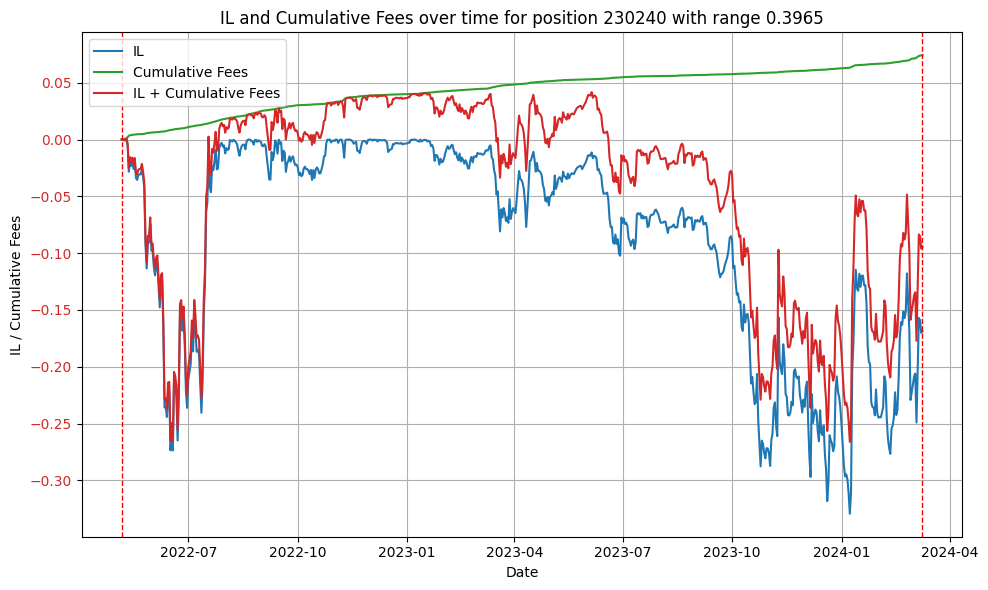

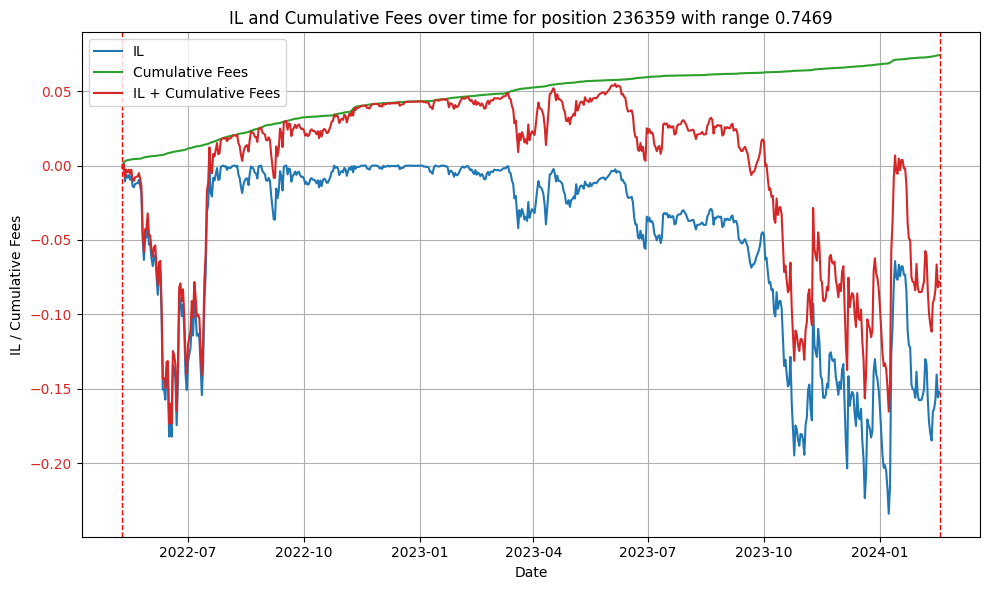

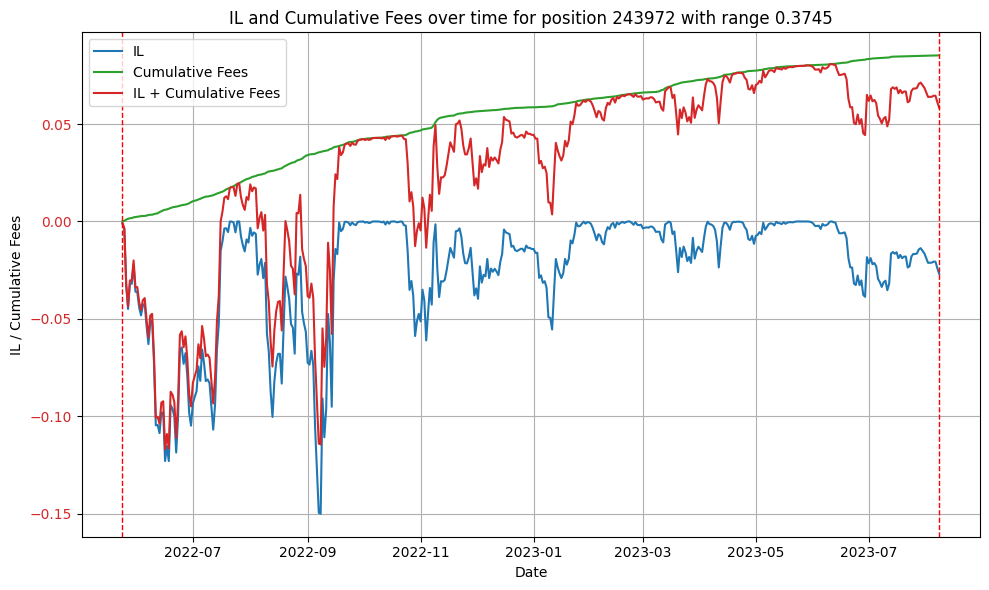

In [454]:
#Example position 100625 from WBTC/WETH 3000 pool
# Examples: 230240, 236359, 243972

positions_list = [230240, 236359, 243972]

for position_id in positions_list:

    position_data = await Extract_Position_data([position_id])
    token_ids = [wbtc.id, weth.id]
    df = position_data[0]
    normalized_df = normalize_df_query(df)
    normalized_df.to_markdown

    price_data = await Extract_Price_data([token_ids, [timestamp // 3600 for timestamp in normalized_df['event_timestamp']]])
    price_data

    for idx, token_id in enumerate(token_ids):
        price_col_name = f'price_{idx}'
        if token_id in [dai.id, usdc.id]:
            normalized_df[price_col_name] = 1.0
        else:
            prices = price_data.xs(token_id, level='tokenID')['priceUSD']
            normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
            print("Before map", normalized_df[price_col_name])
            normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)
            print("After map:", normalized_df[price_col_name])
        print(f"Prices added for token ID: {token_id}")

    calculated_df = calculations(normalized_df)

    index = 1

    df_simulation = pd.DataFrame()

    pb = calculated_df.at[index, 'price1_upper']
    pa = calculated_df.at[index, 'price1_lower']

    df = pool_data[wbtc_weth_3000.name]

    for i, row in df.iterrows():

        df_simulation.at[i, 'pb'] = calculated_df.at[0, 'price0_upper']
        df_simulation.at[i, 'pa'] = calculated_df.at[0, 'price0_lower']

        print("pb: ", df_simulation.at[i, 'pb'])
        print("pa: ", df_simulation.at[i, 'pa'])

        df_simulation.at[i, 'timestamp'] = df.at[i, 'date']

        mint_price0 = calculated_df.at[1, 'average_mint_price1'] / calculated_df.at[1, 'average_mint_price0']
        mint_price1 = calculated_df.at[1, 'average_mint_price0'] / calculated_df.at[1, 'average_mint_price1']
        
        df_simulation.at[i, 'priceQuotient0'] = (df.at[i, 'token0Price'] / df.at[i, 'token1Price']) / (mint_price0 / mint_price1) # change of token0/token1 price ratio
        df_simulation.at[i, 'priceQuotient1'] = (df.at[i, 'token1Price'] / df.at[i, 'token0Price']) / (mint_price1 / mint_price0) # change of token1/token0 price ratio

        print("Token0 price: ", df.at[i, 'token0Price'])
        print("Token1 price: ", df.at[i, 'token1Price'])
        print("Price0: ", mint_price0)
        print("Price1: ", mint_price1)

        df_simulation.at[i, 'd'] = df_simulation.at[i, 'priceQuotient1']

        df_simulation.at[i, 'p'] = mint_price1  # initial price ratio of token1 in token0

        print("d: ", df_simulation.at[i, 'd'])
        print("p: ", df_simulation.at[i, 'p'])

        df_simulation.at[i, 'IL_formula'] = formula_IL(df_simulation.at[i, 'pb'], df_simulation.at[i, 'pa'], df_simulation.at[i, 'd'], df_simulation.at[i, 'p'])

        df_simulation.at[i, 'feesUSD'] = df.at[i, 'feesUSD']

    df_simulation['timestamp'] = pd.to_datetime(df_simulation['timestamp'], unit='d', origin='unix')

    # Convert event_timestamp to datetime
    calculated_df['event_date'] = pd.to_datetime(calculated_df['event_timestamp']//3600, unit='h', origin='unix')

    position_range = 0.5 * ((calculated_df['price1_upper'] - calculated_df['price1_lower']) / (calculated_df['price_1']/calculated_df['price_0']))
    print("Range:", position_range)

    df_simulation['feesUSD'] = df_simulation['feesUSD'].astype(float)
    df_simulation = df_simulation[~(df_simulation['timestamp'] < calculated_df['event_date'].iloc[0])]
    df_simulation = df_simulation[~(df_simulation['timestamp'] > calculated_df['event_date'].iloc[-1])]
    df_simulation['feesUSD'] = df_simulation['feesUSD'].cumsum()

    df_simulation['relative_fees'] = (df_simulation['feesUSD'] / (df_simulation['feesUSD'].max() / calculated_df['event_feesUSD'].max())) / calculated_df['event_amountUSD'].iloc[-1]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # set title
    plt.title(f'IL and Cumulative Fees over time for position {position_id} with range {position_range[0]:.4f}')

    # Plotting IL
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.plot(df_simulation['timestamp'], df_simulation['IL_formula'], linestyle='-', color=color, label='IL')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Plotting cumulative fees on the same axis
    color = 'tab:green'
    ax1.set_ylabel('IL / Cumulative Fees')
    #calculated_df['relative_fees'] = calculated_df['event_feesUSD']/calculated_df['event_amountUSD']
    ax1.plot(df_simulation['timestamp'], df_simulation['relative_fees'], linestyle='-', color=color, label='Cumulative Fees')
    ax1.tick_params(axis='y', labelcolor=color)

    # plot the sume of IL and fees
    color = 'tab:red'
    ax1.plot(df_simulation['timestamp'], df_simulation['IL_formula'] + df_simulation['relative_fees'], linestyle='-', color=color, label='IL + Cumulative Fees')
    ax1.tick_params(axis='y', labelcolor=color)

    # add legend
    ax1.legend(loc='upper left')

    # Marking event dates
    for i in range(len(calculated_df)):
        event_date = calculated_df.loc[i, 'event_date']
        ax1.axvline(x=event_date, color='r', linestyle='--', linewidth=1)

    # print final IL and fees
    print("Final IL: ", df_simulation['IL_formula'].iloc[-1])
    print("Final Cumulative Fees: ", df_simulation['relative_fees'].iloc[-1])


    fig.tight_layout()

plt.show()

# note: errors here are normal, since sections of the measurement model above have been reused and prouce data not relevant for this simulation


In [983]:
pool_data['WBTC_WETH_3000']

date  txCount       tvlUSD  token0Price  token1Price     feesUSD  \
0    19113       91  356656428.0       0.0734      13.6158  54371.9853   
1    19114      163  354382740.0       0.0741      13.4988  93414.3823   
2    19115       66  344557422.0       0.0737      13.5766  29909.9286   
3    19116      144  361021063.0       0.0739      13.5300  92486.9825   
4    19117      105  333595703.0       0.0753      13.2830  55530.8911   
..     ...      ...          ...          ...          ...         ...   
696  19809      129  523113966.0       0.0506      19.7816  33496.8000   
697  19810      111  533595528.0       0.0503      19.8927  30161.8824   
698  19811      117  526451851.0       0.0503      19.8886  27600.2698   
699  19812      135  482685278.0       0.0503      19.8837  30067.3975   
700  19813      130  496844407.0       0.0512      19.5218  45708.9861   

        volumeUSD  
0    1.812400e+07  
1    3.113813e+07  
2    9.969976e+06  
3    3.082899e+07  
4    1.851030e+07  
..            ...  
696  1.116560e+07  
697  1.005396e+07  
698  9.200090e+06  
699  1.002247e+07  
700  1.523633e+07  

[701 rows x 7 columns]

In [173]:
pool_dataframes = result.result()

# Remove zero amounts from pool_dataframes
for key, value in pool_dataframes.items():
    # Filter the dataframe based on certain conditions and create a copy
    filtered_df = value[(value['IL_formula'] <= 0) & 
                        (value['event_amountUSD'] > 1) & 
                        (value['IL_formula'] > -1) &
                        (value['event_feesUSD'] >= 0) &
                        (value['event_feesUSD'] < value['event_amountUSD'])].copy()

    filtered_df['IL_formula_annualized'] = (filtered_df['IL_formula'] + 1) ** (1 / (filtered_df['weightedDurationSeconds'] / 3600 / 24 / 365.25)) - 1
    filtered_df['relativeFees'] = filtered_df['event_feesUSD'] / filtered_df['event_amountUSD']
    filtered_df['annualizedFees'] = (filtered_df['relativeFees'] + 1) ** (1 / (filtered_df['weightedDurationSeconds'] / 3600 / 24 / 365.25)) - 1
    filtered_df['percentageReturn'] = filtered_df['relativeFees'] + filtered_df['IL_formula']
    filtered_df['daily_IL_formula'] = filtered_df['IL_formula'] / (filtered_df['weightedDurationSeconds'] / 3600 / 24)
    filtered_df['daily_Fees'] = filtered_df['relativeFees'] / (filtered_df['weightedDurationSeconds'] / 3600 / 24)
    filtered_df['durationDays'] = filtered_df['weightedDurationSeconds'] / 3600 / 24

    # set all daily IL or fees values to -1 if they are smaller than -1
    filtered_df.loc[filtered_df['daily_IL_formula'] < -1, 'daily_IL_formula'] = -1
    filtered_df.loc[filtered_df['daily_Fees'] > 1, 'daily_Fees'] = 1

    filtered_df['daily_percentageReturn'] = filtered_df['daily_Fees'] + filtered_df['daily_IL_formula']

    # Update the dataframe in the pool_dataframes dictionary with the filtered and calculated values
    pool_dataframes[key] = filtered_df

dataframes = [df for df in pool_dataframes.values()]

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df = combined_df[(combined_df['IL_final'] >= -1) & (combined_df['IL_final'] <= 0) & (combined_df['event_amountUSD'] != 0) & (combined_df['IL_formula'] >= -1)]

# Create pool set without stablecoin-stablecoin pools based on keys from the pool_dataframes dictionary
risky_pools = {key: value for key, value in pool_dataframes.items() if key not in ['DAI_USDC_500', 'DAI_USDC_100']}
risky_dataframes = [df for df in risky_pools.values()]
risky_combined_df = pd.concat(risky_dataframes, ignore_index=True)

In [466]:
print(combined_df['percentageReturn'].describe())

count    2.515400e+04
mean    -1.555539e-03
std      8.271267e-02
min     -8.016198e-01
25%     -1.157186e-02
50%      8.556031e-08
75%      7.073376e-03
max      9.056099e-01
Name: percentageReturn, dtype: float64


In [242]:
pool_dataframes['WBTC_WETH_3000']['price_1'].describe()

count    6772.000000
mean     1608.743497
std       474.526936
min       938.123000
25%      1275.452800
50%      1564.638900
75%      1764.412500
max      4802.898200
Name: price_1, dtype: float64

In [116]:
combined_df.columns

Index(['id', 'owner', 'pool_id', 'position_amountCollectedUSD',
       'position_amountDepositedUSD', 'position_amountWithdrawnUSD',
       'position_id', 'position_liquidity', 'position_withdrawnToken0',
       'position_withdrawnToken1', 'position_token0.id', 'position_token1.id',
       'event_amount', 'event_amount0', 'event_amount1', 'event_amountUSD',
       'event_timestamp', 'price_0', 'price_1', 'initialValue', 'HODLValue',
       'finalValue', 'event_fees0', 'event_fees1', 'lossVersusHODLFees',
       'lossVersusHODLExact', 'lossVersusHODLEst', 'weightedDurationSeconds',
       'IL_initial', 'IL_final', 'absolute_return', 'relative_return',
       'IL_total_abs', 'IL_total_rel', 'IL_annualized', 'relativeBurnSize',
       'IL_formula', 'IL_formula_total', 'IL_annualized_total', 'IL_fees',
       'event_feesUSD', 'price0_lower', 'price1_lower', 'price0_upper',
       'price1_upper', 'IL_formula_annualized', 'average_mint_price0',
       'average_mint_price1', 'priceQuotient0',

In [1001]:
pool_table_data = []

# Iterate through pool_dataframes dictionary
for pool, df in pool_dataframes.items():

    pool_name = pool.replace('_', '-')
    # Sample size
    sample_size = len(df)
    
    # Unique addresses
    unique_addresses = df['owner'].nunique()
    
    # Unique IDs
    unique_ids = df['id'].nunique()
    
    # Append data to the DataFrame
    pool_table_data.append({
        'Pool': pool_name,
        'Sample Size': sample_size,
        'Unique Addresses': unique_addresses,
        'Unique IDs': unique_ids,
    })

# Convert the list of dictionaries to a DataFrame for pool information
pool_table_df = pd.DataFrame(pool_table_data)

# Calculate sums for each column
sum_row = pool_table_df.sum().to_dict()
sum_row['Pool'] = 'Total'

# Append the sum row to the DataFrame
pool_table_df = pd.concat([pool_table_df, pd.DataFrame(sum_row, index=[0])], ignore_index=True)

# Print LaTeX table for pool information
print("Pool Information:")
print(pool_table_df.to_latex(index=False))
print()

# Create an empty DataFrame to store the results for IL and fees percentiles
percentiles_table_data = []

# Iterate through pool_dataframes dictionary
for pool, df in pool_dataframes.items():
    pool_name = pool.replace('_', '-')
    # Calculate percentiles of impermanent loss
    il_values_sorted = df['IL_formula'].sort_values()
    percentiles = [0, 0.25, 0.5, 0.75, 1]
    il_percentiles = [il_values_sorted.quantile(q=p) for p in percentiles]
    
    # Calculate percentiles of fees
    fees_values_sorted = df['relativeFees'].sort_values()
    fees_percentiles = [fees_values_sorted.quantile(q=p) for p in percentiles]
    
    # Append data to the DataFrame for IL
    percentiles_table_data.append({
        'Pool': pool_name,
        'Metric': 'IL',
        '0%': il_percentiles[0],
        '25%': il_percentiles[1],
        '50%': il_percentiles[2],
        '75%': il_percentiles[3],
        '100%': il_percentiles[4],
    })
    
    # Append data to the DataFrame for fees
    percentiles_table_data.append({
        'Pool': pool_name,
        'Metric': 'Fees',
        '0%': fees_percentiles[0],
        '25%': fees_percentiles[1],
        '50%': fees_percentiles[2],
        '75%': fees_percentiles[3],
        '100%': fees_percentiles[4],
    })

# Convert the list of dictionaries to a DataFrame for IL and fees percentiles
percentiles_table_df = pd.DataFrame(percentiles_table_data)

# Print LaTeX table for IL and fees percentiles
print("IL and Fees Percentiles:")
print(percentiles_table_df.to_latex(index=False, float_format='%.4f'))

Pool Information:
\begin{tabular}{lrrr}
\toprule
Pool & Sample Size & Unique Addresses & Unique IDs \\
\midrule
DAI-USDC-500 & 409 & 353 & 393 \\
DAI-USDC-100 & 803 & 650 & 777 \\
USDC-WETH-10000 & 651 & 377 & 613 \\
USDC-WETH-3000 & 6552 & 3733 & 6081 \\
USDC-WETH-500 & 6660 & 1506 & 5990 \\
USDC-WETH-100 & 457 & 234 & 435 \\
MKR-WETH-10000 & 82 & 63 & 81 \\
WBTC-WETH-3000 & 6772 & 3069 & 6342 \\
WBTC-WETH-500 & 6409 & 1599 & 6032 \\
Total & 28795 & 11584 & 26744 \\
\bottomrule
\end{tabular}


IL and Fees Percentiles:
\begin{tabular}{llrrrrr}
\toprule
Pool & Metric & 0% & 25% & 50% & 75% & 100% \\
\midrule
DAI-USDC-500 & IL & -0.0130 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\
DAI-USDC-500 & Fees & 0.0000 & 0.0000 & 0.0002 & 0.0074 & 0.0470 \\
DAI-USDC-100 & IL & -0.0113 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\
DAI-USDC-100 & Fees & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0431 \\
USDC-WETH-10000 & IL & -0.7036 & -0.0161 & -0.0012 & -0.0000 & 0.0000 \\
USDC-WETH-10000 & Fees & 0.0000 & 0.0000 &

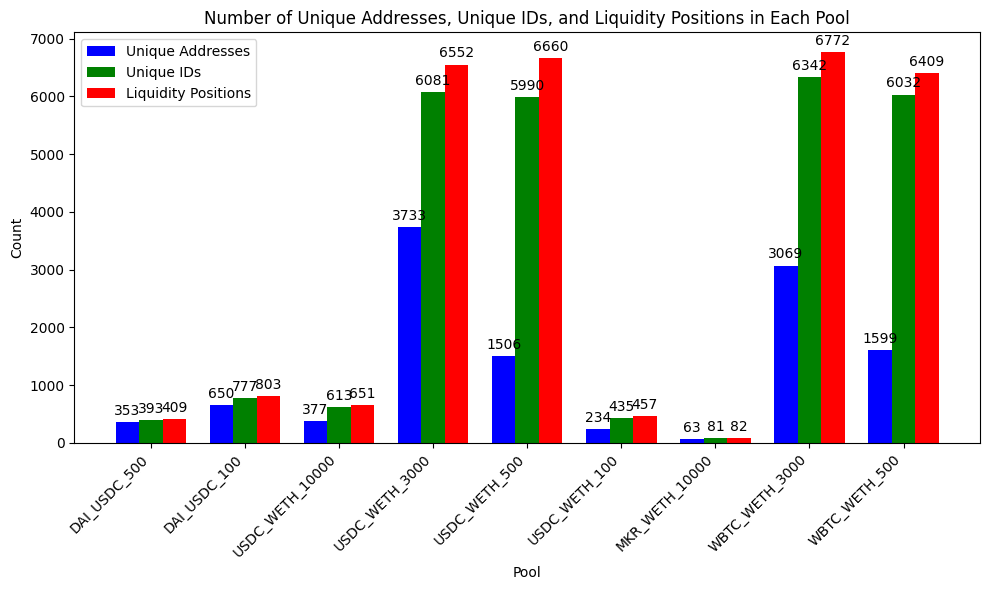

In [406]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pool_dataframes has been preprocessed as described
# and contains the necessary filtered dataframes

# Get the unique address counts, unique ID counts, and number of liquidity positions for each pool
pool_names = []
unique_address_counts = []
unique_id_counts = []
liquidity_position_counts = []

for pool, df in pool_dataframes.items():
    pool_names.append(pool)
    unique_address_counts.append(df['owner'].nunique())
    unique_id_counts.append(df['id'].nunique())
    liquidity_position_counts.append(len(df))  # Number of rows in DataFrame equals the number of liquidity positions

# Create a grouped bar plot with all pools
x = range(len(pool_names))
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x, unique_address_counts, width, label='Unique Addresses', color='b')
bar2 = ax.bar([p + width for p in x], unique_id_counts, width, label='Unique IDs', color='g')
bar3 = ax.bar([p + width * 2 for p in x], liquidity_position_counts, width, label='Liquidity Positions', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Pool')
ax.set_ylabel('Count')
ax.set_title('Number of Unique Addresses, Unique IDs, and Liquidity Positions in Each Pool')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(pool_names, rotation=45, ha='right')
ax.legend()

# Attach a text label above each bar in bar1, bar2, and bar3, displaying its height.
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.tight_layout()
plt.show()


In [526]:
pool_table_data = []

# Iterate through pool_dataframes dictionary
for pool, df in pool_dataframes.items():

    pool_name = pool.replace('_', '-')
    # Sample size
    sample_size = len(df)
    
    # Unique addresses
    unique_addresses = df['owner'].nunique()
    
    # Unique IDs
    unique_ids = df['id'].nunique()
    
    # Append data to the DataFrame
    pool_table_data.append({
        'Pool': pool_name,
        'Sample Size': sample_size,
        'Unique Addresses': unique_addresses,
        'Unique IDs': unique_ids,
    })

# Convert the list of dictionaries to a DataFrame for pool information
pool_table_df = pd.DataFrame(pool_table_data)

# Calculate sums for each column
sum_row = pool_table_df.sum().to_dict()
sum_row['Pool'] = 'Total'

# Append the sum row to the DataFrame
pool_table_df = pd.concat([pool_table_df, pd.DataFrame(sum_row, index=[0])], ignore_index=True)

# Print LaTeX table for pool information
print("Pool Information:")
print(pool_table_df.to_latex(index=False))
print()

# Create an empty DataFrame to store the results for IL and fees percentiles
percentiles_table_data = []

# Iterate through pool_dataframes dictionary
for pool, df in pool_dataframes.items():
    pool_name = pool.replace('_', '-')
    # Calculate percentiles of impermanent loss
    il_values_sorted = df['IL_formula'].sort_values()
    percentiles = [0, 0.25, 0.5, 0.75, 1]
    il_percentiles = [il_values_sorted.quantile(q=p) for p in percentiles]
    
    # Calculate percentiles of fees
    fees_values_sorted = df['relativeFees'].sort_values()
    fees_percentiles = [fees_values_sorted.quantile(q=p) for p in percentiles]
    
    # Append data to the DataFrame for IL
    percentiles_table_data.append({
        'Pool': pool_name,
        'Metric': 'IL',
        '0%': il_percentiles[0],
        '25%': il_percentiles[1],
        '50%': il_percentiles[2],
        '75%': il_percentiles[3],
        '100%': il_percentiles[4],
    })
    
    # Append data to the DataFrame for fees
    percentiles_table_data.append({
        'Pool': pool_name,
        'Metric': 'Fees',
        '0%': fees_percentiles[0],
        '25%': fees_percentiles[1],
        '50%': fees_percentiles[2],
        '75%': fees_percentiles[3],
        '100%': fees_percentiles[4],
    })

# Convert the list of dictionaries to a DataFrame for IL and fees percentiles
percentiles_table_df = pd.DataFrame(percentiles_table_data)

# Print LaTeX table for IL and fees percentiles
print("IL and Fees Percentiles:")
print(percentiles_table_df.to_latex(index=False, float_format='%.4f'))

Pool Information:
\begin{tabular}{lrrr}
\toprule
Pool & Sample Size & Unique Addresses & Unique IDs \\
\midrule
DAI-USDC-500 & 328 & 287 & 312 \\
DAI-USDC-100 & 677 & 556 & 655 \\
USDC-WETH-10000 & 558 & 333 & 527 \\
USDC-WETH-3000 & 5992 & 3512 & 5573 \\
USDC-WETH-500 & 6082 & 1452 & 5499 \\
USDC-WETH-100 & 402 & 207 & 382 \\
MKR-WETH-10000 & 61 & 49 & 60 \\
WBTC-WETH-3000 & 5774 & 2769 & 5421 \\
WBTC-WETH-500 & 5280 & 1481 & 4961 \\
Total & 25154 & 10646 & 23390 \\
\bottomrule
\end{tabular}


IL and Fees Percentiles:
\begin{tabular}{llrrrrr}
\toprule
Pool & Metric & 0% & 25% & 50% & 75% & 100% \\
\midrule
DAI-USDC-500 & IL & -0.0130 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\
DAI-USDC-500 & Fees & 0.0000 & 0.0000 & 0.0001 & 0.0108 & 0.0470 \\
DAI-USDC-100 & IL & -0.0113 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\
DAI-USDC-100 & Fees & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0431 \\
USDC-WETH-10000 & IL & -0.4807 & -0.0214 & -0.0028 & -0.0000 & 0.0000 \\
USDC-WETH-10000 & Fees & 0.0000 & 0.0001 &

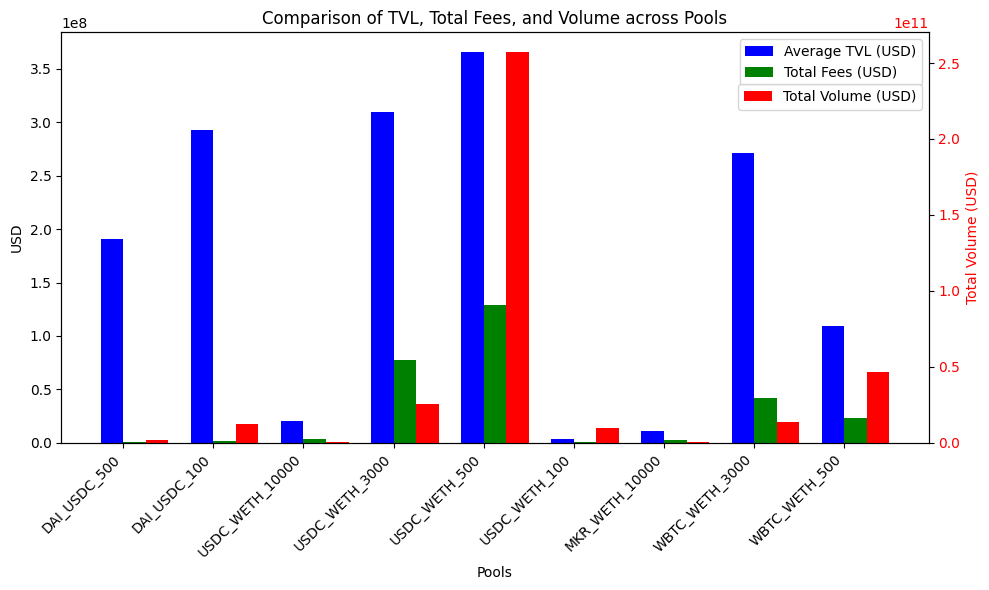

In [405]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
pool_histogram_data = {
    'pool': [],
    'average_TVL': [],
    'total_fees': [],
    'total_volume': []
}

for pool, df in pool_data.items():
    pool_histogram_data['pool'].append(pool)
    pool_histogram_data['average_TVL'].append(df['tvlUSD'].mean())
    pool_histogram_data['total_fees'].append(df['feesUSD'].sum())
    pool_histogram_data['total_volume'].append(df['volumeUSD'].sum())

# Converting to DataFrame for easy plotting
pool_histogram_df = pd.DataFrame(pool_histogram_data)

# Plotting the histogram
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(pool_histogram_df['pool']))

# Plot fees and TVL on the primary y-axis
ax1.bar(index, pool_histogram_df['average_TVL'], bar_width, label='Average TVL (USD)', color='b')
ax1.bar(index + bar_width, pool_histogram_df['total_fees'], bar_width, label='Total Fees (USD)', color='g')
ax1.set_xlabel('Pools')
ax1.set_ylabel('USD')
ax1.set_title('Comparison of TVL, Total Fees, and Volume across Pools')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(pool_histogram_df['pool'], rotation=45, ha='right')
ax1.legend()

# Create a secondary y-axis for total volume
ax2 = ax1.twinx()
ax2.bar(index + 2*bar_width, pool_histogram_df['total_volume'], bar_width, label='Total Volume (USD)', color='r')
ax2.set_ylabel('Total Volume (USD)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.89))

plt.tight_layout()
plt.show()



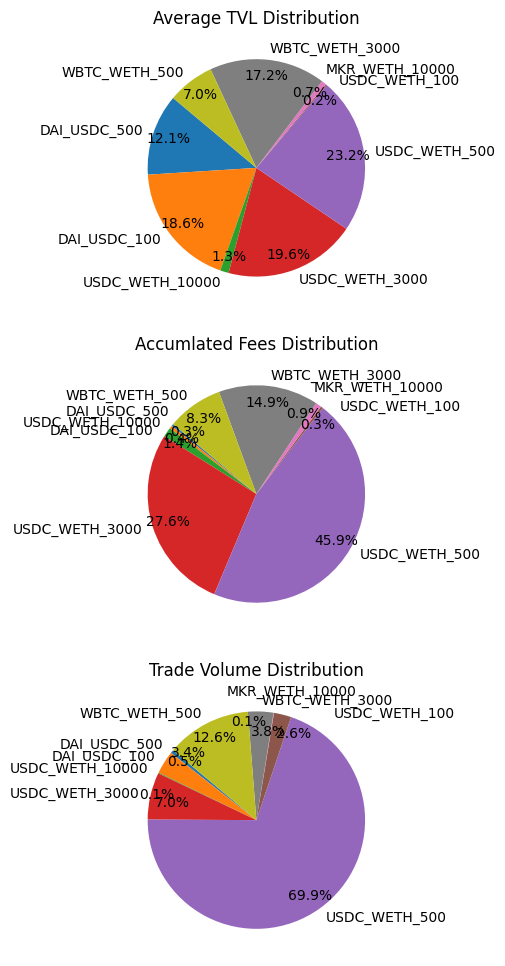

In [404]:
import matplotlib.pyplot as plt
import numpy as np

# Define the fix_labels function
def fix_labels(mylabels, tooclose=0.1, sepfactor=2):
    vecs = np.zeros((len(mylabels), len(mylabels), 2))
    dists = np.zeros((len(mylabels), len(mylabels)))
    for i in range(0, len(mylabels)-1):
        for j in range(i+1, len(mylabels)):
            a = np.array(mylabels[i].get_position())
            b = np.array(mylabels[j].get_position())
            dists[i,j] = np.linalg.norm(a-b)
            vecs[i,j,:] = a-b
            if dists[i,j] < tooclose:
                mylabels[i].set_x(a[0] + sepfactor*vecs[i,j,0])
                mylabels[i].set_y(a[1] + sepfactor*vecs[i,j,1])
                mylabels[j].set_x(b[0] - sepfactor*vecs[i,j,0])
                mylabels[j].set_y(b[1] - sepfactor*vecs[i,j,1])

# Data preparation
pool_pie_data = {
    'pool': [],
    'average_TVL': [],
    'total_fees': [],
    'total_volume': []
}

for pool, df in pool_data.items():
    pool_pie_data['pool'].append(pool)
    pool_pie_data['average_TVL'].append(df['tvlUSD'].mean())
    pool_pie_data['total_fees'].append(df['feesUSD'].sum())
    pool_pie_data['total_volume'].append(df['volumeUSD'].sum())

# Plotting the pie charts
fig, axes = plt.subplots(3, 1, figsize=(4, 12))

# Pie chart for Average TVL
wedges1, labels1, autopct1 = axes[0].pie(pool_pie_data['average_TVL'], labels=pool_pie_data['pool'], autopct='%1.1f%%', startangle=140, pctdistance=0.85)
axes[0].set_title('Average TVL Distribution')
fix_labels(labels1, sepfactor=2)
fix_labels(autopct1, sepfactor=2)

# Pie chart for Total Fees
wedges2, labels2, autopct2 = axes[1].pie(pool_pie_data['total_fees'], labels=pool_pie_data['pool'], autopct='%1.1f%%', startangle=140, pctdistance=0.85)
axes[1].set_title('Accumlated Fees Distribution')
fix_labels(labels2, sepfactor=3)
fix_labels(autopct2, sepfactor=2)

# Pie chart for Total Volume
wedges3, labels3, autopct3 = axes[2].pie(pool_pie_data['total_volume'], labels=pool_pie_data['pool'], autopct='%1.1f%%', startangle=140, pctdistance=0.85)
axes[2].set_title('Trade Volume Distribution')
fix_labels(labels3, sepfactor=5)
fix_labels(autopct3, sepfactor=2)

plt.show()


In [560]:
pool_data[wbtc_weth_3000.name]['txCount'].head()

0     91
1    163
2     66
3    144
4    105
Name: txCount, dtype: object

Statistics for DAI_USDC_500:
count       700.000000
mean     573150.050299
std      311860.050447
min         589.757000
25%      267478.074050
50%      782668.506400
75%      855907.554700
max      902904.611300
Name: cum_feesUSD, dtype: float64
Statistics for DAI_USDC_100:
count    7.010000e+02
mean     7.868467e+05
std      3.342578e+05
min      1.309735e+03
25%      5.306277e+05
50%      8.924700e+05
75%      1.073332e+06
max      1.261735e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_10000:
count    6.830000e+02
mean     3.015136e+06
std      1.074974e+06
min      3.522302e+03
25%      2.528959e+06
50%      3.428694e+06
75%      3.782718e+06
max      3.998170e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_3000:
count    7.010000e+02
mean     5.402458e+07
std      1.815025e+07
min      1.273015e+05
25%      4.449728e+07
50%      6.176979e+07
75%      6.606108e+07
max      7.732777e+07
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_500:
c

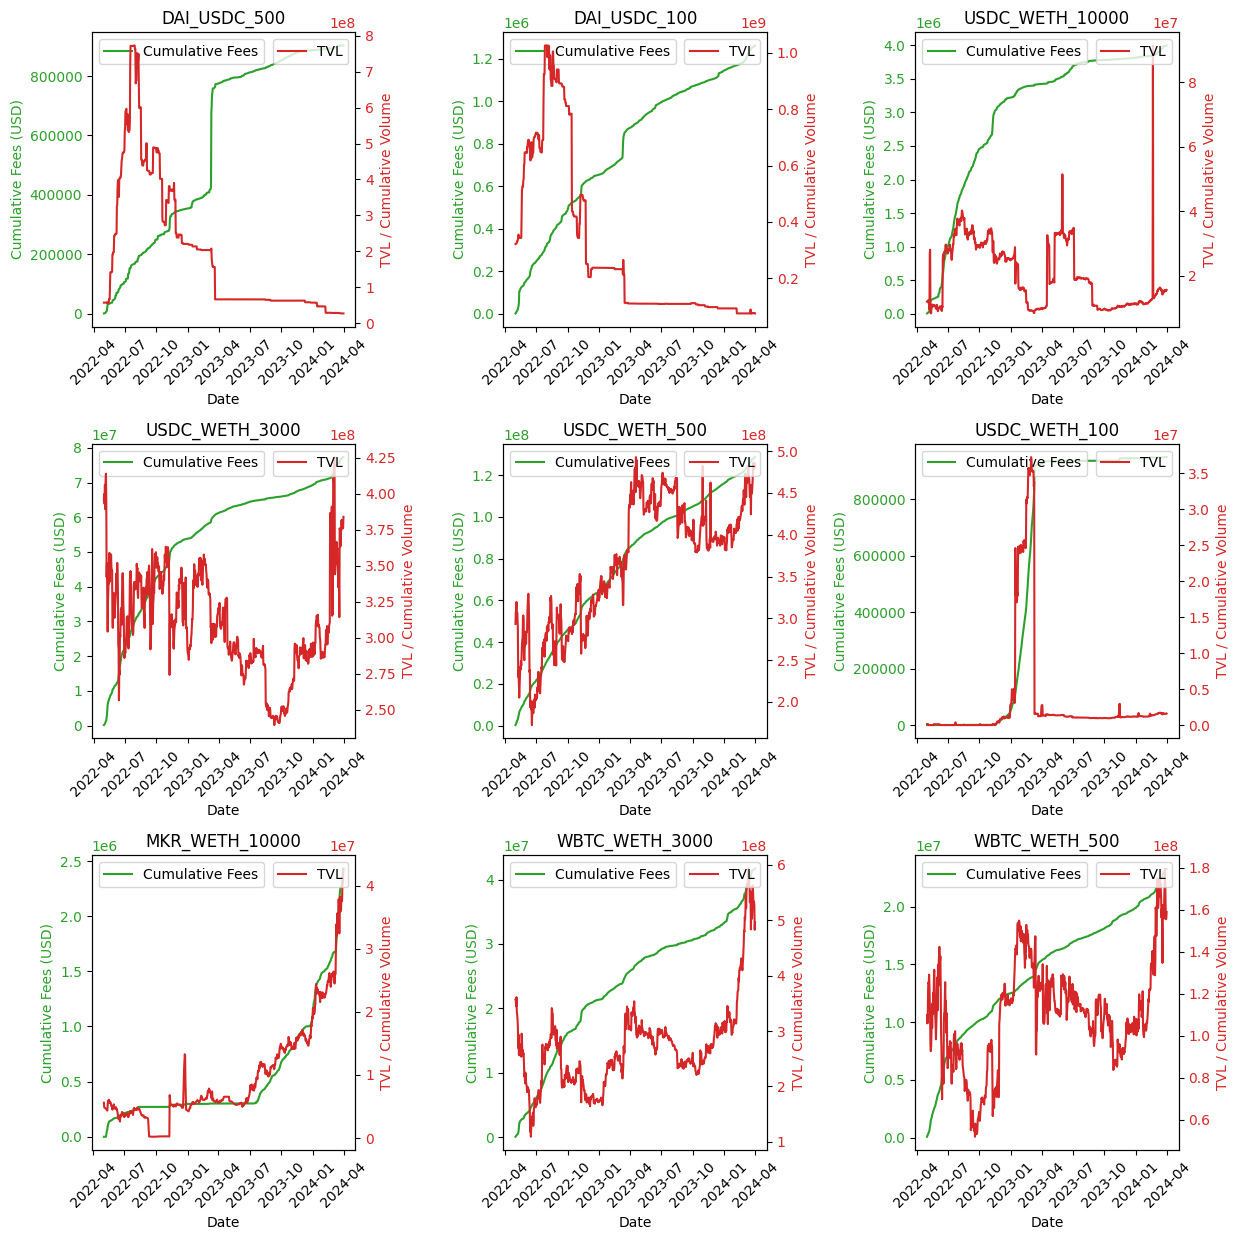

In [409]:
fig, axes = plt.subplots(3, 3, figsize=(12.5, 12.5))

axes = axes.flatten()

# Iterate over each key in the pool_data dictionary
for i, (pool_name, data) in enumerate(pool_data.items()):
    # Create DataFrame from the provided data
    pool_df = pd.DataFrame(data)

    # Convert 'date' from days since epoch to datetime
    pool_df['date'] = pd.to_datetime(pool_df['date'], origin='1970-01-01', unit='D')

    # Set datatypes for the columns
    pool_df['tvlUSD'] = pool_df['tvlUSD'].astype(float)
    pool_df['feesUSD'] = pool_df['feesUSD'].astype(float)
    pool_df['volumeUSD'] = pool_df['volumeUSD'].astype(float)
    pool_df['txCount'] = pool_df['txCount'].astype(int)

    # Round tvlUSD to 4 decimals
    pool_df['tvlUSD'] = pool_df['tvlUSD'].round(4)

    # Cumulate the feesUSD and volumeUSD over time
    pool_df['cum_feesUSD'] = pool_df['feesUSD'].cumsum()
    pool_df['cum_volumeUSD'] = pool_df['volumeUSD'].cumsum()
    pool_df['cum_txCount'] = pool_df['txCount'].cumsum()

    # Describe cum_feesUSD
    print(f"Statistics for {pool_name}:")
    print(pool_df['cum_feesUSD'].describe())

    # Plot the data
    ax1 = axes[i]
    ax1.plot(pool_df['date'], pool_df['cum_feesUSD'], color='tab:green', label='Cumulative Fees')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Fees (USD)', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    ax1.legend(loc='upper left')

    # Create a second y-axis for tvlUSD and cumulative volumeUSD
    ax2 = ax1.twinx()
    ax2.plot(pool_df['date'], pool_df['tvlUSD'], color='tab:red', label='TVL')
    #ax2.plot(pool_df['date'], pool_df['cum_volumeUSD'], color='tab:orange', label='Cumulative volumeUSD')
    ax2.set_ylabel('TVL / Cumulative Volume', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')

    # Title and layout adjustments
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'{pool_name}')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

Statistics for DAI_USDC_500:
count       700.000000
mean     573150.050299
std      311860.050447
min         589.757000
25%      267478.074050
50%      782668.506400
75%      855907.554700
max      902904.611300
Name: cum_feesUSD, dtype: float64
Statistics for DAI_USDC_100:
count    7.010000e+02
mean     7.868467e+05
std      3.342578e+05
min      1.309735e+03
25%      5.306277e+05
50%      8.924700e+05
75%      1.073332e+06
max      1.261735e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_10000:
count    6.830000e+02
mean     3.015136e+06
std      1.074974e+06
min      3.522302e+03
25%      2.528959e+06
50%      3.428694e+06
75%      3.782718e+06
max      3.998170e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_3000:
count    7.010000e+02
mean     5.402458e+07
std      1.815025e+07
min      1.273015e+05
25%      4.449728e+07
50%      6.176979e+07
75%      6.606108e+07
max      7.732777e+07
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_500:
c

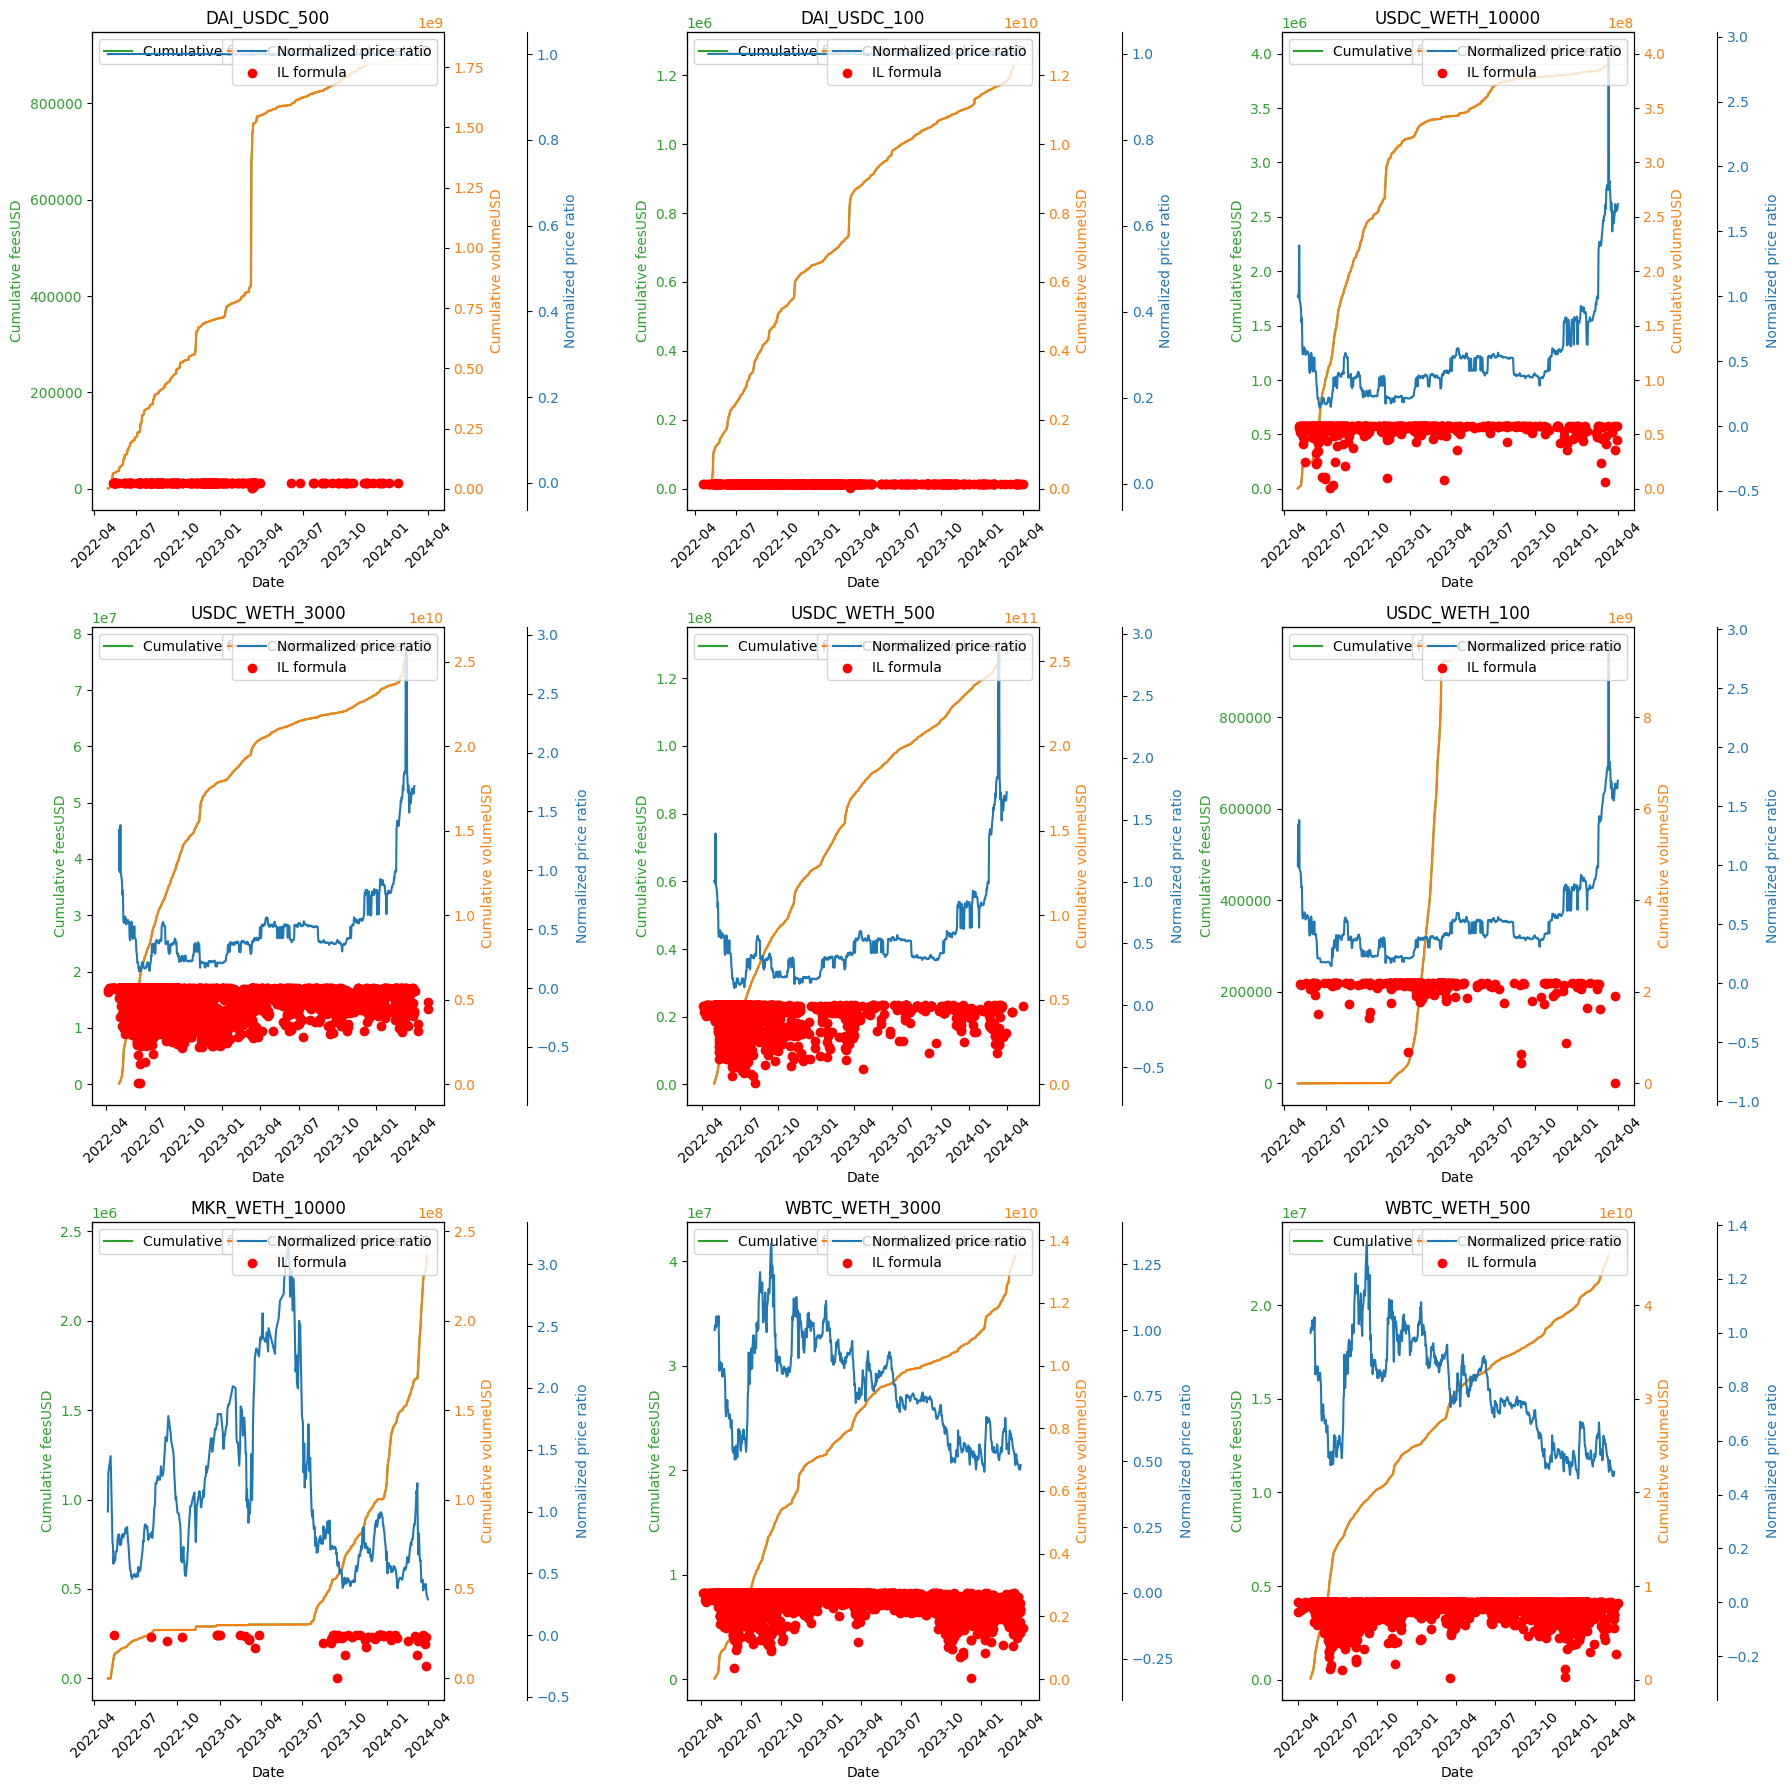

In [547]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

axes = axes.flatten()

start_date = datetime.datetime(2022, 4, 1)

# Iterate over each key in the pool_data dictionary
for i, (pool_name, data) in enumerate(pool_data.items()):
    # Create DataFrame from the provided data
    pool_df = pd.DataFrame(data)

    # Convert 'date' from days since epoch to datetime, ensure date is integer
    pool_df['date'] = pd.to_datetime(pool_df['date'].astype(int), origin='1970-01-01', unit='D')

    pool_df = pool_df[pool_df['date'] >= start_date]

    # Set datatypes for the columns
    pool_df['tvlUSD'] = pool_df['tvlUSD'].astype(float)
    pool_df['feesUSD'] = pool_df['feesUSD'].astype(float)
    pool_df['volumeUSD'] = pool_df['volumeUSD'].astype(float)
    pool_df['token0Price'] = pool_df['token0Price'].astype(float)
    pool_df['token1Price'] = pool_df['token1Price'].astype(float)

    # Calculate cumulative sums and normalized price ratio
    pool_df['cum_feesUSD'] = pool_df['feesUSD'].cumsum()
    pool_df['cum_volumeUSD'] = pool_df['volumeUSD'].cumsum()
    pool_df['price_ratio'] = pool_df['token0Price'] / pool_df['token1Price']
    pool_df['normalized_price_ratio'] = pool_df['price_ratio'] / pool_df['price_ratio'].iloc[0]

    # Describe cum_feesUSD
    print(f"Statistics for {pool_name}:")
    print(pool_df['cum_feesUSD'].describe())

    # Plot the data
    ax1 = axes[i]
    ax1.plot(pool_df['date'], pool_df['cum_feesUSD'], color='tab:green', label='Cumulative feesUSD')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative feesUSD', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    ax1.legend(loc='upper left')

    # Create a second y-axis for cumulative volumeUSD
    ax2 = ax1.twinx()
    ax2.plot(pool_df['date'], pool_df['cum_volumeUSD'], color='tab:orange', label='Cumulative volumeUSD')
    ax2.set_ylabel('Cumulative volumeUSD', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')

    # Create a third y-axis for normalized price ratio
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.plot(pool_df['date'], pool_df['normalized_price_ratio'], color='tab:blue', label='Normalized price ratio')
    ax3.set_ylabel('Normalized price ratio', color='tab:blue')
    ax3.tick_params(axis='y', labelcolor='tab:blue')
    ax3.legend(loc='lower right')

    # Plot IL_formula as dots
    if pool_name in pool_dataframes:
        il_df = pool_dataframes[pool_name]
        il_df.loc[:, 'event_timestamp'] = pd.to_datetime(il_df['event_timestamp'], unit='s')
        il_df = il_df[il_df['event_timestamp'] >= start_date]
        ax3.scatter(il_df['event_timestamp'], il_df['IL_formula'], color='red', zorder=5, label='IL formula')
        ax3.legend(loc='upper right')

    # Title and layout adjustments
    ax1.set_title(f'{pool_name}')

    #rotate x-axis labels
    ax1.tick_params(axis='x', rotation=45)


# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

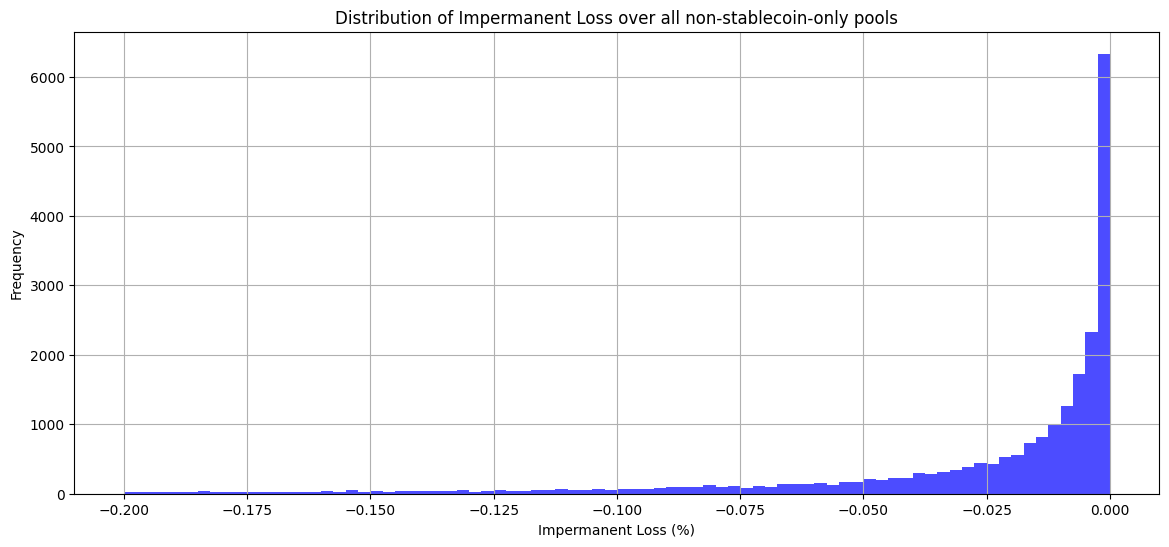

In [824]:
import matplotlib.pyplot as plt
# Histogram of Impermanent Loss
plt.figure(figsize=(14, 6))
plt.hist(risky_combined_df['IL_formula'], bins=80, color='blue', alpha=0.6, range=(-0.2, 0))

plt.title('Distribution of Impermanent Loss over all non-stablecoin-only pools')
plt.xlabel('Impermanent Loss (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

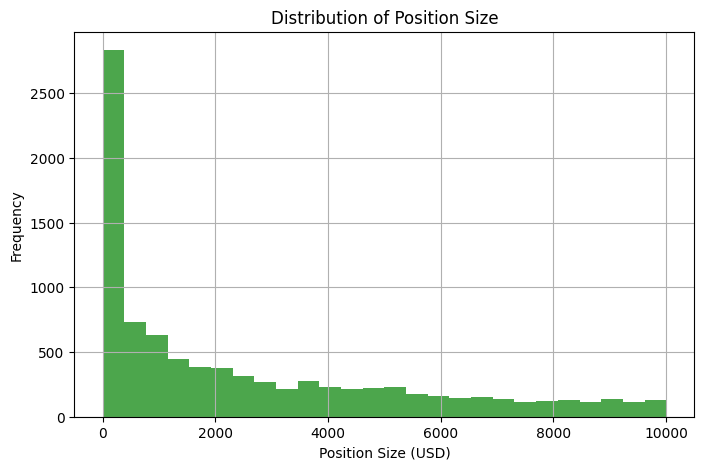

In [298]:
import matplotlib.pyplot as plt

# Histogram of Trade Size
plt.figure(figsize=(8, 5))
plt.hist(combined_df['event_amountUSD'], bins='auto', color='green', alpha=0.6, range=(0, 10000)) 

plt.title('Distribution of Position Size')
plt.xlabel('Position Size (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


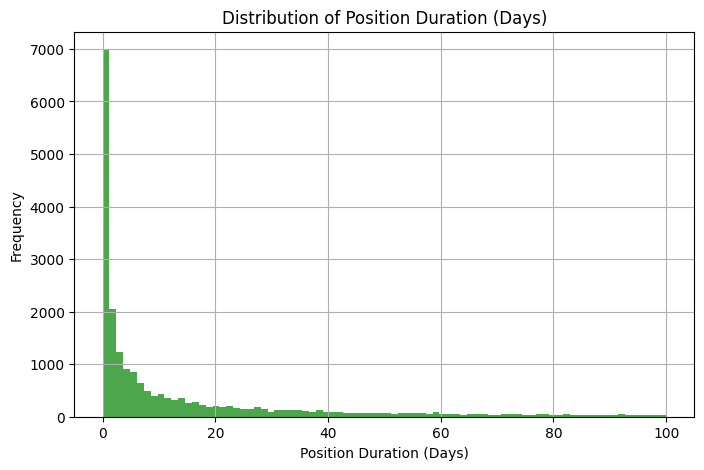

In [299]:
import matplotlib.pyplot as plt

combined_df['weightedDurationDays'] = combined_df['weightedDurationSeconds'] / (3600 * 24)

# Histogram of Trade Size
plt.figure(figsize=(8, 5))
plt.hist(combined_df['weightedDurationDays'], bins='auto', color='green', alpha=0.6, range=(0, 100))  # Adjust range and color as needed

plt.title('Distribution of Position Duration (Days)')
plt.xlabel('Position Duration (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


C:\Users\thano\AppData\Local\Temp\ipykernel_45724\1165197498.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(describe_df.index, rotation=45, ha='right')
C:\Users\thano\AppData\Local\Temp\ipykernel_45724\1165197498.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(describe_df.index, rotation=45, ha='right')


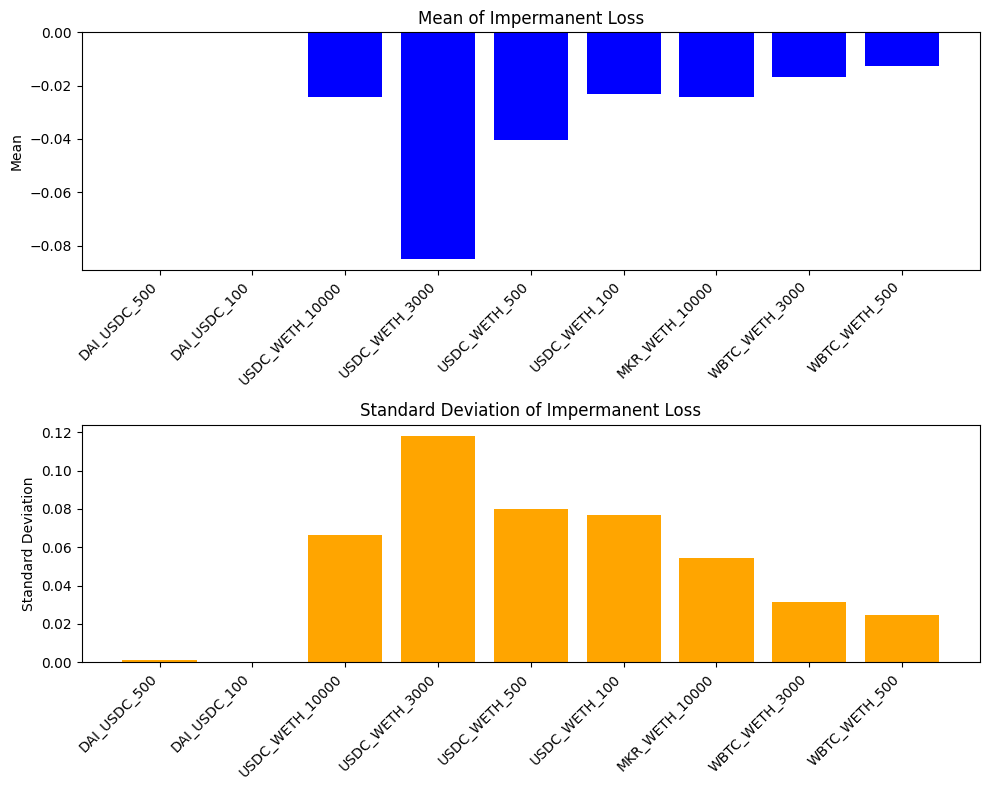

In [304]:
describe_data = {}

for pool, df in pool_dataframes.items():
    describe_data[pool] = df['IL_formula'].describe()

describe_df = pd.DataFrame(describe_data).T

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot mean
axes[0].bar(describe_df.index, describe_df['mean'], color='blue')
axes[0].set_title('Mean of Impermanent Loss')
axes[0].set_ylabel('Mean')
axes[0].set_xticklabels(describe_df.index, rotation=45, ha='right')

# Plot std
axes[1].bar(describe_df.index, describe_df['std'], color='orange')
axes[1].set_title('Standard Deviation of Impermanent Loss')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_xticklabels(describe_df.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

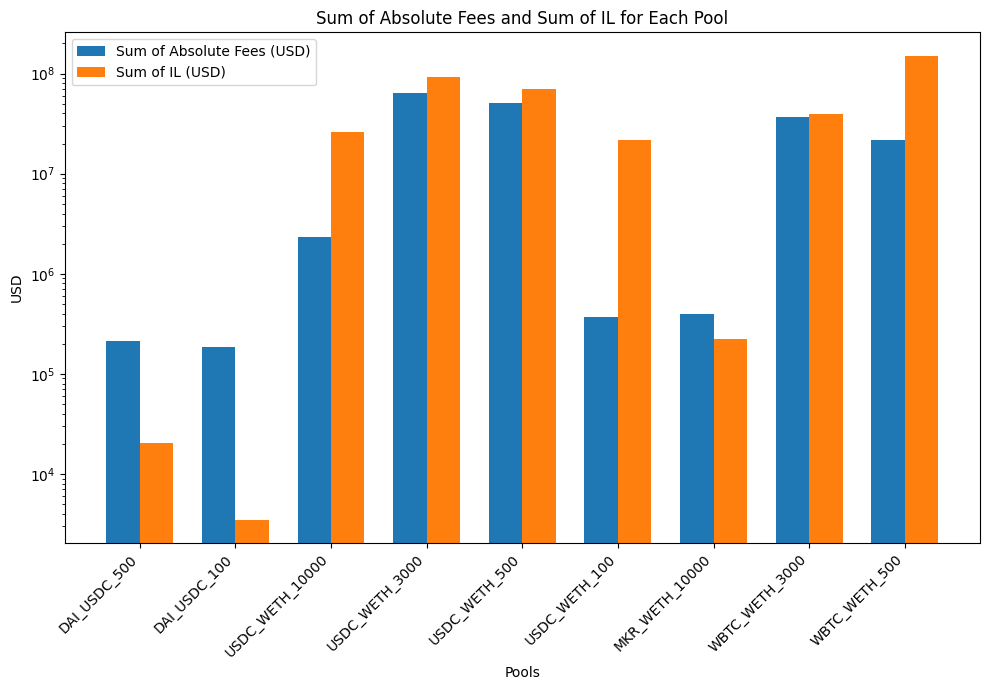

In [305]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
fees_IL_data = {
    'pool': [],
    'sum_feesUSD': [],
    'sum_lossVersusHODLExact': []
}
for pool in pool_dataframes:
    fees_IL_data['pool'].append(pool)
    fees_IL_data['sum_feesUSD'].append(pool_dataframes[pool]['event_feesUSD'].sum())
    fees_IL_data['sum_lossVersusHODLExact'].append(pool_dataframes[pool]['lossVersusHODLExact'].sum())

# Converting to DataFrame for easy plotting
fees_IL_df = pd.DataFrame(fees_IL_data)

# Plotting the combined bar chart with log scale for both positive and negative values
fig, ax = plt.subplots(figsize=(10, 7))

bar_width = 0.35
index = np.arange(len(fees_IL_df['pool']))

# Shifting IL values to be positive
IL_shifted = -fees_IL_df['sum_lossVersusHODLExact']

bar1 = ax.bar(index, fees_IL_df['sum_feesUSD'], bar_width, label='Sum of Absolute Fees (USD)')
bar2 = ax.bar(index + bar_width, IL_shifted, bar_width, label='Sum of IL (USD)')

ax.set_xlabel('Pools')
ax.set_ylabel('USD')
ax.set_title('Sum of Absolute Fees and Sum of IL for Each Pool')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(fees_IL_df['pool'], rotation=45, ha='right')
ax.legend()

# Apply log scale to the y-axis
ax.set_yscale('log')

plt.tight_layout()
plt.show()


In [784]:
print(combined_df['percentageReturn'].describe())

negative_returns_count = (combined_df['percentageReturn'] < 0).sum()
print("Number of negative relative returns:", negative_returns_count/len(combined_df))

# same for risky_combined_df
print(risky_combined_df['percentageReturn'].describe())

negative_returns_count = (risky_combined_df['percentageReturn'] < 0).sum()
print("Number of negative relative returns in risky pools:", negative_returns_count/len(risky_combined_df))

count    2.515400e+04
mean    -1.555539e-03
std      8.271267e-02
min     -8.016198e-01
25%     -1.157186e-02
50%      8.556031e-08
75%      7.073376e-03
max      9.056099e-01
Name: percentageReturn, dtype: float64
Number of negative relative returns: 0.46489623916673295
count    24149.000000
mean        -0.001708
std          0.084404
min         -0.801620
25%         -0.012841
50%          0.000000
75%          0.007570
max          0.905610
Name: percentageReturn, dtype: float64
Number of negative relative returns in risky pools: 0.4841194252349994


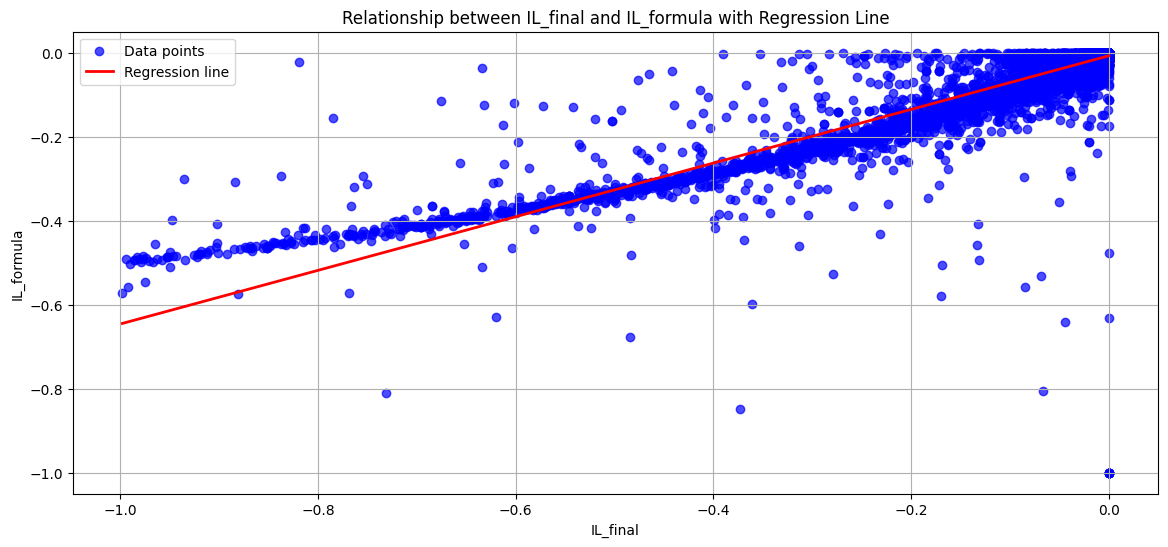

[0.63841606] -0.00766479058480643
R2 0.8495141623145579


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

# Scatter plot of IL_final vs IL_formula
plt.figure(figsize=(14, 6))
plt.scatter(risky_combined_df['IL_final'], risky_combined_df['IL_formula'], color='blue', alpha=0.6, label='Data points')

# Fit a linear regression model
X = risky_combined_df[['IL_final']].values  # Reshape for sklearn
y = risky_combined_df['IL_formula'].values
model = LinearRegression()
model.fit(X, y)

# Create a range of values for IL_final for plotting the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)

# Plot the regression line
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.title('Relationship between IL_final and IL_formula with Regression Line')
plt.xlabel('IL_final')
plt.ylabel('IL_formula')
plt.grid(True)
plt.legend()
plt.show()

print(model.coef_, model.intercept_)

# r2 score
print("R2" , r2_score(y, model.predict(X)))


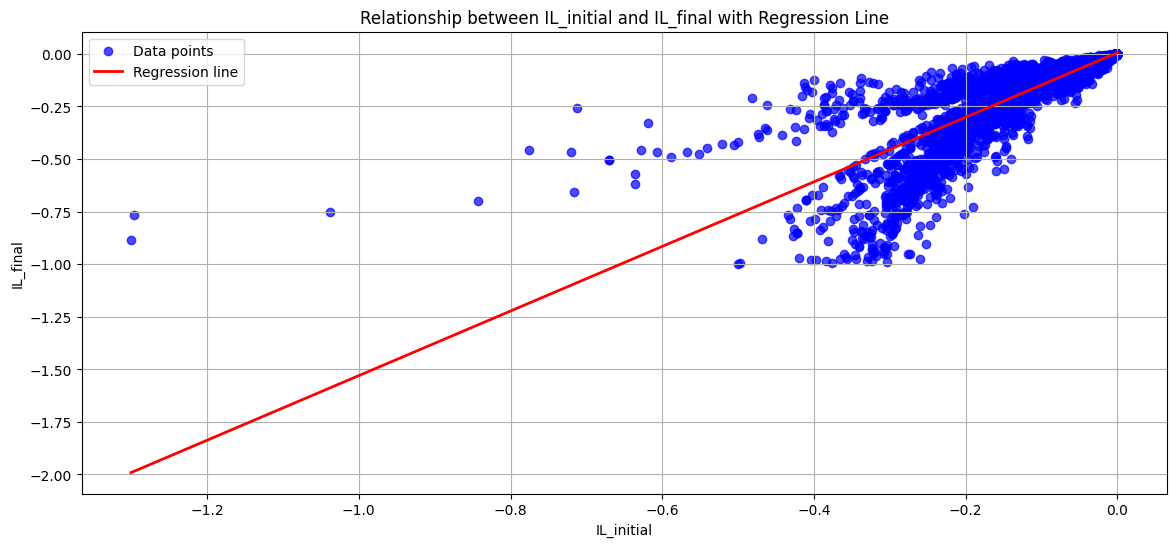

[1.53666831] 0.0063175423355549196


0.7972519375851712

In [815]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

# Scatter plot of IL_initial vs IL_final
plt.figure(figsize=(14, 6))
plt.scatter(risky_combined_df['IL_initial'], risky_combined_df['IL_final'], color='blue', alpha=0.6, label='Data points')

# Fit a linear regression model
X = risky_combined_df[['IL_initial']].values  # Reshape for sklearn
y = risky_combined_df['IL_final'].values
model = LinearRegression()
model.fit(X, y)

# Create a range of values for IL_initial for plotting the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)

# Plot the regression line
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.title('Relationship between IL_initial and IL_final with Regression Line')
plt.xlabel('IL_initial')
plt.ylabel('IL_final')
plt.grid(True)
plt.legend()
plt.show()

print(model.coef_, model.intercept_)

# r2 score
r2_score(y, model.predict(X))

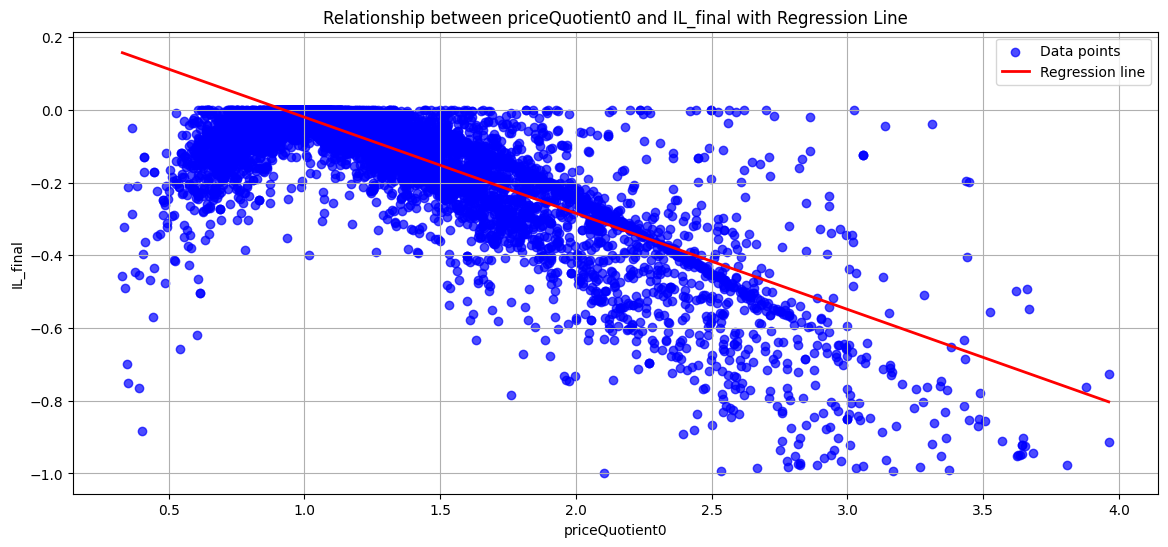

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Scatter plot of priceQuotient0 vs IL_final
plt.figure(figsize=(14, 6))
plt.scatter(combined_df['priceQuotient0'], combined_df['IL_final'], color='blue', alpha=0.6, label='Data points')

# Fit a linear regression model
X = combined_df[['priceQuotient0']].values  # Reshape for sklearn
y = combined_df['IL_final'].values
model = LinearRegression()
model.fit(X, y)

# Create a range of values for priceQuotient0 for plotting the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)

# Plot the regression line
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.title('Relationship between priceQuotient0 and IL_final with Regression Line')
plt.xlabel('priceQuotient0')
plt.ylabel('IL_final')
plt.grid(True)
plt.legend()
plt.show()


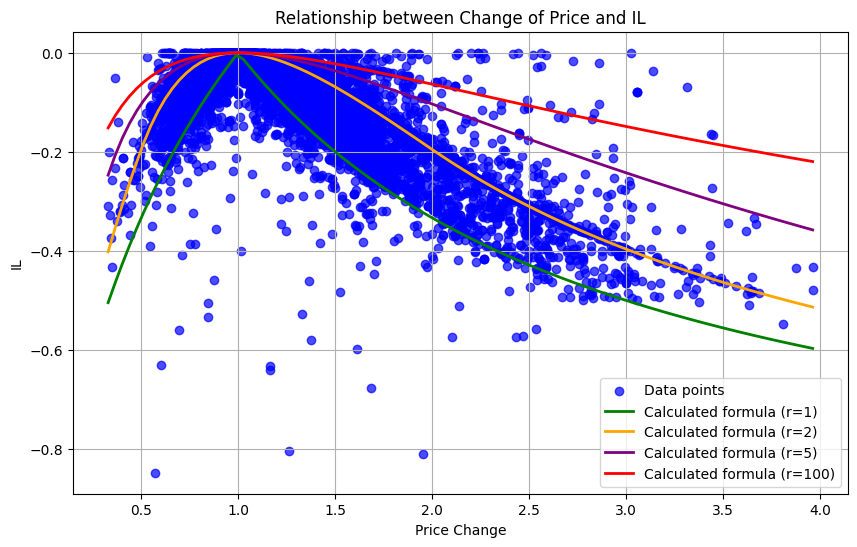

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming combined_df is already defined and filtered

# Scatter plot of priceQuotient0 vs IL_formula
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['priceQuotient0'], combined_df['IL_formula'], color='blue', alpha=0.6, label='Data points')

# Calculate the formula values using the provided piecewise formula for different r values
def calculate_formula(r, d):
    if d < 1/r:
        return (np.sqrt(r) * d - 1) / (1 + d)
    elif 1/r <= d <= r:
        return (np.sqrt(r) / (np.sqrt(r) - 1)) * (2 * np.sqrt(d) / (1 + d) - 1)
    else:  # d > r
        return (np.sqrt(r) - d) / (1 + d)

# Plot the calculated formula for different r values
r_values = [1, 2, 5, 100]
colors = ['green', 'orange', 'purple', 'red']

# Create a range of values for priceQuotient0 for plotting the formula
d_range = np.linspace(combined_df['priceQuotient0'].min(), combined_df['priceQuotient0'].max(), 100)

for r, color in zip(r_values, colors):
    calculated_formula_values = [calculate_formula(r, d) for d in d_range]
    plt.plot(d_range, calculated_formula_values, color=color, linewidth=2, label=f'Calculated formula (r={r})')

plt.title('Relationship between Change of Price and IL')
plt.xlabel('Price Change')
plt.ylabel('IL')
plt.grid(True)
plt.legend()
plt.show()


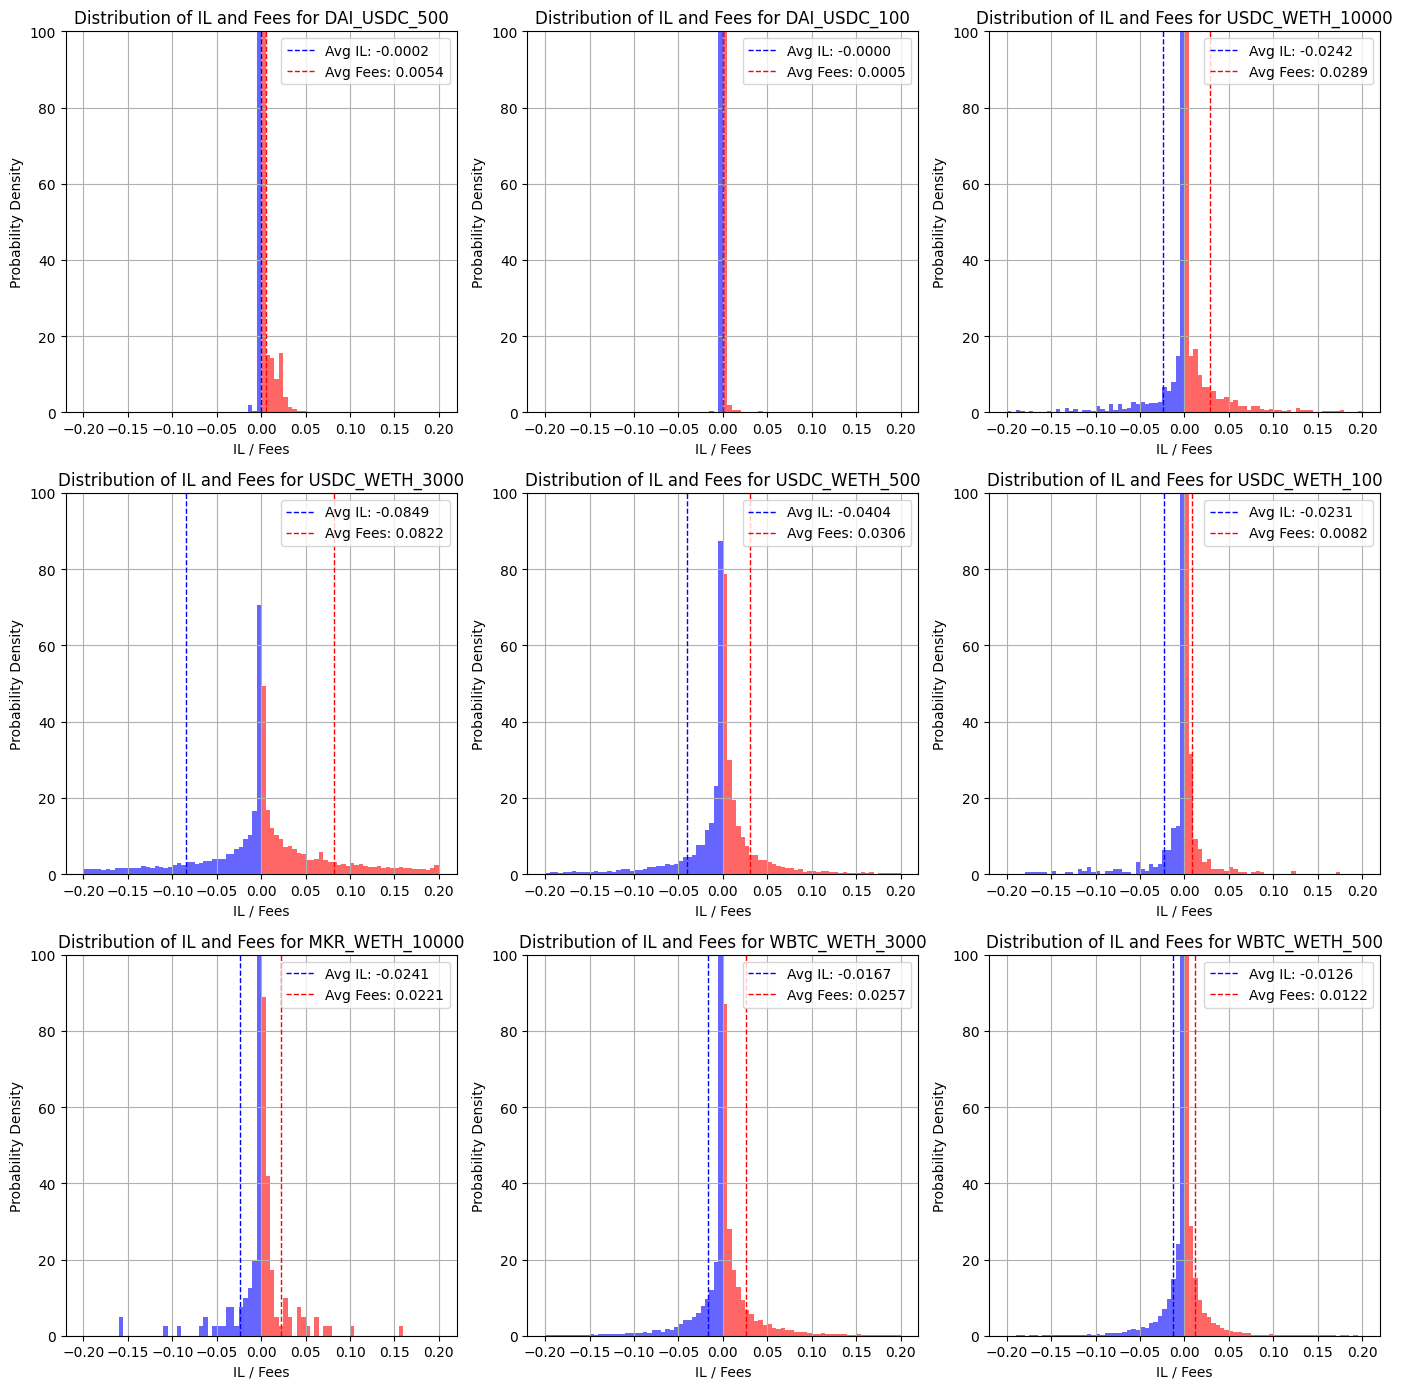

In [579]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
axes = axes.flatten()  # Flatten the 3x3 array of axes to simplify indexing

# Iterate through each DataFrame and its corresponding axis
for ax, (key, df) in zip(axes, pool_dataframes.items()):
    # Plot the histogram directly on the designated axis
    ax.hist(df['IL_formula'], bins=40, color='blue', alpha=0.6, range=(-0.2, 0), density=True)
    ax.hist(df['relativeFees'], bins=40, color='red', alpha=0.6, range=(0, 0.2), density=True)
    ax.set_title('Distribution of IL and Fees for ' + key)
    ax.set_xlabel('IL / Fees')
    ax.set_ylabel('Probability Density')
    ax.set_ylim(0,100)
    #add label with mean IL and fees
    ax.grid(True)

    avg_il = df['IL_formula'].mean()
    avg_fees = df['relativeFees'].mean()

    ax.axvline(avg_il, color='blue', linestyle='dashed', linewidth=1, label=f'Avg IL: {avg_il:.4f}')
    ax.axvline(avg_fees, color='red', linestyle='dashed', linewidth=1, label=f'Avg Fees: {avg_fees:.4f}')

    ax.legend(loc='upper right')

for i in range(len(pool_dataframes), 9):
    axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


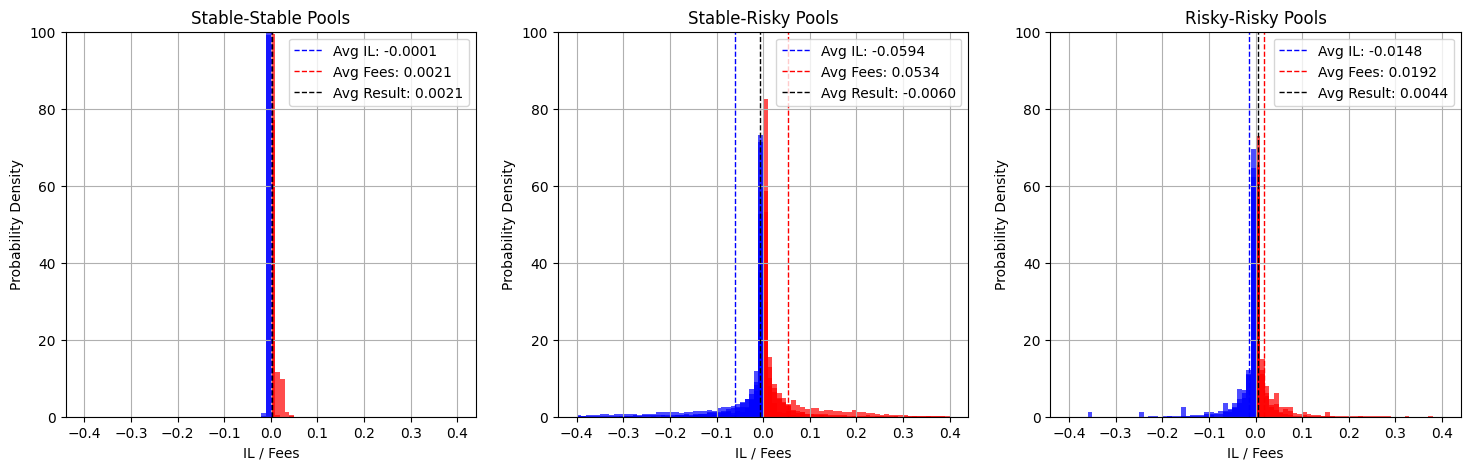

In [443]:
import matplotlib.pyplot as plt

# Define the pool categories
stable_stable_pools = ['DAI_USDC_500', 'DAI_USDC_100']
stable_risky_pools = ['USDC_WETH_10000', 'USDC_WETH_3000', 'USDC_WETH_500', 'USDC_WETH_100']
risky_risky_pools = ['MKR_WETH_10000', 'WBTC_WETH_3000', 'WBTC_WETH_500']

# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Function to plot histograms and average lines for a given set of pools
def plot_histograms(pools, ax, title):
    all_il = []
    all_fees = []
    
    for key in pools:
        df = pool_dataframes[key]
        ax.hist(df['IL_formula'], bins=40, color='blue', alpha=0.6, range=(-0.4, 0), density=True)
        ax.hist(df['relativeFees'], bins=40, color='red', alpha=0.6, range=(0, 0.4), density=True)
        ax.set_ylim(0,100)
        all_il.extend(df['IL_formula'])
        all_fees.extend(df['relativeFees'])
    
    avg_il = sum(all_il) / len(all_il)
    avg_fees = sum(all_fees) / len(all_fees)
    result = avg_il + avg_fees
    
    ax.axvline(avg_il, color='blue', linestyle='dashed', linewidth=1, label=f'Avg IL: {avg_il:.4f}')
    ax.axvline(avg_fees, color='red', linestyle='dashed', linewidth=1, label=f'Avg Fees: {avg_fees:.4f}')
    ax.axvline(result, color='black', linestyle='dashed', linewidth=1, label=f'Avg Result: {result:.4f}')
    
    ax.set_title(title)
    ax.set_xlabel('IL / Fees')
    ax.set_ylabel('Probability Density')
    ax.legend(loc='upper right')
    ax.grid(True)

# Plot the histograms for each category
plot_histograms(stable_stable_pools, axes[0], 'Stable-Stable Pools')
plot_histograms(stable_risky_pools, axes[1], 'Stable-Risky Pools')
plot_histograms(risky_risky_pools, axes[2], 'Risky-Risky Pools')

plt.show()


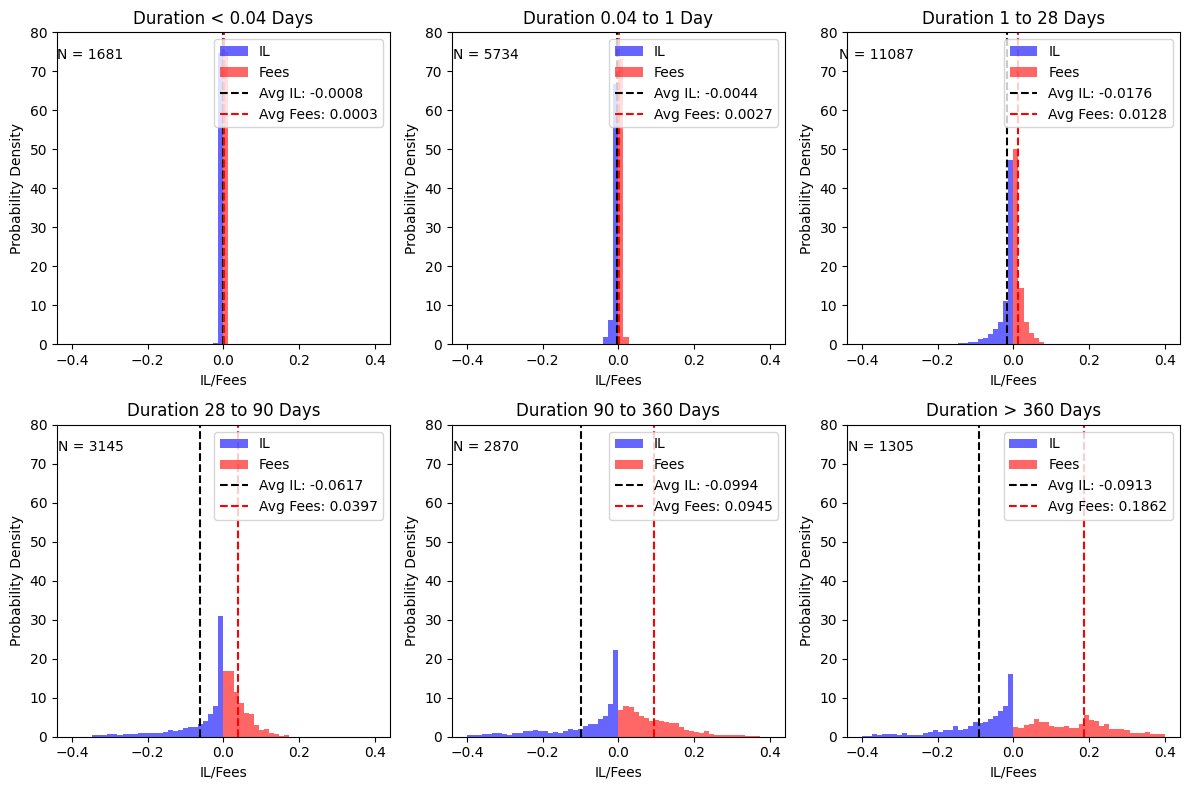

In [558]:
import matplotlib.pyplot as plt

# Calculate weighted duration in days
risky_combined_df['weightedDurationDays'] = risky_combined_df['weightedDurationSeconds'] / (3600 * 24)

# Function to remove outliers outside the 95% confidence interval
def remove_outliers(df, column):
    lower_bound = df[column].quantile(0.025)
    upper_bound = df[column].quantile(0.975)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter durations into groups and remove outliers
less_than_0_04_days = remove_outliers(risky_combined_df[risky_combined_df['weightedDurationDays'] < 0.04], 'IL_formula')
less_than_1_day = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 0.04) & (risky_combined_df['weightedDurationDays'] < 1)], 'IL_formula')
between_1_and_28_days = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 1) & (risky_combined_df['weightedDurationDays'] <= 28)], 'IL_formula')
between_28_and_90_days = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] > 28) & (risky_combined_df['weightedDurationDays'] <= 90)], 'IL_formula')
between_90_and_360_days = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] > 90) & (risky_combined_df['weightedDurationDays'] <= 360)], 'IL_formula')
more_than_360_days = remove_outliers(risky_combined_df[risky_combined_df['weightedDurationDays'] > 360], 'IL_formula')

# Remove outliers for the 'relativeFees' column as well
less_than_0_04_days = remove_outliers(less_than_0_04_days, 'relativeFees')
less_than_1_day = remove_outliers(less_than_1_day, 'relativeFees')
between_1_and_28_days = remove_outliers(between_1_and_28_days, 'relativeFees')
between_28_and_90_days = remove_outliers(between_28_and_90_days, 'relativeFees')
between_90_and_360_days = remove_outliers(between_90_and_360_days, 'relativeFees')
more_than_360_days = remove_outliers(more_than_360_days, 'relativeFees')

# Create a 2x3 subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Define a function to plot both histograms
def plot_histograms(ax, df, title, color_il, color_fees):
    range_il = (-0.4, 0)
    range_fees = (0, 0.4)
    # Plot IL_formula
    n, bins, patches = ax.hist(df['IL_formula'], bins=30, color=color_il, alpha=0.6, density=True, range=range_il, label='IL')
    # Plot relativeFees
    n2, bins2, patches2 = ax.hist(df['relativeFees'], bins=30, color=color_fees, alpha=0.6, density=True, range=range_fees, label='Fees')
    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('IL/Fees')
    ax.set_ylabel('Probability Density')

    # Get max value for y axis
    if max(max(n), max(n2)) > 40:
        ax.set_ylim(0, 80)
    else:
        ax.set_ylim(0, 80)

    # Add median line for IL_formula
    average_il = df['IL_formula'].mean()
    ax.axvline(x=average_il, color='k', linestyle='--', label=f'Avg IL: {average_il:.4f}')
    average_fees = df['relativeFees'].mean()
    ax.axvline(x=average_fees, color='r', linestyle='--', label=f'Avg Fees: {average_fees:.4f}')
    # Add legend and annotation
    ax.legend(loc='upper right')
    ax.annotate(f'N = {len(df)}', xy=(0.2, 0.95), xycoords='axes fraction', ha='right', va='top')

# Plot for durations < 0.04 days
plot_histograms(axes[0, 0], less_than_0_04_days, 'Duration < 0.04 Days', 'blue', 'red')

# Plot for durations 0.04 to 1 day
plot_histograms(axes[0, 1], less_than_1_day, 'Duration 0.04 to 1 Day', 'blue', 'red')

# Plot for durations 1 to 28 days
plot_histograms(axes[0, 2], between_1_and_28_days, 'Duration 1 to 28 Days', 'blue', 'red')

# Plot for durations 28 to 90 days
plot_histograms(axes[1, 0], between_28_and_90_days, 'Duration 28 to 90 Days', 'blue', 'red')

# Plot for durations 90 to 360 days
plot_histograms(axes[1, 1], between_90_and_360_days, 'Duration 90 to 360 Days', 'blue', 'red')

# Plot for durations > 360 days
plot_histograms(axes[1, 2], more_than_360_days, 'Duration > 360 Days', 'blue', 'red')

plt.tight_layout()
plt.show()


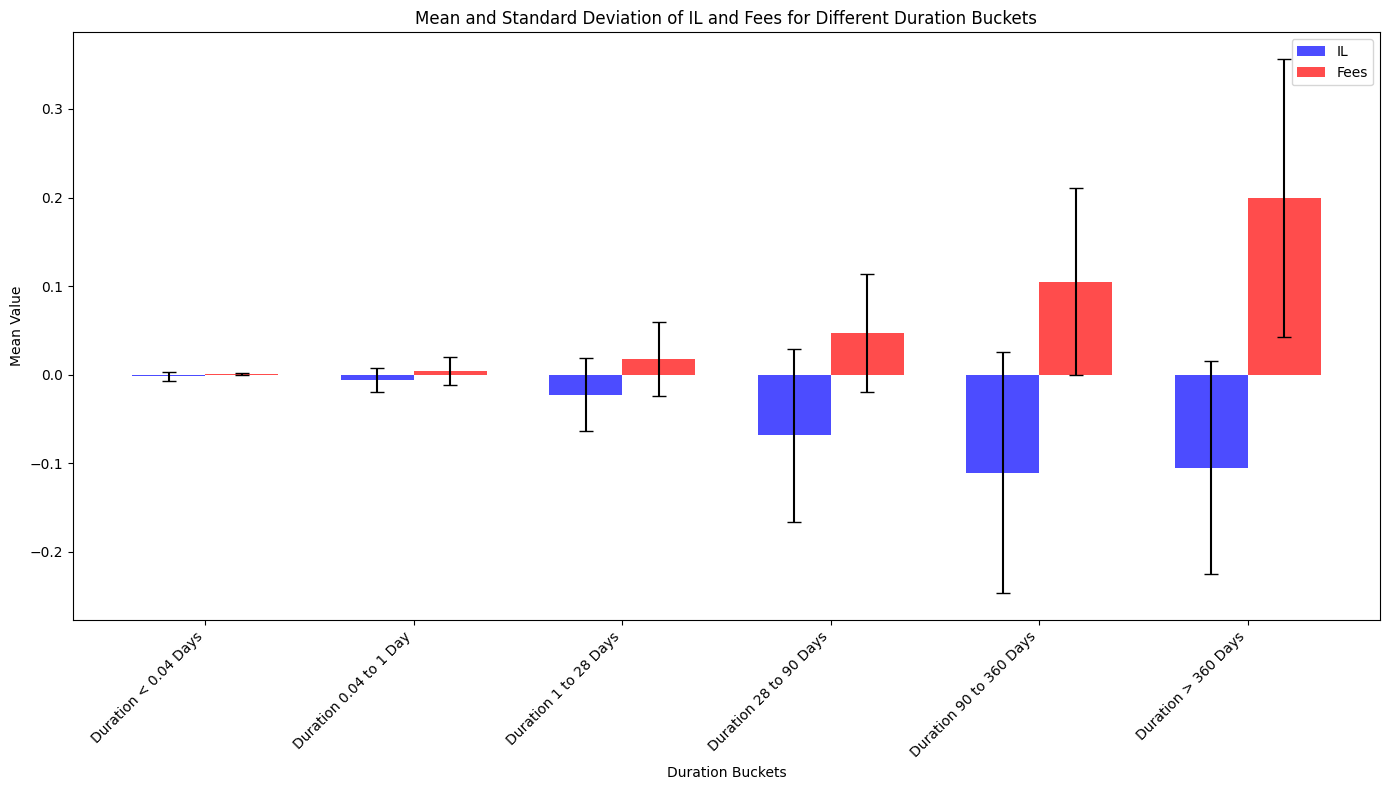

In [487]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate weighted duration in days
risky_combined_df['weightedDurationDays'] = risky_combined_df['weightedDurationSeconds'] / (3600 * 24)

# Filter durations into groups
duration_buckets = {
    'Duration < 0.04 Days': risky_combined_df[risky_combined_df['weightedDurationDays'] < 0.04],
    'Duration 0.04 to 1 Day': risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 0.04) & (risky_combined_df['weightedDurationDays'] < 1)],
    'Duration 1 to 28 Days': risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 1) & (risky_combined_df['weightedDurationDays'] <= 28)],
    'Duration 28 to 90 Days': risky_combined_df[(risky_combined_df['weightedDurationDays'] > 28) & (risky_combined_df['weightedDurationDays'] <= 90)],
    'Duration 90 to 360 Days': risky_combined_df[(risky_combined_df['weightedDurationDays'] > 90) & (risky_combined_df['weightedDurationDays'] <= 360)],
    'Duration > 360 Days': risky_combined_df[risky_combined_df['weightedDurationDays'] > 360]
}

# Calculate mean and standard deviation for IL and fees for each duration bucket
stats = {
    'Duration': [],
    'Mean IL': [],
    'Std IL': [],
    'Mean Fees': [],
    'Std Fees': []
}

for bucket, df in duration_buckets.items():
    stats['Duration'].append(bucket)
    stats['Mean IL'].append(df['IL_formula'].mean())
    stats['Std IL'].append(df['IL_formula'].std())
    stats['Mean Fees'].append(df['relativeFees'].mean())
    stats['Std Fees'].append(df['relativeFees'].std())

stats_df = pd.DataFrame(stats)

# Create bar chart with error bars
fig, ax = plt.subplots(figsize=(14, 8))

# Bar width
bar_width = 0.35

# Positions of the bars
index = range(len(stats_df))

# Plot IL
ax.bar(index, stats_df['Mean IL'], bar_width, yerr=stats_df['Std IL'], label='IL', color='b', alpha=0.6, capsize=5)

# Plot Fees next to IL
ax.bar([i + bar_width for i in index], stats_df['Mean Fees'], bar_width, yerr=stats_df['Std Fees'], label='Fees', color='r', alpha=0.6, capsize=5)

# Add titles and labels
ax.set_xlabel('Duration Buckets')
ax.set_ylabel('Mean Value')
ax.set_title('Mean and Standard Deviation of IL and Fees for Different Duration Buckets')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stats_df['Duration'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


C:\Users\thano\AppData\Local\Temp\ipykernel_45724\1360889960.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  mean_plot = sns.pointplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, dodge=0.4, join=False, palette=custom_palette2, markers='_', scale=2, ci=None)
C:\Users\thano\AppData\Local\Temp\ipykernel_45724\1360889960.py:31: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  mean_plot = sns.pointplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, dodge=0.4, join=False, palette=custom_palette2, markers='_', scale=2, ci=None)
C:\Users\thano\AppData\Local\Temp\ipykernel_45724\1360889960.py:31: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  mean

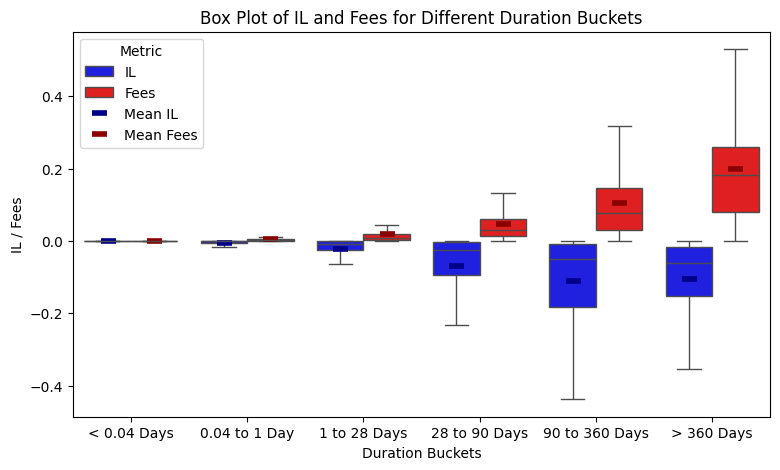

In [526]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy of the original dataframe to avoid modifying it
df_copy = risky_combined_df.copy()

# Calculate weighted duration in days
df_copy['weightedDurationDays'] = df_copy['weightedDurationSeconds'] / (3600 * 24)

# Add a new column for duration buckets
df_copy['Duration Bucket'] = pd.cut(
    df_copy['weightedDurationDays'],
    bins=[0, 0.04, 1, 28, 90, 360, float('inf')],
    labels=['< 0.04 Days', '0.04 to 1 Day', '1 to 28 Days', '28 to 90 Days', '90 to 360 Days', '> 360 Days']
)

# Melt the dataframe to long format for plotting
melted_df = pd.melt(df_copy, id_vars=['Duration Bucket'], value_vars=['IL_formula', 'relativeFees'],
                    var_name='Metric', value_name='Value')

# Define custom colors for IL and Fees
custom_palette = {'IL_formula': 'blue', 'relativeFees': 'red'}
custom_palette2 = {'IL_formula': 'darkblue', 'relativeFees': 'darkred'}

# Create box plots for IL and Fees in one plot with custom colors
plt.figure(figsize=(9, 5))
sns.boxplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, whis=1.5, showfliers=False, palette=custom_palette)

# Add mean points using pointplot
mean_plot = sns.pointplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, dodge=0.4, join=False, palette=custom_palette2, markers='_', scale=2, ci=None)

# Update the legend
handles, labels = mean_plot.get_legend_handles_labels()
labels = ['IL', 'Fees', 'Mean IL', 'Mean Fees']
plt.legend(handles=handles, labels=labels, title='Metric', loc='upper left')

plt.title('Box Plot of IL and Fees for Different Duration Buckets')
plt.xlabel('Duration Buckets')
plt.ylabel('IL / Fees')
plt.show()


C:\Users\thano\AppData\Local\Temp\ipykernel_45724\4059966497.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  mean_plot = sns.pointplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, dodge=0.4, join=False, palette=custom_palette2, markers='_', scale=2, ci=None)
C:\Users\thano\AppData\Local\Temp\ipykernel_45724\4059966497.py:31: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  mean_plot = sns.pointplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, dodge=0.4, join=False, palette=custom_palette2, markers='_', scale=2, ci=None)
C:\Users\thano\AppData\Local\Temp\ipykernel_45724\4059966497.py:31: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  mean

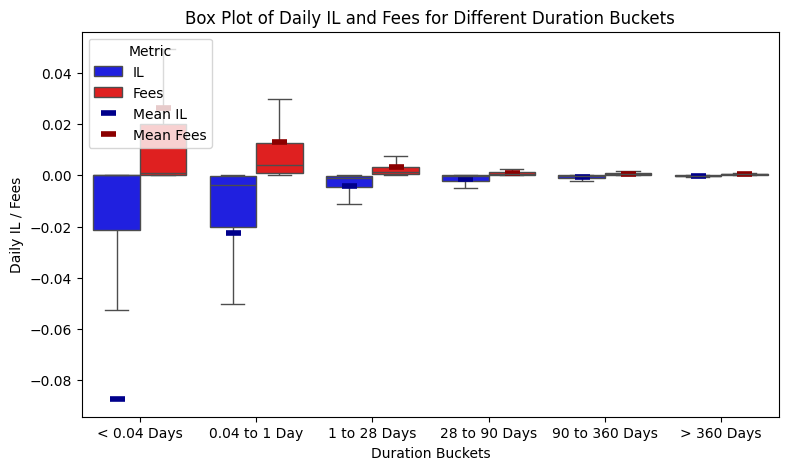

In [540]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy of the original dataframe to avoid modifying it
df_copy = risky_combined_df.copy()

# Calculate weighted duration in days
df_copy['weightedDurationDays'] = df_copy['weightedDurationSeconds'] / (3600 * 24)

# Add a new column for duration buckets
df_copy['Duration Bucket'] = pd.cut(
    df_copy['weightedDurationDays'],
    bins=[0, 0.04, 1, 28, 90, 360, float('inf')],
    labels=['< 0.04 Days', '0.04 to 1 Day', '1 to 28 Days', '28 to 90 Days', '90 to 360 Days', '> 360 Days']
)

# Melt the dataframe to long format for plotting
melted_df = pd.melt(df_copy, id_vars=['Duration Bucket'], value_vars=['daily_IL_formula', 'daily_Fees'],
                    var_name='Metric', value_name='Value')

# Define custom colors for daily_IL_formula and daily_Fees
custom_palette = {'daily_IL_formula': 'blue', 'daily_Fees': 'red'}
custom_palette2 = {'daily_IL_formula': 'darkblue', 'daily_Fees': 'darkred'}

# Create box plots for daily_IL_formula and daily_Fees in one plot with custom colors
plt.figure(figsize=(9, 5))
sns.boxplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, whis=1.5, showfliers=False, palette=custom_palette)

# Add mean points using pointplot
mean_plot = sns.pointplot(x='Duration Bucket', y='Value', hue='Metric', data=melted_df, dodge=0.4, join=False, palette=custom_palette2, markers='_', scale=2, ci=None)

# Update the legend
handles, labels = mean_plot.get_legend_handles_labels()
labels = ['IL', 'Fees', 'Mean IL', 'Mean Fees']
plt.legend(handles=handles, labels=labels, title='Metric', loc='upper left')

plt.title('Box Plot of Daily IL and Fees for Different Duration Buckets')
plt.xlabel('Duration Buckets')
plt.ylabel('Daily IL / Fees')
plt.show()


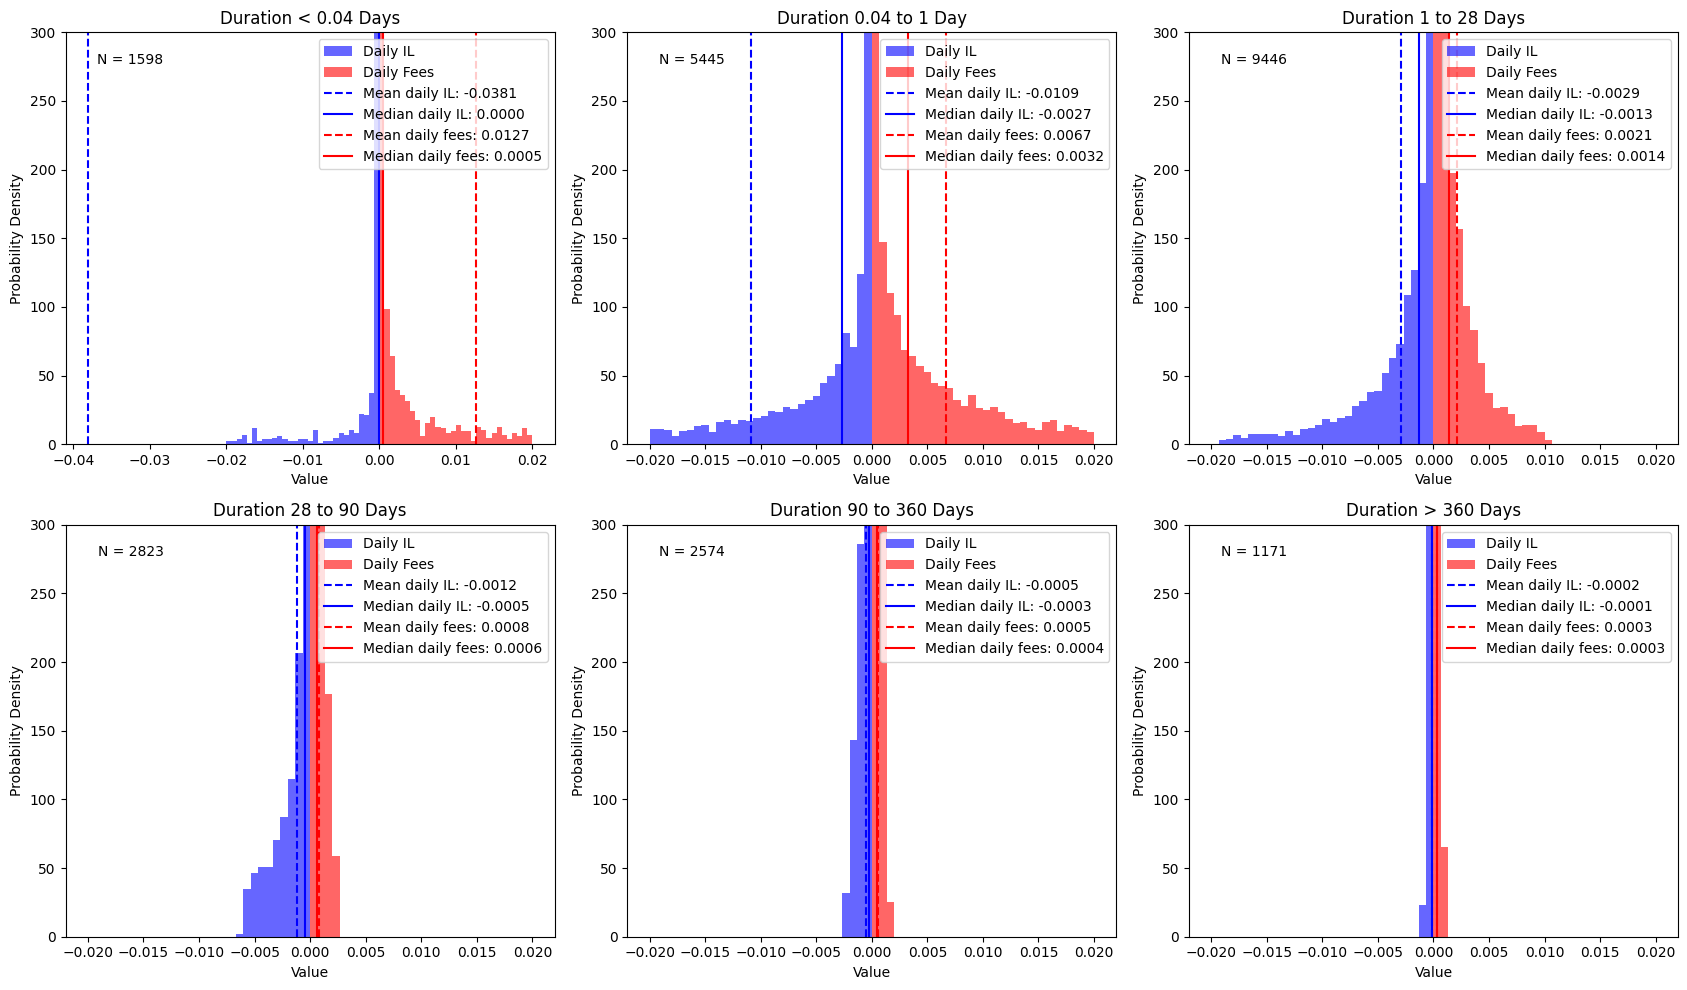

In [562]:
import matplotlib.pyplot as plt

# Calculate weighted duration in days
risky_combined_df['weightedDurationDays'] = risky_combined_df['weightedDurationSeconds'] / (3600 * 24)

# Function to remove outliers outside the 95% confidence interval
def remove_outliers(df, column):
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter durations into groups and remove outliers
less_than_0_04_days = remove_outliers(risky_combined_df[risky_combined_df['weightedDurationDays'] < 0.04], 'daily_IL_formula')
less_than_1_day = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 0.04) & (risky_combined_df['weightedDurationDays'] < 1)], 'daily_IL_formula')
between_1_and_28_days = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 1) & (risky_combined_df['weightedDurationDays'] <= 28)], 'daily_IL_formula')
between_28_and_90_days = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] > 28) & (risky_combined_df['weightedDurationDays'] <= 90)], 'daily_IL_formula')
between_90_and_360_days = remove_outliers(risky_combined_df[(risky_combined_df['weightedDurationDays'] > 90) & (risky_combined_df['weightedDurationDays'] <= 360)], 'daily_IL_formula')
more_than_360_days = remove_outliers(risky_combined_df[risky_combined_df['weightedDurationDays'] > 360], 'daily_IL_formula')

# Remove outliers for the 'daily_Fees' column as well
less_than_0_04_days = remove_outliers(less_than_0_04_days, 'daily_Fees')
less_than_1_day = remove_outliers(less_than_1_day, 'daily_Fees')
between_1_and_28_days = remove_outliers(between_1_and_28_days, 'daily_Fees')
between_28_and_90_days = remove_outliers(between_28_and_90_days, 'daily_Fees')
between_90_and_360_days = remove_outliers(between_90_and_360_days, 'daily_Fees')
more_than_360_days = remove_outliers(more_than_360_days, 'daily_Fees')

# Create a 2x3 subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 10))

# Define a function to plot both histograms
def plot_histograms(ax, df, title, color_il='blue', color_fees='red'):
    range_il = (-0.02, 0)
    range_fees = (0, 0.02)
    # Plot daily_IL_formula
    n, bins, patches = ax.hist(df['daily_IL_formula'], bins=30, color=color_il, alpha=0.6, density=True, range=range_il, label='Daily IL')
    # Plot daily_Fees
    n2, bins2, patches2 = ax.hist(df['daily_Fees'], bins=30, color=color_fees, alpha=0.6, density=True, range=range_fees, label='Daily Fees')
    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability Density')
    ax.set_ylim(0, 300)
    # Add mean and median lines for daily_IL_formula
    mean_il = df['daily_IL_formula'].mean()
    median_il = df['daily_IL_formula'].median()
    ax.axvline(x=mean_il, color='b', linestyle='--', label=f'Mean daily IL: {mean_il:.4f}')
    ax.axvline(x=median_il, color='b', linestyle='-', label=f'Median daily IL: {median_il:.4f}')
    # Add mean and median lines for daily_Fees
    mean_fees = df['daily_Fees'].mean()
    median_fees = df['daily_Fees'].median()
    ax.axvline(x=mean_fees, color='r', linestyle='--', label=f'Mean daily fees: {mean_fees:.4f}')
    ax.axvline(x=median_fees, color='r', linestyle='-', label=f'Median daily fees: {median_fees:.4f}')
    # Add legend and annotation
    ax.legend(loc='upper right')
    ax.annotate(f'N = {len(df)}', xy=(0.2, 0.95), xycoords='axes fraction', ha='right', va='top')

# Plot for durations < 0.04 days
plot_histograms(axes[0, 0], less_than_0_04_days, 'Duration < 0.04 Days')

# Plot for durations 0.04 to 1 day
plot_histograms(axes[0, 1], less_than_1_day, 'Duration 0.04 to 1 Day')

# Plot for durations 1 to 28 days
plot_histograms(axes[0, 2], between_1_and_28_days, 'Duration 1 to 28 Days')

# Plot for durations 28 to 90 days
plot_histograms(axes[1, 0], between_28_and_90_days, 'Duration 28 to 90 Days')

# Plot for durations 90 to 360 days
plot_histograms(axes[1, 1], between_90_and_360_days, 'Duration 90 to 360 Days')

# Plot for durations > 360 days
plot_histograms(axes[1, 2], more_than_360_days, 'Duration > 360 Days')

plt.tight_layout()
plt.show()


\begin{table}
\caption{Average Range Size per Pool}
\label{tab:avg_range_size}
\begin{tabular}{lr}
\toprule
Pool & Average Range Size \\
\midrule
DAI_USDC_500 & 0.0010 \\
DAI_USDC_100 & 0.0010 \\
USDC_WETH_10000 & 0.2059 \\
USDC_WETH_3000 & 0.4346 \\
USDC_WETH_500 & 0.0855 \\
USDC_WETH_100 & 0.0544 \\
MKR_WETH_10000 & 0.1397 \\
WBTC_WETH_3000 & 0.1440 \\
WBTC_WETH_500 & 0.0355 \\
\bottomrule
\end{tabular}
\end{table}



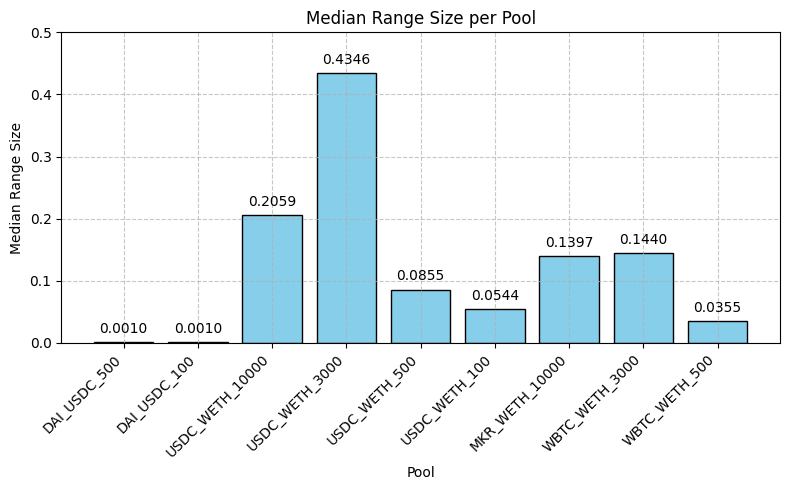

In [430]:
range_size_data = {}

for pool in pool_dataframes:
    pool_dataframes[pool]['range_size'] = 0.5 * ((pool_dataframes[pool]['price1_upper'] - pool_dataframes[pool]['price1_lower']) / (pool_dataframes[pool]['price_1'] / pool_dataframes[pool]['price_0']))
    range_size_data[pool] = pool_dataframes[pool]['range_size'].median()

# Create DataFrame for LaTeX output
range_size_df = pd.DataFrame(range_size_data.items(), columns=['Pool', 'Average Range Size'])

# Generate LaTeX table
latex_table = range_size_df.to_latex(index=False, float_format="%.4f", caption="Average Range Size per Pool", label="tab:avg_range_size")

print(latex_table)

# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    range_size_df['Pool'],
    range_size_df['Average Range Size'],
    color='skyblue',
    edgecolor='black'
)

ax.set_xlabel('Pool')
ax.set_ylabel('Median Range Size')
ax.set_title('Median Range Size per Pool')
ax.grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
ax.set_ylim(0, 0.5)

# Display values on top of bars
for i, v in enumerate(range_size_df['Average Range Size']):
    ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Range size for DAI_USDC_500:
     price0_upper  price0_lower
0        1.001404      0.999403
1        1.001404      0.999403
2        1.001404      0.999403
3        1.002405      0.998404
4        1.001404      1.000403
..            ...           ...
409      1.001404      0.999403
410      1.010456      0.990449
411      1.002405      1.000403
412      1.004412      0.995413
413      1.002405      0.999403

[409 rows x 2 columns]
Range size for DAI_USDC_100:
     price0_upper  price0_lower
0        1.000203      1.000003
1        1.000203      0.999703
2        1.000203      0.999703
3        1.000203      0.999703
4        1.000203      0.999703
..            ...           ...
811      1.000003      0.999803
812      1.000203      0.999803
813      1.000103      0.999903
814      1.000003      0.999903
815      1.009447      0.989459

[803 rows x 2 columns]
Range size for USDC_WETH_10000:
     price0_upper  price0_lower
0        0.000168      0.000077
1        0.000629      0.00015

count    4.570000e+02
mean     8.799306e+44
std      9.688534e+45
min      4.900364e-05
25%      5.673610e-03
50%      5.444683e-02
75%      1.358728e-01
max      1.433740e+47
Name: range_size, dtype: float64
count    8.200000e+01
mean     3.289820e+36
std      2.102250e+37
min      9.821524e-03
25%      6.165699e-02
50%      1.396535e-01
75%      4.399481e-01
max      1.470978e+38
Name: range_size, dtype: float64
count    6.772000e+03
mean     3.269574e+46
std      9.050438e+47
min      2.747953e-03
25%      6.334162e-02
50%      1.439998e-01
75%      3.271172e-01
max      3.055309e+49
Name: range_size, dtype: float64
count    6.409000e+03
mean     9.481115e+46
std      1.624217e+48
min      4.777182e-04
25%      1.078373e-02
50%      3.545391e-02
75%      1.004917e-01
max      3.243030e+49
Name: range_size, dtype: float64


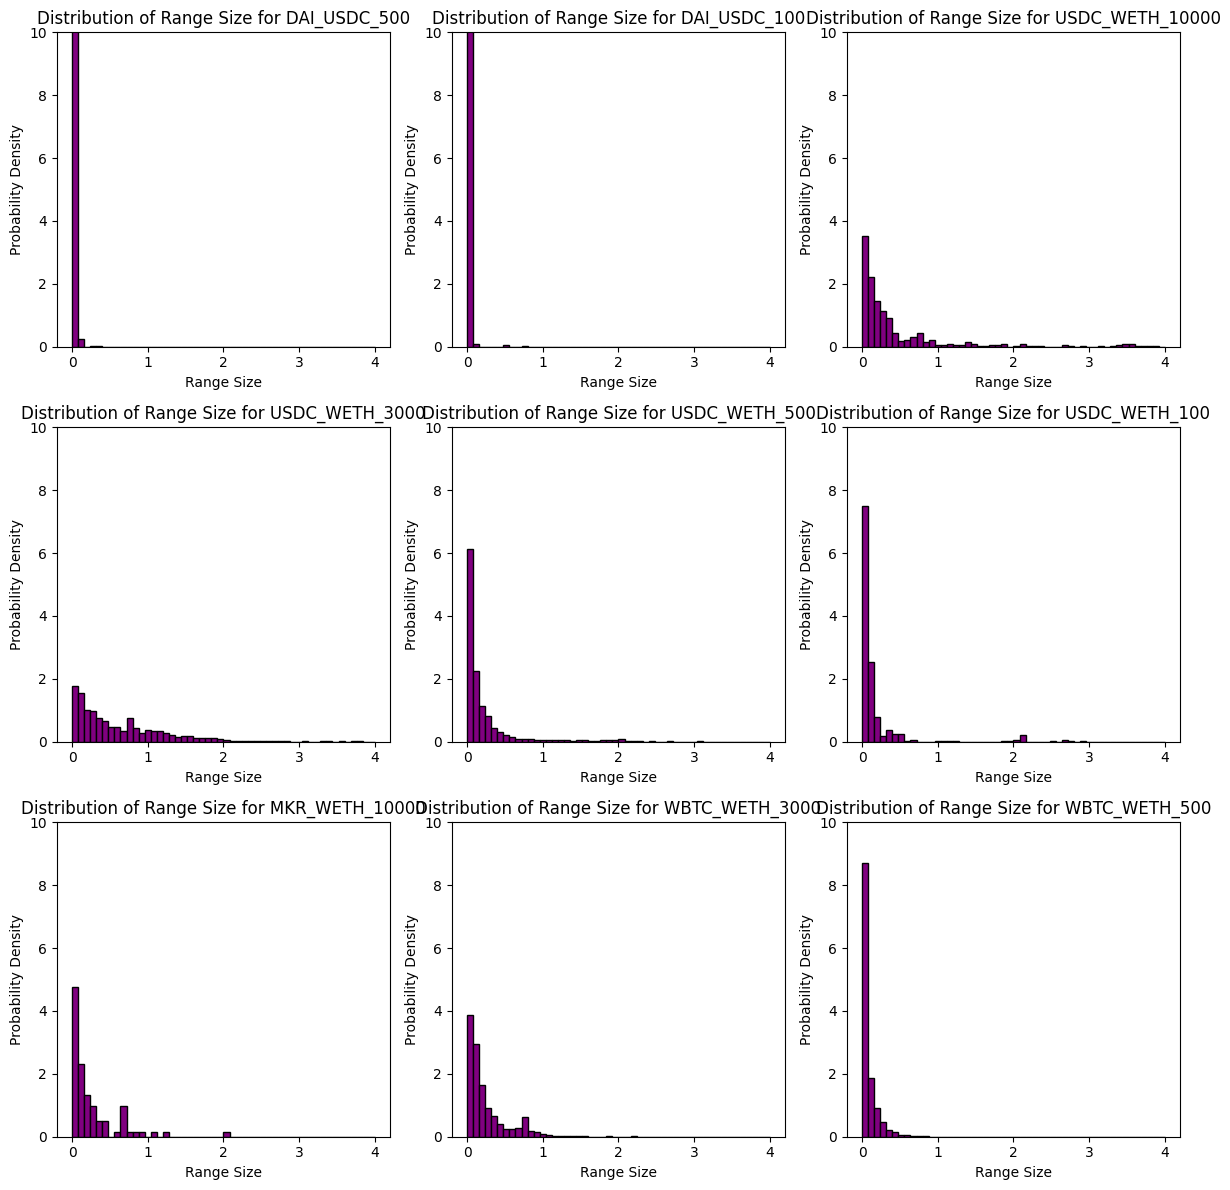

In [413]:
range_size_data = {}

for pool in pool_dataframes:
    pool_dataframes[pool].loc[:, 'range_size'] = 0.5 * ((pool_dataframes[pool]['price1_upper'] - pool_dataframes[pool]['price1_lower']) / (pool_dataframes[pool]['price_1']/pool_dataframes[pool]['price_0']))
    print(f"Range size for {pool}:")
    print(pool_dataframes[pool][['price0_upper', 'price0_lower']])
    range_size_data[pool] = pool_dataframes[pool]['range_size']

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, (pool, range_size) in enumerate(range_size_data.items()):
    axes[idx].hist(range_size, bins=50, color='purple', edgecolor='black', range = (0, 4), density=True)
    axes[idx].set_title(f'Distribution of Range Size for {pool}')
    axes[idx].set_xlabel('Range Size')
    axes[idx].set_ylabel('Probability Density')
    axes[idx].set_ylim(0, 10)
    print(range_size.describe())

plt.tight_layout()
plt.show()


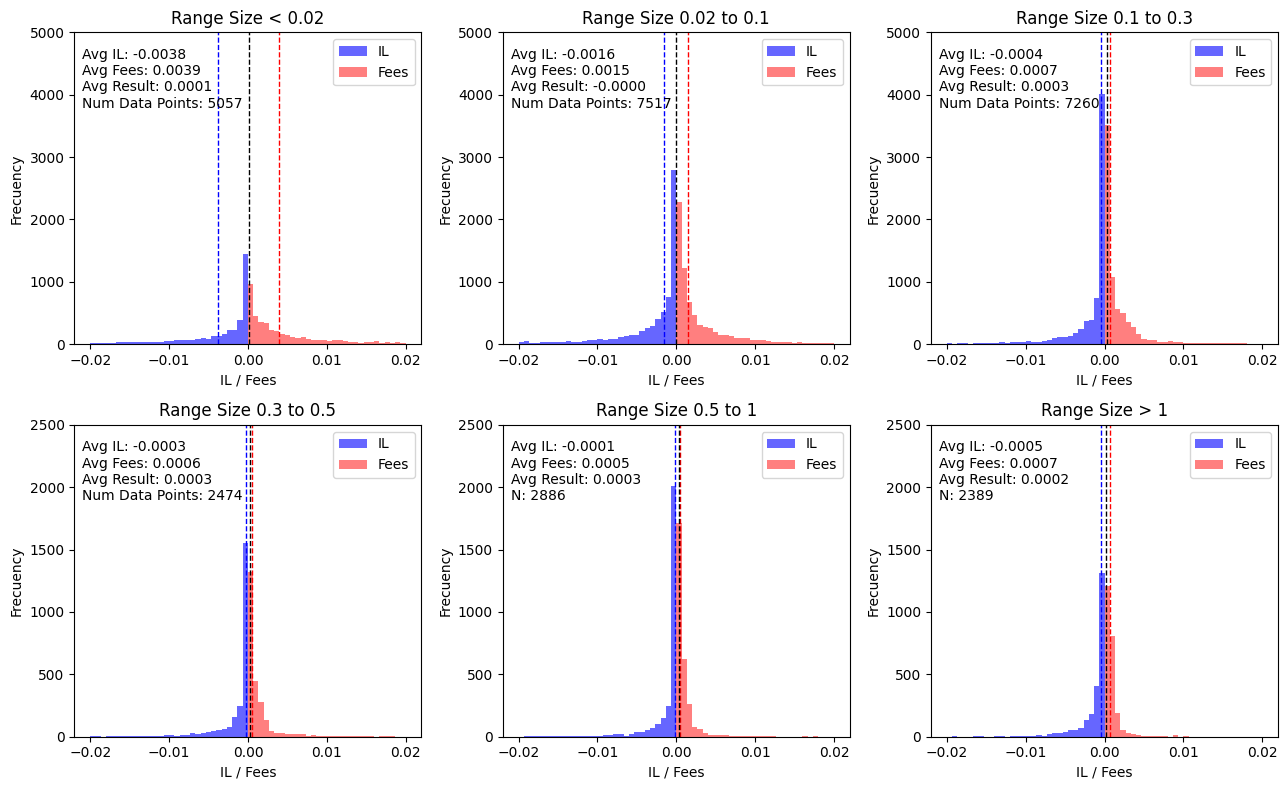

In [563]:
risky_combined_df['range_size'] = 0.5*((risky_combined_df['price1_upper'] - risky_combined_df['price1_lower']) / (risky_combined_df['price_1'] / risky_combined_df['price_0']))

# Define new buckets
less_than_0_05 = risky_combined_df[risky_combined_df['range_size'] < 0.02]
between_0_05_and_0_2 = risky_combined_df[(risky_combined_df['range_size'] >= 0.02) & (risky_combined_df['range_size'] < 0.1)]
between_0_2_and_1 = risky_combined_df[(risky_combined_df['range_size'] >= 0.1) & (risky_combined_df['range_size'] < 0.3)]
between_1_and_3 = risky_combined_df[(risky_combined_df['range_size'] >= 0.3) & (risky_combined_df['range_size'] < 0.5)]
between_3_and_5 = risky_combined_df[(risky_combined_df['range_size'] >= 0.5) & (risky_combined_df['range_size'] < 1)]
more_than_5 = risky_combined_df[risky_combined_df['range_size'] >= 1]

# Calculate the average IL and fees for each range_size bucket
avg_il_less_than_0_05 = less_than_0_05['daily_IL_formula'].median()
avg_il_between_0_05_and_0_2 = between_0_05_and_0_2['daily_IL_formula'].median()
avg_il_between_0_2_and_1 = between_0_2_and_1['daily_IL_formula'].median()
avg_il_between_1_and_3 = between_1_and_3['daily_IL_formula'].median()
avg_il_between_3_and_5 = between_3_and_5['daily_IL_formula'].median()
avg_il_more_than_5 = more_than_5['daily_IL_formula'].median()

avg_fees_less_than_0_05 = less_than_0_05['daily_Fees'].median()
avg_fees_between_0_05_and_0_2 = between_0_05_and_0_2['daily_Fees'].median()
avg_fees_between_0_2_and_1 = between_0_2_and_1['daily_Fees'].median()
avg_fees_between_1_and_3 = between_1_and_3['daily_Fees'].median()
avg_fees_between_3_and_5 = between_3_and_5['daily_Fees'].median()
avg_fees_more_than_5 = more_than_5['daily_Fees'].median()

avg_overall_0_05 = avg_il_less_than_0_05 + avg_fees_less_than_0_05
avg_overall_0_05_0_2 = avg_il_between_0_05_and_0_2 + avg_fees_between_0_05_and_0_2
avg_overall_0_2_1 = avg_il_between_0_2_and_1 + avg_fees_between_0_2_and_1
avg_overall_1_3 = avg_il_between_1_and_3 + avg_fees_between_1_and_3
avg_overall_3_5 = avg_il_between_3_and_5 + avg_fees_between_3_and_5
avg_overall_more_than_5 = avg_il_more_than_5 + avg_fees_more_than_5

# Plotting the distribution of IL_final and fees for each range_size bucket
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))

range_il = (-0.02, 0)
range_fees = (0, 0.02)

#set y lim for plots
axes[0, 0].set_ylim(0, 5000)
axes[0, 1].set_ylim(0, 5000)
axes[0, 2].set_ylim(0, 5000)

axes[1, 0].set_ylim(0, 2500)
axes[1, 1].set_ylim(0, 2500)
axes[1, 2].set_ylim(0, 2500)

# Plot for range size < 0.05
axes[0, 0].hist(less_than_0_05['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[0, 0].hist(less_than_0_05['daily_Fees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[0, 0].set_title('Range Size < 0.02')
axes[0, 0].set_xlabel('IL / Fees')
axes[0, 0].set_ylabel('Frecuency')
axes[0, 0].axvline(avg_il_less_than_0_05, color='blue', linestyle='dashed', linewidth=1)
axes[0, 0].axvline(avg_fees_less_than_0_05, color='red', linestyle='dashed', linewidth=1)
axes[0, 0].axvline(avg_overall_0_05, color='black', linestyle='dashed', linewidth=1)
axes[0, 0].text(axes[0, 0].get_xlim()[0]+0.001, axes[0, 0].get_ylim()[1]*0.95, f'Avg IL: {avg_il_less_than_0_05:.4f}\nAvg Fees: {avg_fees_less_than_0_05:.4f}\nAvg Result: {avg_overall_0_05:.4f}\nNum Data Points: {len(less_than_0_05)}', color='black', va='top')
axes[0, 0].legend(loc='upper right')

# Plot for range size 0.05 to 0.2
axes[0, 1].hist(between_0_05_and_0_2['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[0, 1].hist(between_0_05_and_0_2['daily_Fees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[0, 1].set_title('Range Size 0.02 to 0.1')
axes[0, 1].set_xlabel('IL / Fees')
axes[0, 1].set_ylabel('Frecuency')
axes[0, 1].axvline(avg_il_between_0_05_and_0_2, color='blue', linestyle='dashed', linewidth=1)
axes[0, 1].axvline(avg_fees_between_0_05_and_0_2, color='red', linestyle='dashed', linewidth=1)
axes[0, 1].axvline(avg_overall_0_05_0_2, color='black', linestyle='dashed', linewidth=1)
axes[0, 1].text(axes[0, 1].get_xlim()[0]+0.001, axes[0, 1].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_0_05_and_0_2:.4f}\nAvg Fees: {avg_fees_between_0_05_and_0_2:.4f}\nAvg Result: {avg_overall_0_05_0_2:.4f}\nNum Data Points: {len(between_0_05_and_0_2)}', color='black', va='top')
axes[0, 1].legend(loc='upper right')

# Plot for range size 0.2 to 1
axes[0, 2].hist(between_0_2_and_1['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[0, 2].hist(between_0_2_and_1['daily_Fees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[0, 2].set_title('Range Size 0.1 to 0.3')
axes[0, 2].set_xlabel('IL / Fees')
axes[0, 2].set_ylabel('Frecuency')
axes[0, 2].axvline(avg_il_between_0_2_and_1, color='blue', linestyle='dashed', linewidth=1)
axes[0, 2].axvline(avg_fees_between_0_2_and_1, color='red', linestyle='dashed', linewidth=1)
axes[0, 2].axvline(avg_overall_0_2_1, color='black', linestyle='dashed', linewidth=1)
axes[0, 2].text(axes[0, 2].get_xlim()[0]+0.001, axes[0, 2].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_0_2_and_1:.4f}\nAvg Fees: {avg_fees_between_0_2_and_1:.4f}\nAvg Result: {avg_overall_0_2_1:.4f}\nNum Data Points: {len(between_0_2_and_1)}', color='black', va='top')
axes[0, 2].legend(loc='upper right')

# Plot for range size 1 to 3
axes[1, 0].hist(between_1_and_3['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[1, 0].hist(between_1_and_3['daily_Fees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[1, 0].set_title('Range Size 0.3 to 0.5')
axes[1, 0].set_xlabel('IL / Fees')
axes[1, 0].set_ylabel('Frecuency')
axes[1, 0].axvline(avg_il_between_1_and_3, color='blue', linestyle='dashed', linewidth=1)
axes[1, 0].axvline(avg_fees_between_1_and_3, color='red', linestyle='dashed', linewidth=1)
axes[1, 0].axvline(avg_overall_1_3, color='black', linestyle='dashed', linewidth=1)
axes[1, 0].text(axes[1, 0].get_xlim()[0]+0.001, axes[1, 0].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_1_and_3:.4f}\nAvg Fees: {avg_fees_between_1_and_3:.4f}\nAvg Result: {avg_overall_1_3:.4f}\nNum Data Points: {len(between_1_and_3)}', color='black', va='top')
axes[1, 0].legend(loc='upper right')

# Plot for range size 3 to 5
axes[1, 1].hist(between_3_and_5['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[1, 1].hist(between_3_and_5['daily_Fees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[1, 1].set_title('Range Size 0.5 to 1')
axes[1, 1].set_xlabel('IL / Fees')
axes[1, 1].set_ylabel('Frecuency')
axes[1, 1].axvline(avg_il_between_3_and_5, color='blue', linestyle='dashed', linewidth=1)
axes[1, 1].axvline(avg_fees_between_3_and_5, color='red', linestyle='dashed', linewidth=1)
axes[1, 1].axvline(avg_overall_3_5, color='black', linestyle='dashed', linewidth=1)
axes[1, 1].text(axes[1, 1].get_xlim()[0]+0.001, axes[1, 1].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_3_and_5:.4f}\nAvg Fees: {avg_fees_between_3_and_5:.4f}\nAvg Result: {avg_overall_3_5:.4f}\nN: {len(between_3_and_5)}', color='black', va='top')
axes[1, 1].legend(loc='upper right')

# Plot for range size > 5
axes[1, 2].hist(more_than_5['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[1, 2].hist(more_than_5['daily_Fees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[1, 2].set_title('Range Size > 1')
axes[1, 2].set_xlabel('IL / Fees')
axes[1, 2].set_ylabel('Frecuency')
axes[1, 2].axvline(avg_il_more_than_5, color='blue', linestyle='dashed', linewidth=1)
axes[1, 2].axvline(avg_fees_more_than_5, color='red', linestyle='dashed', linewidth=1)
axes[1, 2].axvline(avg_overall_more_than_5, color='black', linestyle='dashed', linewidth=1)
axes[1, 2].text(axes[1, 2].get_xlim()[0]+0.001, axes[1, 2].get_ylim()[1]*0.95, f'Avg IL: {avg_il_more_than_5:.4f}\nAvg Fees: {avg_fees_more_than_5:.4f}\nAvg Result: {avg_overall_more_than_5:.4f}\nN: {len(more_than_5)}', color='black', va='top')
axes[1, 2].legend(loc='upper right')

plt.tight_layout()
plt.show()


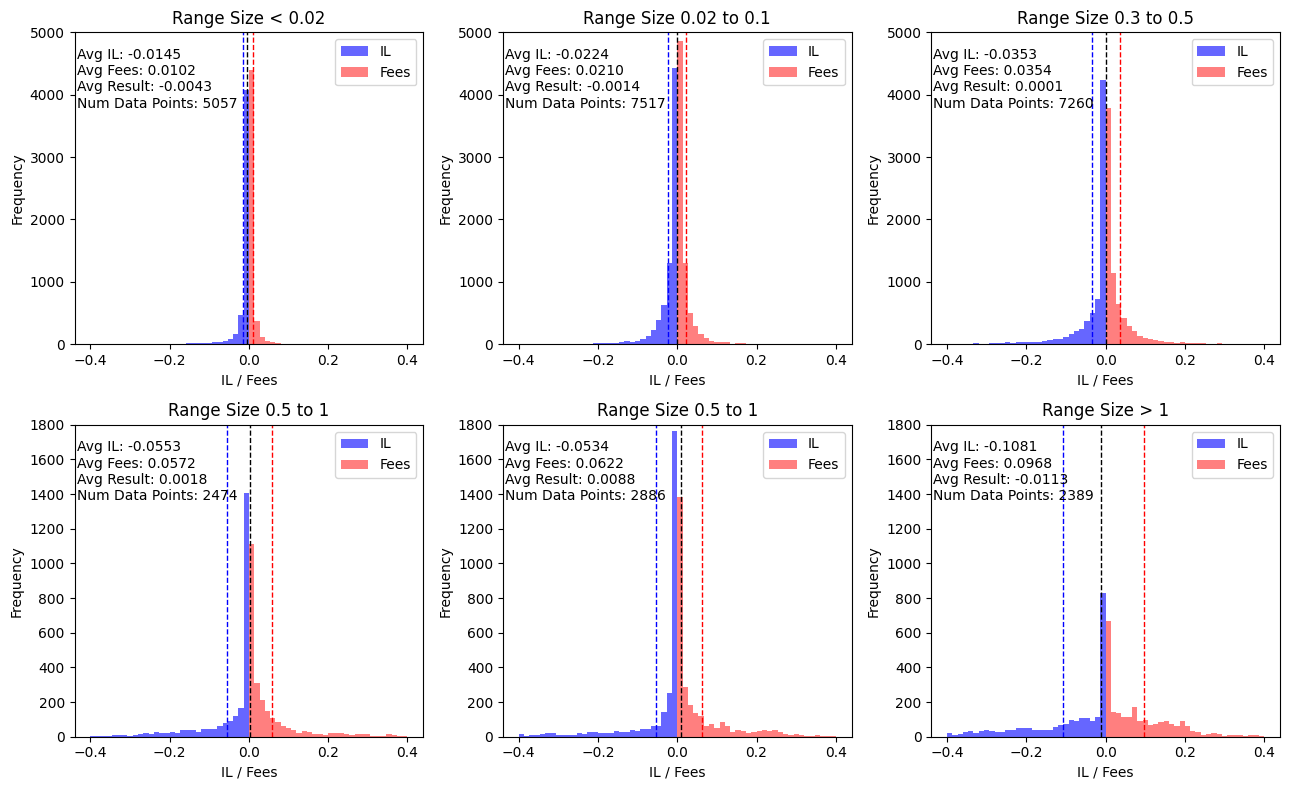

In [564]:
risky_combined_df['range_size'] = 0.5*((risky_combined_df['price1_upper'] - risky_combined_df['price1_lower']) / (risky_combined_df['price_1'] / risky_combined_df['price_0']))

# Define new buckets
less_than_0_05 = risky_combined_df[risky_combined_df['range_size'] < 0.02]
between_0_05_and_0_2 = risky_combined_df[(risky_combined_df['range_size'] >= 0.02) & (risky_combined_df['range_size'] < 0.1)]
between_0_2_and_1 = risky_combined_df[(risky_combined_df['range_size'] >= 0.1) & (risky_combined_df['range_size'] < 0.3)]
between_1_and_3 = risky_combined_df[(risky_combined_df['range_size'] >= 0.3) & (risky_combined_df['range_size'] < 0.5)]
between_3_and_5 = risky_combined_df[(risky_combined_df['range_size'] >= 0.5) & (risky_combined_df['range_size'] < 1)]
more_than_5 = risky_combined_df[risky_combined_df['range_size'] >= 1]

# Calculate the average IL and fees for each range_size bucket
avg_il_less_than_0_05 = less_than_0_05['IL_formula'].mean()
avg_il_between_0_05_and_0_2 = between_0_05_and_0_2['IL_formula'].mean()
avg_il_between_0_2_and_1 = between_0_2_and_1['IL_formula'].mean()
avg_il_between_1_and_3 = between_1_and_3['IL_formula'].mean()
avg_il_between_3_and_5 = between_3_and_5['IL_formula'].mean()
avg_il_more_than_5 = more_than_5['IL_formula'].mean()

avg_fees_less_than_0_05 = less_than_0_05['relativeFees'].mean()
avg_fees_between_0_05_and_0_2 = between_0_05_and_0_2['relativeFees'].mean()
avg_fees_between_0_2_and_1 = between_0_2_and_1['relativeFees'].mean()
avg_fees_between_1_and_3 = between_1_and_3['relativeFees'].mean()
avg_fees_between_3_and_5 = between_3_and_5['relativeFees'].mean()
avg_fees_more_than_5 = more_than_5['relativeFees'].mean()

avg_overall_0_05 = avg_il_less_than_0_05 + avg_fees_less_than_0_05
avg_overall_0_05_0_2 = avg_il_between_0_05_and_0_2 + avg_fees_between_0_05_and_0_2
avg_overall_0_2_1 = avg_il_between_0_2_and_1 + avg_fees_between_0_2_and_1
avg_overall_1_3 = avg_il_between_1_and_3 + avg_fees_between_1_and_3
avg_overall_3_5 = avg_il_between_3_and_5 + avg_fees_between_3_and_5
avg_overall_more_than_5 = avg_il_more_than_5 + avg_fees_more_than_5

# Plotting the distribution of IL_final and fees for each range_size bucket
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))

range_il = (-0.4, 0)
range_fees = (0, 0.4)

# Plot for range size < 0.05
axes[0, 0].hist(less_than_0_05['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[0, 0].hist(less_than_0_05['relativeFees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[0, 0].set_title('Range Size < 0.02')
axes[0, 0].set_xlabel('IL / Fees')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(avg_il_less_than_0_05, color='blue', linestyle='dashed', linewidth=1)
axes[0, 0].axvline(avg_fees_less_than_0_05, color='red', linestyle='dashed', linewidth=1)
axes[0, 0].axvline(avg_overall_0_05, color='black', linestyle='dashed', linewidth=1)
axes[0, 0].set_ylim(0, 5000)
axes[0, 0].text(axes[0, 0].get_xlim()[0]+0.005, axes[0, 0].get_ylim()[1]*0.95, f'Avg IL: {avg_il_less_than_0_05:.4f}\nAvg Fees: {avg_fees_less_than_0_05:.4f}\nAvg Result: {avg_overall_0_05:.4f}\nNum Data Points: {len(less_than_0_05)}', color='black', va='top')
axes[0, 0].legend(loc='upper right')
#set y limit

# Plot for range size 0.05 to 0.2
axes[0, 1].hist(between_0_05_and_0_2['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[0, 1].hist(between_0_05_and_0_2['relativeFees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[0, 1].set_title('Range Size 0.02 to 0.1')
axes[0, 1].set_xlabel('IL / Fees')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(avg_il_between_0_05_and_0_2, color='blue', linestyle='dashed', linewidth=1)
axes[0, 1].axvline(avg_fees_between_0_05_and_0_2, color='red', linestyle='dashed', linewidth=1)
axes[0, 1].axvline(avg_overall_0_05_0_2, color='black', linestyle='dashed', linewidth=1)
axes[0, 1].set_ylim(0, 5000)
axes[0, 1].text(axes[0, 1].get_xlim()[0]+0.005, axes[0, 1].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_0_05_and_0_2:.4f}\nAvg Fees: {avg_fees_between_0_05_and_0_2:.4f}\nAvg Result: {avg_overall_0_05_0_2:.4f}\nNum Data Points: {len(between_0_05_and_0_2)}', color='black', va='top')
axes[0, 1].legend(loc='upper right')

# Plot for range size 0.2 to 1
axes[0, 2].hist(between_0_2_and_1['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[0, 2].hist(between_0_2_and_1['relativeFees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[0, 2].set_title('Range Size 0.3 to 0.5')
axes[0, 2].set_xlabel('IL / Fees')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(avg_il_between_0_2_and_1, color='blue', linestyle='dashed', linewidth=1)
axes[0, 2].axvline(avg_fees_between_0_2_and_1, color='red', linestyle='dashed', linewidth=1)
axes[0, 2].axvline(avg_overall_0_2_1, color='black', linestyle='dashed', linewidth=1)
axes[0, 2].set_ylim(0, 5000)
axes[0, 2].text(axes[0, 2].get_xlim()[0]+0.005, axes[0, 2].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_0_2_and_1:.4f}\nAvg Fees: {avg_fees_between_0_2_and_1:.4f}\nAvg Result: {avg_overall_0_2_1:.4f}\nNum Data Points: {len(between_0_2_and_1)}', color='black', va='top')
axes[0, 2].legend(loc='upper right')

# Plot for range size 1 to 3
axes[1, 0].hist(between_1_and_3['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[1, 0].hist(between_1_and_3['relativeFees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[1, 0].set_title('Range Size 0.5 to 1')
axes[1, 0].set_xlabel('IL / Fees')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(avg_il_between_1_and_3, color='blue', linestyle='dashed', linewidth=1)
axes[1, 0].axvline(avg_fees_between_1_and_3, color='red', linestyle='dashed', linewidth=1)
axes[1, 0].axvline(avg_overall_1_3, color='black', linestyle='dashed', linewidth=1)
axes[1, 0].set_ylim(0, 1800)
axes[1, 0].text(axes[1, 0].get_xlim()[0]+0.005, axes[1, 0].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_1_and_3:.4f}\nAvg Fees: {avg_fees_between_1_and_3:.4f}\nAvg Result: {avg_overall_1_3:.4f}\nNum Data Points: {len(between_1_and_3)}', color='black', va='top')
axes[1, 0].legend(loc='upper right')

# Plot for range size 3 to 5
axes[1, 1].hist(between_3_and_5['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[1, 1].hist(between_3_and_5['relativeFees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[1, 1].set_title('Range Size 0.5 to 1')
axes[1, 1].set_xlabel('IL / Fees')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(avg_il_between_3_and_5, color='blue', linestyle='dashed', linewidth=1)
axes[1, 1].axvline(avg_fees_between_3_and_5, color='red', linestyle='dashed', linewidth=1)
axes[1, 1].axvline(avg_overall_3_5, color='black', linestyle='dashed', linewidth=1)
axes[1, 1].set_ylim(0, 1800)
axes[1, 1].text(axes[1, 1].get_xlim()[0]+0.005, axes[1, 1].get_ylim()[1]*0.95, f'Avg IL: {avg_il_between_3_and_5:.4f}\nAvg Fees: {avg_fees_between_3_and_5:.4f}\nAvg Result: {avg_overall_3_5:.4f}\nNum Data Points: {len(between_3_and_5)}', color='black', va='top')
axes[1, 1].legend(loc='upper right')

# Plot for range size > 5
axes[1, 2].hist(more_than_5['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=range_il, label='IL')
axes[1, 2].hist(more_than_5['relativeFees'], bins=30, color='red', alpha=0.5, density=False, range=range_fees, label='Fees')
axes[1, 2].set_title('Range Size > 1')
axes[1, 2].set_xlabel('IL / Fees')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(avg_il_more_than_5, color='blue', linestyle='dashed', linewidth=1)
axes[1, 2].axvline(avg_fees_more_than_5, color='red', linestyle='dashed', linewidth=1)
axes[1, 2].axvline(avg_overall_more_than_5, color='black', linestyle='dashed', linewidth=1)
axes[1, 2].set_ylim(0, 1800)
axes[1, 2].text(axes[1, 2].get_xlim()[0]+0.005, axes[1, 2].get_ylim()[1]*0.95, f'Avg IL: {avg_il_more_than_5:.4f}\nAvg Fees: {avg_fees_more_than_5:.4f}\nAvg Result: {avg_overall_more_than_5:.4f}\nNum Data Points: {len(more_than_5)}', color='black', va='top')
axes[1, 2].legend(loc='upper right')

plt.tight_layout()
plt.show()


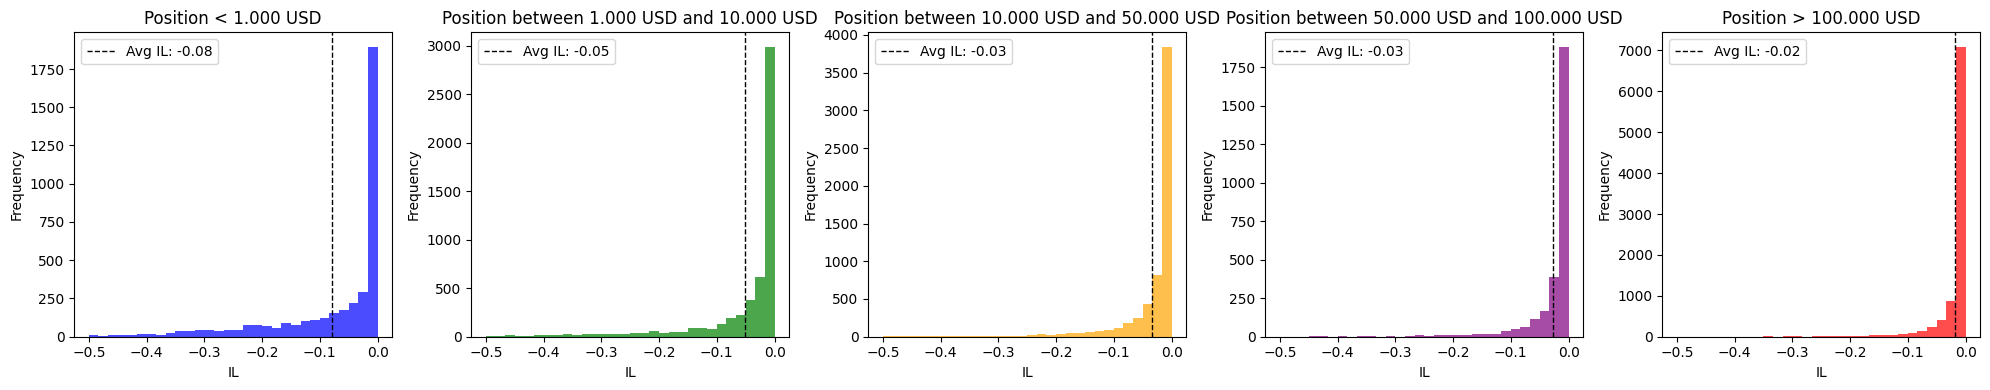

In [474]:

# Define the data subsets
less_than_1k = risky_combined_df[risky_combined_df['event_amountUSD'] < 1000]
between_1k_and_10k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 1000) & (risky_combined_df['event_amountUSD'] < 10000)]
between_10k_and_50k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 10000) & (risky_combined_df['event_amountUSD'] < 50000)]
between_50k_and_100k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 50000) & (risky_combined_df['event_amountUSD'] <= 100000)]
more_than_100k = risky_combined_df[risky_combined_df['event_amountUSD'] > 100000]

# Calculate the average IL for each group
avg_il_less_than_1k = less_than_1k['IL_formula'].mean()
avg_il_between_1k_and_10k = between_1k_and_10k['IL_formula'].mean()
avg_il_between_10k_and_50k = between_10k_and_50k['IL_formula'].mean()
avg_il_between_50k_and_100k = between_50k_and_100k['IL_formula'].mean()
avg_il_more_than_100k = more_than_100k['IL_formula'].mean()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Plot histogram for less_than_1k
axes[0].hist(less_than_1k['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=(-0.5, 0))
axes[0].set_title('Position < 1.000 USD')
axes[0].set_xlabel('IL')
axes[0].set_ylabel('Frequency')
axes[0].axvline(avg_il_less_than_1k, color='black', linestyle='dashed', linewidth=1, label= f'Avg IL: {avg_il_less_than_1k:.2f}')
axes[0].legend()

# Plot histogram for between_1k_and_10k
axes[1].hist(between_1k_and_10k['IL_formula'], bins=30, color='green', alpha=0.6, density=False, range=(-0.5, 0))
axes[1].set_title('Position between 1.000 USD and 10.000 USD')
axes[1].set_xlabel('IL')
axes[1].set_ylabel('Frequency')
axes[1].axvline(avg_il_between_1k_and_10k, color='black', linestyle='dashed', linewidth=1, label= f'Avg IL: {avg_il_between_1k_and_10k:.2f}')
axes[1].legend()

# Plot histogram for between_10k_and_50k
axes[2].hist(between_10k_and_50k['IL_formula'], bins=30, color='orange', alpha=0.6, density=False, range=(-0.5, 0))
axes[2].set_title('Position between 10.000 USD and 50.000 USD')
axes[2].set_xlabel('IL')
axes[2].set_ylabel('Frequency')
axes[2].axvline(avg_il_between_10k_and_50k, color='black', linestyle='dashed', linewidth=1, label= f'Avg IL: {avg_il_between_10k_and_50k:.2f}')
axes[2].legend()

# Plot histogram for between_50k_and_100k
axes[3].hist(between_50k_and_100k['IL_formula'], bins=30, color='purple', alpha=0.6, density=False, range=(-0.5, 0))
axes[3].set_title('Position between 50.000 USD and 100.000 USD')
axes[3].set_xlabel('IL')
axes[3].set_ylabel('Frequency')
axes[3].axvline(avg_il_between_50k_and_100k, color='black', linestyle='dashed', linewidth=1, label= f'Avg IL: {avg_il_between_50k_and_100k:.2f}')
axes[3].legend()

# Plot histogram for more_than_100k
axes[4].hist(more_than_100k['IL_formula'], bins=30, color='red', alpha=0.6, density=False, range=(-0.5, 0))
axes[4].set_title('Position > 100.000 USD')
axes[4].set_xlabel('IL')
axes[4].set_ylabel('Frequency')
axes[4].axvline(avg_il_more_than_100k, color='black', linestyle='dashed', linewidth=1, label= f'Avg IL: {avg_il_more_than_100k:.2f}')
axes[4].legend()

plt.tight_layout()
plt.show()

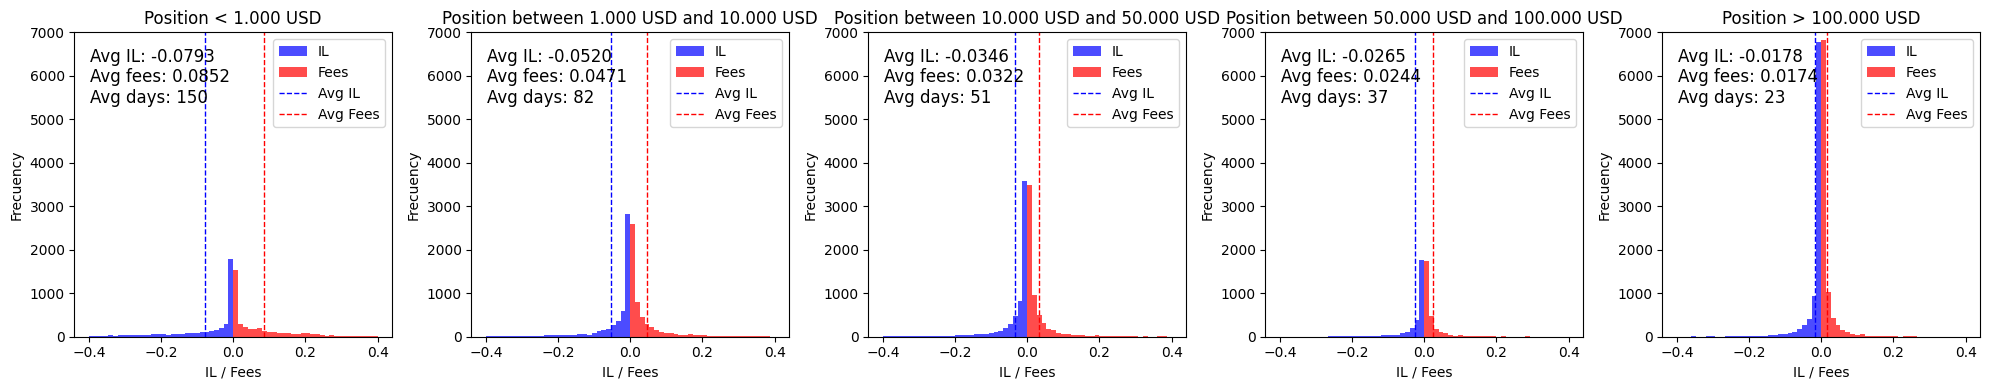

In [480]:
import matplotlib.pyplot as plt

# Define the data subsets
less_than_1k = risky_combined_df[risky_combined_df['event_amountUSD'] < 1000]
between_1k_and_10k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 1000) & (risky_combined_df['event_amountUSD'] < 10000)]
between_10k_and_50k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 10000) & (risky_combined_df['event_amountUSD'] < 50000)]
between_50k_and_100k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 50000) & (risky_combined_df['event_amountUSD'] <= 100000)]
more_than_100k = risky_combined_df[risky_combined_df['event_amountUSD'] > 100000]

# Calculate the average IL and fees for each group
avg_il_less_than_1k = less_than_1k['IL_formula'].mean()
avg_il_between_1k_and_10k = between_1k_and_10k['IL_formula'].mean()
avg_il_between_10k_and_50k = between_10k_and_50k['IL_formula'].mean()
avg_il_between_50k_and_100k = between_50k_and_100k['IL_formula'].mean()
avg_il_more_than_100k = more_than_100k['IL_formula'].mean()

avg_fees_less_than_1k = less_than_1k['relativeFees'].mean()
avg_fees_between_1k_and_10k = between_1k_and_10k['relativeFees'].mean()
avg_fees_between_10k_and_50k = between_10k_and_50k['relativeFees'].mean()
avg_fees_between_50k_and_100k = between_50k_and_100k['relativeFees'].mean()
avg_fees_more_than_100k = more_than_100k['relativeFees'].mean()

# Calculate the average duration for each group
avg_duration_less_than_1k = less_than_1k['weightedDurationSeconds'].mean() / (24 * 3600)  # Convert seconds to days
avg_duration_between_1k_and_10k = between_1k_and_10k['weightedDurationSeconds'].mean() / (24 * 3600)
avg_duration_between_10k_and_50k = between_10k_and_50k['weightedDurationSeconds'].mean() / (24 * 3600)
avg_duration_between_50k_and_100k = between_50k_and_100k['weightedDurationSeconds'].mean() / (24 * 3600)
avg_duration_more_than_100k = more_than_100k['weightedDurationSeconds'].mean() / (24 * 3600)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

def plot_histogram(data, ax, title, avg_il, avg_fees, avg_duration):
    ax.hist(data['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=(-0.4, 0), label='IL')
    ax.hist(data['relativeFees'], bins=30, color='red', alpha=0.6, density=False, label='Fees', range=(0, 0.4))
    ax.axvline(avg_il, color='blue', linestyle='dashed', linewidth=1, label='Avg IL')
    ax.axvline(avg_fees, color='red', linestyle='dashed', linewidth=1, label='Avg Fees')
    ax.set_title(title)
    ax.set_xlabel('IL / Fees')
    ax.set_ylabel('Frecuency')
    ax.set_ylim(0, 7000)
    
    # Fixed legend position
    ax.legend(loc='upper right')

    # Add a box with average values
    textstr = f'Avg IL: {avg_il:.4f}\nAvg fees: {avg_fees:.4f}\nAvg days: {avg_duration:.0f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Plot histograms for each group
plot_histogram(less_than_1k, axes[0], 'Position < 1.000 USD', avg_il_less_than_1k, avg_fees_less_than_1k, avg_duration_less_than_1k)
plot_histogram(between_1k_and_10k, axes[1], 'Position between 1.000 USD and 10.000 USD', avg_il_between_1k_and_10k, avg_fees_between_1k_and_10k, avg_duration_between_1k_and_10k)
plot_histogram(between_10k_and_50k, axes[2], 'Position between 10.000 USD and 50.000 USD', avg_il_between_10k_and_50k, avg_fees_between_10k_and_50k, avg_duration_between_10k_and_50k)
plot_histogram(between_50k_and_100k, axes[3], 'Position between 50.000 USD and 100.000 USD', avg_il_between_50k_and_100k, avg_fees_between_50k_and_100k, avg_duration_between_50k_and_100k)
plot_histogram(more_than_100k, axes[4], 'Position > 100.000 USD', avg_il_more_than_100k, avg_fees_more_than_100k, avg_duration_more_than_100k)

plt.tight_layout()
plt.show()


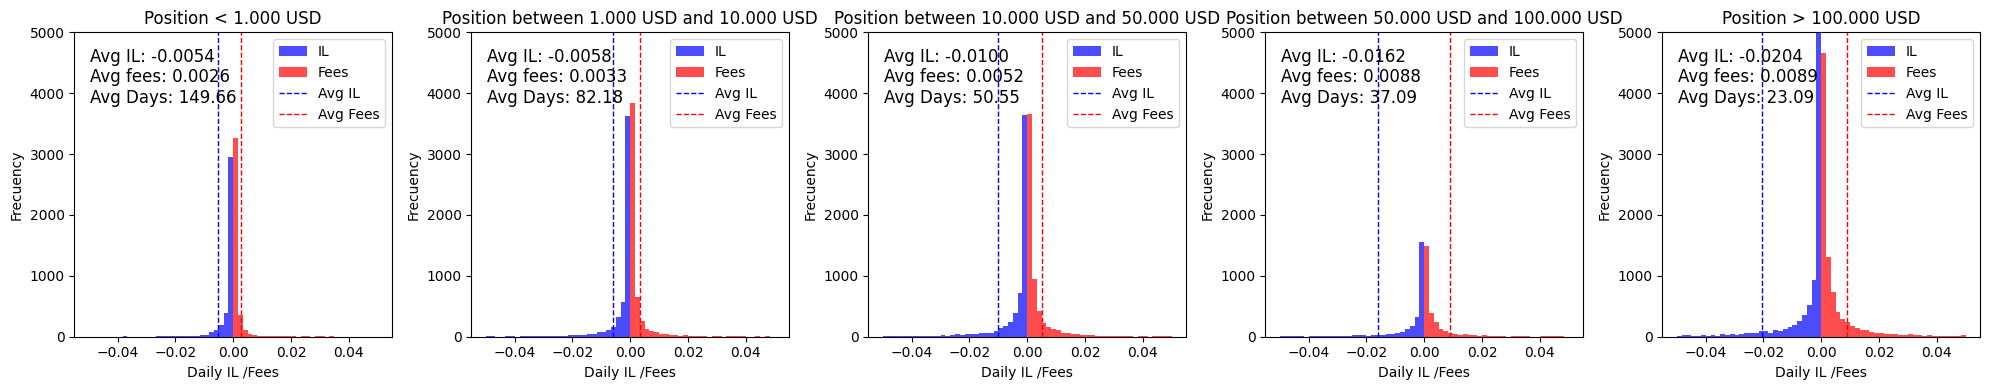

In [481]:
import matplotlib.pyplot as plt

# Define the data subsets
less_than_1k = risky_combined_df[risky_combined_df['event_amountUSD'] < 1000]
between_1k_and_10k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 1000) & (risky_combined_df['event_amountUSD'] < 10000)]
between_10k_and_50k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 10000) & (risky_combined_df['event_amountUSD'] < 50000)]
between_50k_and_100k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 50000) & (risky_combined_df['event_amountUSD'] <= 100000)]
more_than_100k = risky_combined_df[risky_combined_df['event_amountUSD'] > 100000]

# Calculate the average IL and fees for each group
avg_il_less_than_1k = less_than_1k['daily_IL_formula'].mean()
avg_il_between_1k_and_10k = between_1k_and_10k['daily_IL_formula'].mean()
avg_il_between_10k_and_50k = between_10k_and_50k['daily_IL_formula'].mean()
avg_il_between_50k_and_100k = between_50k_and_100k['daily_IL_formula'].mean()
avg_il_more_than_100k = more_than_100k['daily_IL_formula'].mean()

avg_fees_less_than_1k = less_than_1k['daily_Fees'].mean()
avg_fees_between_1k_and_10k = between_1k_and_10k['daily_Fees'].mean()
avg_fees_between_10k_and_50k = between_10k_and_50k['daily_Fees'].mean()
avg_fees_between_50k_and_100k = between_50k_and_100k['daily_Fees'].mean()
avg_fees_more_than_100k = more_than_100k['daily_Fees'].mean()

# Calculate the average duration for each group
avg_duration_less_than_1k = less_than_1k['weightedDurationSeconds'].mean() / (24 * 3600)  # Convert seconds to days
avg_duration_between_1k_and_10k = between_1k_and_10k['weightedDurationSeconds'].mean() / (24 * 3600)
avg_duration_between_10k_and_50k = between_10k_and_50k['weightedDurationSeconds'].mean() / (24 * 3600)
avg_duration_between_50k_and_100k = between_50k_and_100k['weightedDurationSeconds'].mean() / (24 * 3600)
avg_duration_more_than_100k = more_than_100k['weightedDurationSeconds'].mean() / (24 * 3600)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

def plot_histogram(data, ax, title, avg_il, avg_fees, avg_duration):
    ax.hist(data['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=(-0.05, 0), label='IL')
    ax.hist(data['daily_Fees'], bins=30, color='red', alpha=0.6, density=False, label='Fees', range=(0, 0.05))
    ax.axvline(avg_il, color='blue', linestyle='dashed', linewidth=1, label='Avg IL')
    ax.axvline(avg_fees, color='red', linestyle='dashed', linewidth=1, label='Avg Fees')
    ax.set_title(title)
    ax.set_xlabel('Daily IL /Fees')
    ax.set_ylabel('Frecuency')
    ax.set_ylim(0, 5000)
    
    # Fixed legend position
    ax.legend(loc='upper right')

    # Add a box with average values
    textstr = f'Avg IL: {avg_il:.4f}\nAvg fees: {avg_fees:.4f}\nAvg Days: {avg_duration:.2f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Plot histograms for each group
plot_histogram(less_than_1k, axes[0], 'Position < 1.000 USD', avg_il_less_than_1k, avg_fees_less_than_1k, avg_duration_less_than_1k)
plot_histogram(between_1k_and_10k, axes[1], 'Position between 1.000 USD and 10.000 USD', avg_il_between_1k_and_10k, avg_fees_between_1k_and_10k, avg_duration_between_1k_and_10k)
plot_histogram(between_10k_and_50k, axes[2], 'Position between 10.000 USD and 50.000 USD', avg_il_between_10k_and_50k, avg_fees_between_10k_and_50k, avg_duration_between_10k_and_50k)
plot_histogram(between_50k_and_100k, axes[3], 'Position between 50.000 USD and 100.000 USD', avg_il_between_50k_and_100k, avg_fees_between_50k_and_100k, avg_duration_between_50k_and_100k)
plot_histogram(more_than_100k, axes[4], 'Position > 100.000 USD', avg_il_more_than_100k, avg_fees_more_than_100k, avg_duration_more_than_100k)

plt.tight_layout()
plt.show()

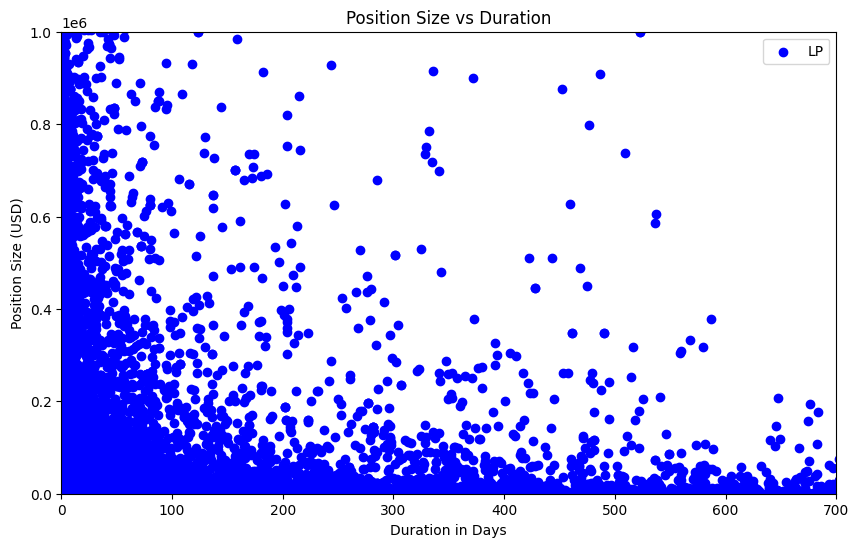

In [437]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['durationDays'], combined_df['event_amountUSD'], color='blue', label='LP')
plt.title('Position Size vs Duration')
plt.xlabel('Duration in Days')
plt.ylabel('Position Size (USD)')
plt.legend()
plt.xlim(0, 700)
plt.ylim(0, 1000000)
plt.show()

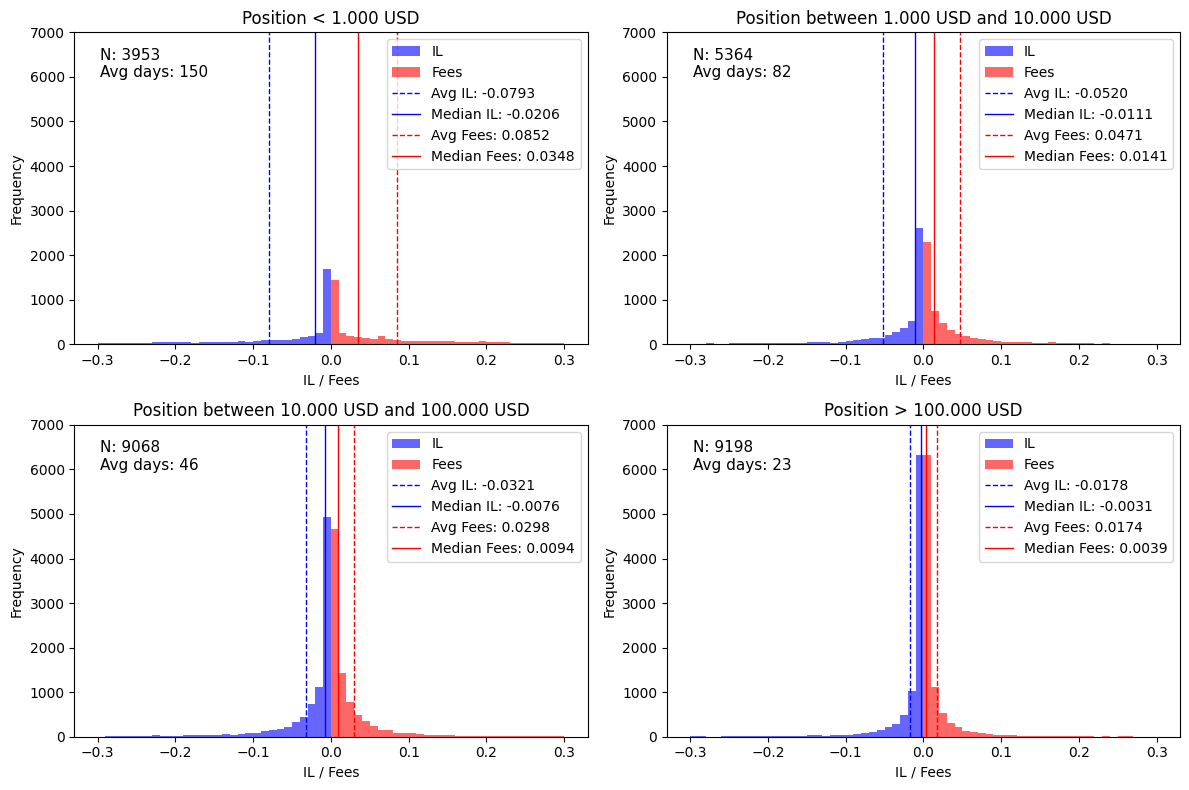

In [578]:
import matplotlib.pyplot as plt

# Define the data subsets
less_than_1k = risky_combined_df[risky_combined_df['event_amountUSD'] < 1000]
between_1k_and_10k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 1000) & (risky_combined_df['event_amountUSD'] < 10000)]
between_10k_and_100k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 10000) & (risky_combined_df['event_amountUSD'] < 100000)]
more_than_100k = risky_combined_df[risky_combined_df['event_amountUSD'] >= 100000]

# Calculate the average and median IL and fees for each group
def calculate_metrics(data):
    avg_il = data['IL_formula'].mean()
    median_il = data['IL_formula'].median()
    avg_fees = data['relativeFees'].mean()
    median_fees = data['relativeFees'].median()
    avg_duration = data['weightedDurationSeconds'].mean() / (24 * 3600)  # Convert seconds to days
    return avg_il, median_il, avg_fees, median_fees, avg_duration, len(data)

metrics_less_than_1k = calculate_metrics(less_than_1k)
metrics_between_1k_and_10k = calculate_metrics(between_1k_and_10k)
metrics_between_10k_and_100k = calculate_metrics(between_10k_and_100k)
metrics_more_than_100k = calculate_metrics(more_than_100k)

# Create a 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

def plot_histogram(data, ax, title, metrics):
    avg_il, median_il, avg_fees, median_fees, avg_duration, n = metrics
    ax.hist(data['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=(-0.3, 0), label='IL')
    ax.hist(data['relativeFees'], bins=30, color='red', alpha=0.6, density=False, label='Fees', range=(0, 0.3))
    ax.axvline(avg_il, color='blue', linestyle='dashed', linewidth=1, label=f'Avg IL: {avg_il:.4f}')
    ax.axvline(median_il, color='blue', linestyle='solid', linewidth=1, label=f'Median IL: {median_il:.4f}')
    ax.axvline(avg_fees, color='red', linestyle='dashed', linewidth=1, label=f'Avg Fees: {avg_fees:.4f}')
    ax.axvline(median_fees, color='red', linestyle='solid', linewidth=1, label=f'Median Fees: {median_fees:.4f}')
    ax.set_title(title)
    ax.set_xlabel('IL / Fees')
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, 7000)
    
    # Fixed legend position
    ax.legend(loc='upper right')

    # Add a box with average days and N
    textstr = f'N: {n}\nAvg days: {avg_duration:.0f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11, verticalalignment='top')

# Plot histograms for each group
plot_histogram(less_than_1k, axes[0, 0], 'Position < 1.000 USD', metrics_less_than_1k)
plot_histogram(between_1k_and_10k, axes[0, 1], 'Position between 1.000 USD and 10.000 USD', metrics_between_1k_and_10k)
plot_histogram(between_10k_and_100k, axes[1, 0], 'Position between 10.000 USD and 100.000 USD', metrics_between_10k_and_100k)
plot_histogram(more_than_100k, axes[1, 1], 'Position > 100.000 USD', metrics_more_than_100k)

plt.tight_layout()
plt.show()


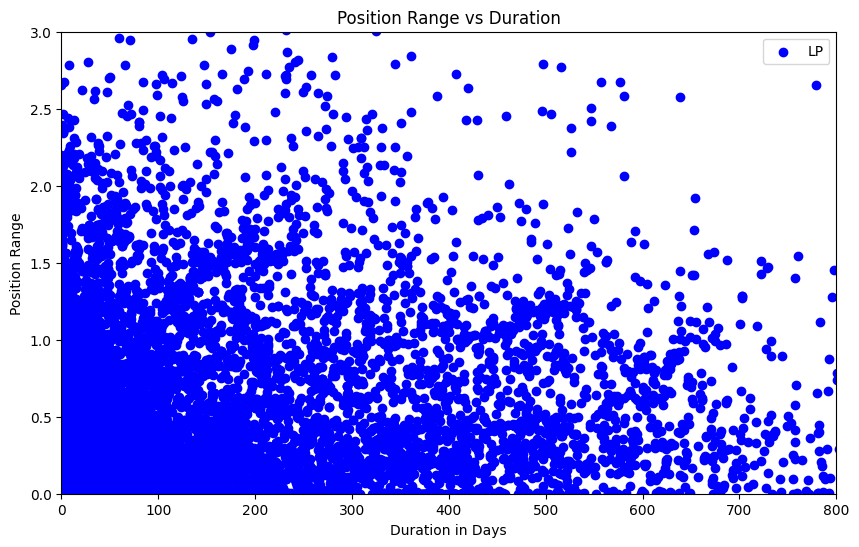

In [571]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['durationDays'], combined_df['range_size'], color='blue', label='LP')
plt.title('Position Range vs Duration')
plt.xlabel('Duration in Days')
plt.ylabel('Position Range')
plt.legend()
plt.xlim(0, 800)
plt.ylim(0, 3)
plt.show()

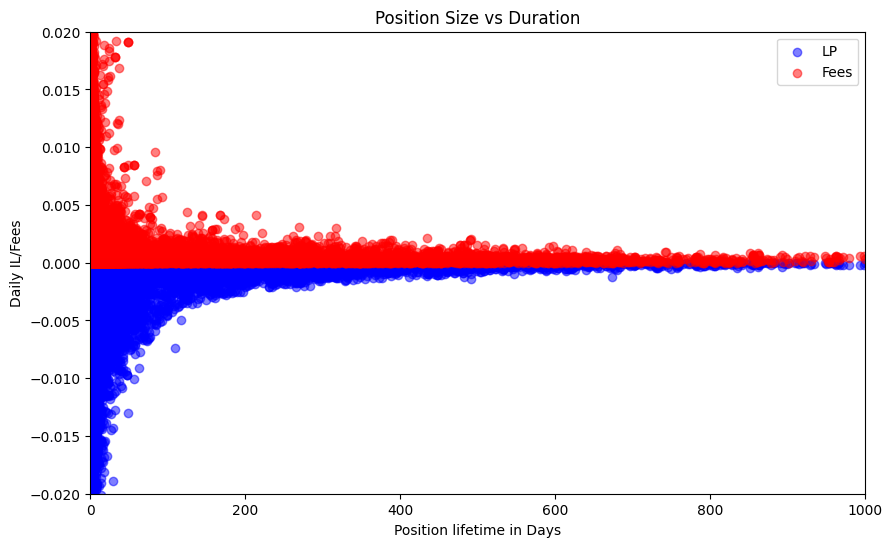

In [166]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['durationDays'], combined_df['daily_IL_formula'], color='blue', label='LP', alpha=0.5)
plt.scatter(combined_df['durationDays'], combined_df['daily_Fees'], color='red', label='Fees', alpha=0.5)
plt.title('Position IL/Fees vs Duration')
plt.xlabel('Position lifetime in Days')
plt.ylabel('Daily IL/Fees')
plt.legend()
plt.xlim(0, 1000)
plt.ylim(-0.02, 0.02)
plt.show()

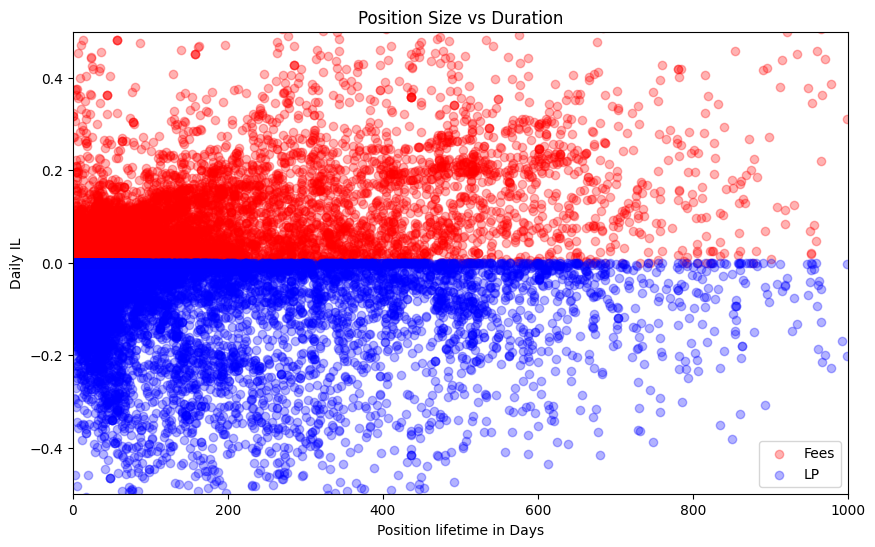

In [162]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['durationDays'], combined_df['relativeFees'], color='red', label='Fees', alpha=0.3)
plt.scatter(combined_df['durationDays'], combined_df['IL_formula'], color='blue', label='LP', alpha=0.3)
plt.title('Position IL/Fees vs Duration')
plt.xlabel('Position lifetime in Days')
plt.ylabel('Daily IL')
plt.legend()
plt.xlim(0, 1000)
plt.ylim(-0.5, 0.5)
plt.show()

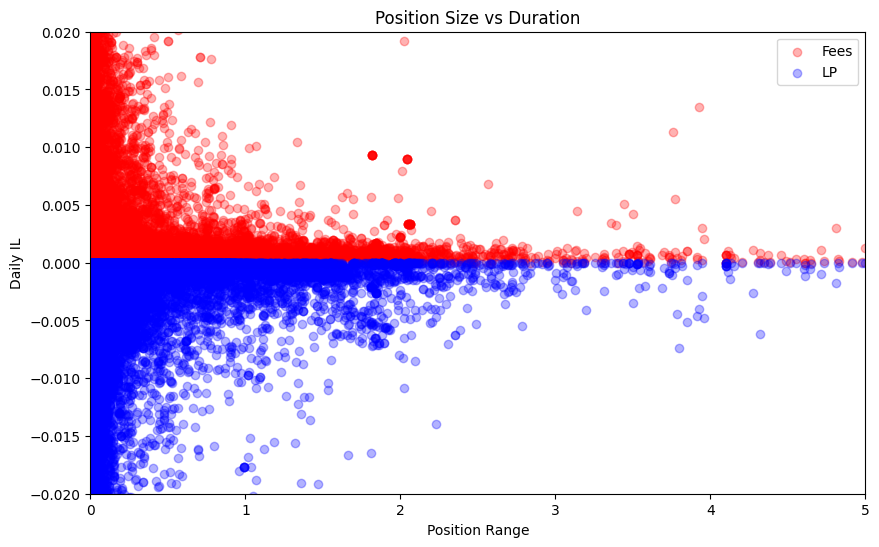

In [164]:
plt.figure(figsize=(10, 6))
plt.scatter(risky_combined_df['range_size'], risky_combined_df['daily_Fees'], color='red', label='Fees', alpha=0.3)
plt.scatter(risky_combined_df['range_size'], risky_combined_df['daily_IL_formula'], color='blue', label='LP', alpha=0.3)
plt.title('Position Size vs Duration')
plt.xlabel('Position Range')
plt.ylabel('Daily IL')
plt.legend()
plt.xlim(0, 5)
plt.ylim(-0.02, 0.02)
plt.show()

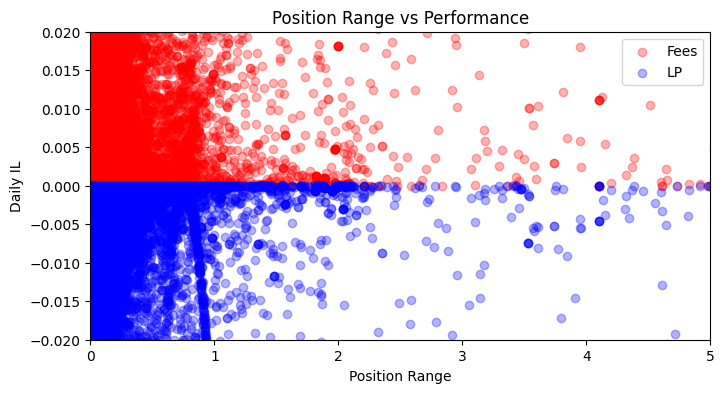

In [165]:
plt.figure(figsize=(8, 4))
plt.scatter(risky_combined_df['range_size'], risky_combined_df['relativeFees'], color='red', label='Fees', alpha=0.3)
plt.scatter(risky_combined_df['range_size'], risky_combined_df['IL_formula'], color='blue', label='LP', alpha=0.3)
plt.title('Position Range vs Performance')
plt.xlabel('Position Range')
plt.ylabel('Daily IL')
plt.legend()
plt.xlim(0, 5)
plt.ylim(-0.02, 0.02)
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(risky_combined_df['range_size'], risky_combined_df['relativeFees'], color='red', label='Fees', alpha=0.3)
plt.scatter(risky_combined_df['range_size'], risky_combined_df['IL_formula'], color='blue', label='LP', alpha=0.3)
plt.title('Position Range vs Performance')
plt.xlabel('Position Range')
plt.ylabel('IL')
plt.legend()
plt.xlim(0, 5)
plt.ylim(-0.02, 0.02)
plt.show()

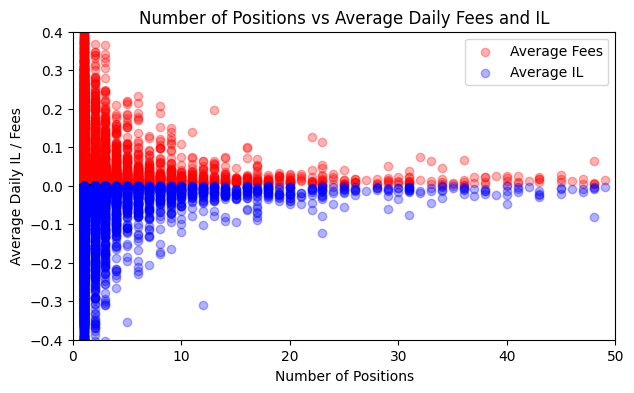

In [181]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'risky_combined_df' is your original DataFrame

# Make a copy of the original DataFrame
risky_combined_df_copy = risky_combined_df.copy()

# Calculate the number of positions per wallet
wallet_position_count = risky_combined_df_copy['owner'].value_counts().reset_index()
wallet_position_count.columns = ['owner', 'position_count']

# Calculate the average fees and IL per wallet
wallet_averages = risky_combined_df_copy.groupby('owner').agg({
    'relativeFees': 'mean',
    'IL_formula': 'mean'
}).reset_index()

# Merge the position count data with the average data
wallet_averages = wallet_averages.merge(wallet_position_count, on='owner', how='left')

# Plotting
plt.figure(figsize=(7, 4))

# Scatter plot for average fees
plt.scatter(wallet_averages['position_count'], wallet_averages['relativeFees'], 
            color='red', label='Average Fees', alpha=0.3)

# Scatter plot for average IL
plt.scatter(wallet_averages['position_count'], wallet_averages['IL_formula'], 
            color='blue', label='Average IL', alpha=0.3)

# Titles and labels
plt.title('Number of Positions vs Average Daily Fees and IL')
plt.xlabel('Number of Positions')
plt.ylabel('Average Daily IL / Fees')

# Legend
plt.legend()

# Optional: Adjust limits if needed
plt.xlim(0, 50)
plt.ylim(-0.4, 0.4)

plt.show()


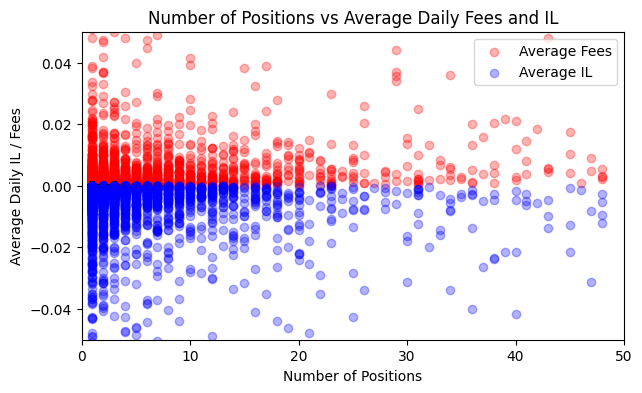

In [182]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'risky_combined_df' is your original DataFrame

# Make a copy of the original DataFrame
risky_combined_df_copy = risky_combined_df.copy()

# Calculate the number of positions per wallet
wallet_position_count = risky_combined_df_copy['owner'].value_counts().reset_index()
wallet_position_count.columns = ['owner', 'position_count']

# Calculate the average fees and IL per wallet
wallet_averages = risky_combined_df_copy.groupby('owner').agg({
    'daily_Fees': 'mean',
    'daily_IL_formula': 'mean'
}).reset_index()

# Merge the position count data with the average data
wallet_averages = wallet_averages.merge(wallet_position_count, on='owner', how='left')

# Plotting
plt.figure(figsize=(7, 4))

# Scatter plot for average fees
plt.scatter(wallet_averages['position_count'], wallet_averages['daily_Fees'], 
            color='red', label='Average Fees', alpha=0.3)

# Scatter plot for average IL
plt.scatter(wallet_averages['position_count'], wallet_averages['daily_IL_formula'], 
            color='blue', label='Average IL', alpha=0.3)

# Titles and labels
plt.title('Number of Positions vs Average Daily Fees and IL')
plt.xlabel('Number of Positions')
plt.ylabel('Average Daily IL / Fees')

# Legend
plt.legend()

# Optional: Adjust limits if needed
plt.xlim(0, 50)
plt.ylim(-0.05, 0.05)

plt.show()


In [139]:
combined_df['daily_IL_formula'].describe()

count    25154.000000
mean        -0.012904
std          0.069416
min         -1.000000
25%         -0.004397
50%         -0.000840
75%         -0.000077
max          0.000000
Name: daily_IL_formula, dtype: float64

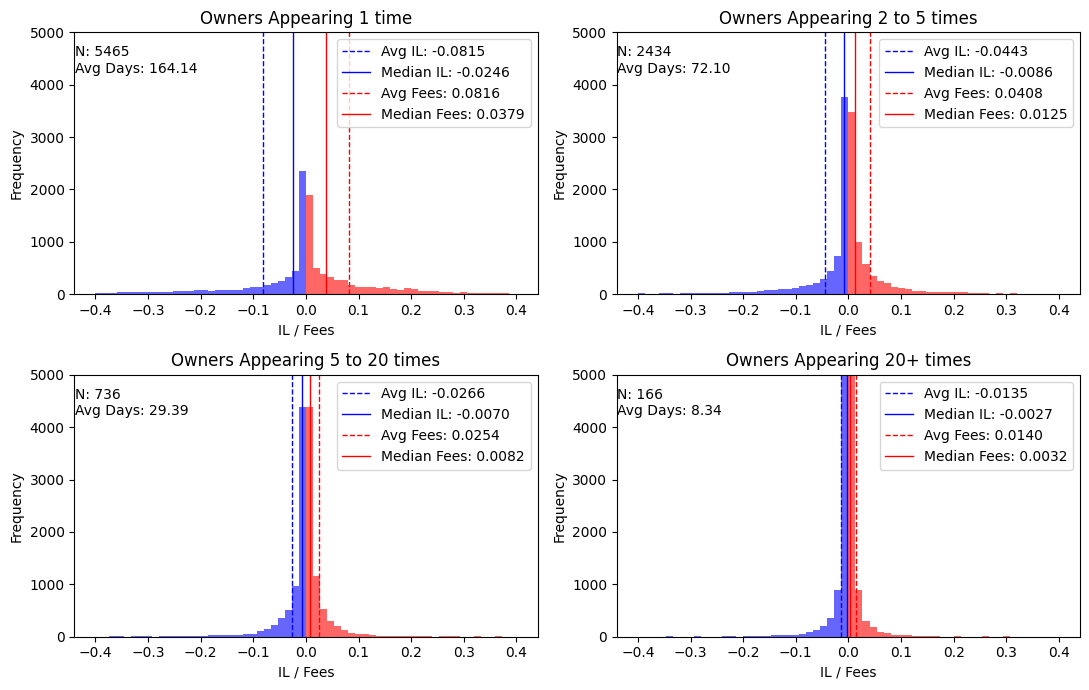

In [557]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the frequency of each wallet address
address_frequency = risky_combined_df['owner'].value_counts()

# Step 2: Group the addresses based on their frequency
group_1 = address_frequency[address_frequency == 1].index
group_2_5 = address_frequency[(address_frequency >= 2) & (address_frequency <= 5)].index
group_5_20 = address_frequency[(address_frequency > 5) & (address_frequency <= 20)].index
group_20_plus = address_frequency[address_frequency > 20].index

# Step 3: Calculate the average and median IL and weightedDurationSeconds for each group
def calculate_metrics(group):
    num_addresses = len(group)
    group_df = risky_combined_df[risky_combined_df['owner'].isin(group)]
    avg_il = group_df['IL_formula'].mean()
    median_il = group_df['IL_formula'].median()
    avg_weighted_duration_days = group_df['weightedDurationSeconds'].mean() / 86400  # Convert seconds to days
    avg_fees = group_df['relativeFees'].mean()  # Fees per day
    median_fees = group_df['relativeFees'].median()
    return num_addresses, avg_il, median_il, avg_fees, median_fees, avg_weighted_duration_days

group_metrics = {
    'group_1': calculate_metrics(group_1),
    'group_2_5': calculate_metrics(group_2_5),
    'group_5_20': calculate_metrics(group_5_20),
    'group_20_plus': calculate_metrics(group_20_plus)
}

time_ranges = {
    'group_1': '1 time',
    'group_2_5': '2 to 5 times',
    'group_5_20': '5 to 20 times',
    'group_20_plus': '20+ times'
}

# Step 4: Plot histograms for each group
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))

for i, (group_name, (num_addresses, avg_il, median_il, avg_fees, median_fees, avg_weighted_duration_days)) in enumerate(group_metrics.items()):
    group = eval(group_name)
    ax = axes[i // 2, i % 2]
    ax.hist(risky_combined_df[risky_combined_df['owner'].isin(group)]['IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=(-0.4, 0))
    ax.hist(risky_combined_df[risky_combined_df['owner'].isin(group)]['relativeFees'], bins=30, color='red', alpha=0.6, density=False, range=(0, 0.4))
    ax.set_title(f'Owners Appearing {time_ranges[group_name]}')
    ax.set_xlabel('IL / Fees')
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, 5000)
    # Add average and median lines for IL and Fees
    ax.axvline(avg_il, color='blue', linestyle='dashed', linewidth=1, label=f'Avg IL: {avg_il:.4f}')
    ax.axvline(median_il, color='blue', linestyle='solid', linewidth=1, label=f'Median IL: {median_il:.4f}')
    ax.axvline(avg_fees, color='red', linestyle='dashed', linewidth=1, label=f'Avg Fees: {avg_fees:.4f}')
    ax.axvline(median_fees, color='red', linestyle='solid', linewidth=1, label=f'Median Fees: {median_fees:.4f}')
    ax.text(ax.get_xlim()[0] + 0.001, ax.get_ylim()[1] * 0.95, f'N: {num_addresses}\nAvg Days: {avg_weighted_duration_days:.2f}', color='black', va='top')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [980]:
risky_combined_df['daily_Fees'].describe()

count    27583.000000
mean         0.006087
std          0.025442
min          0.000000
25%          0.000328
50%          0.001008
75%          0.003418
max          1.000000
Name: daily_Fees, dtype: float64

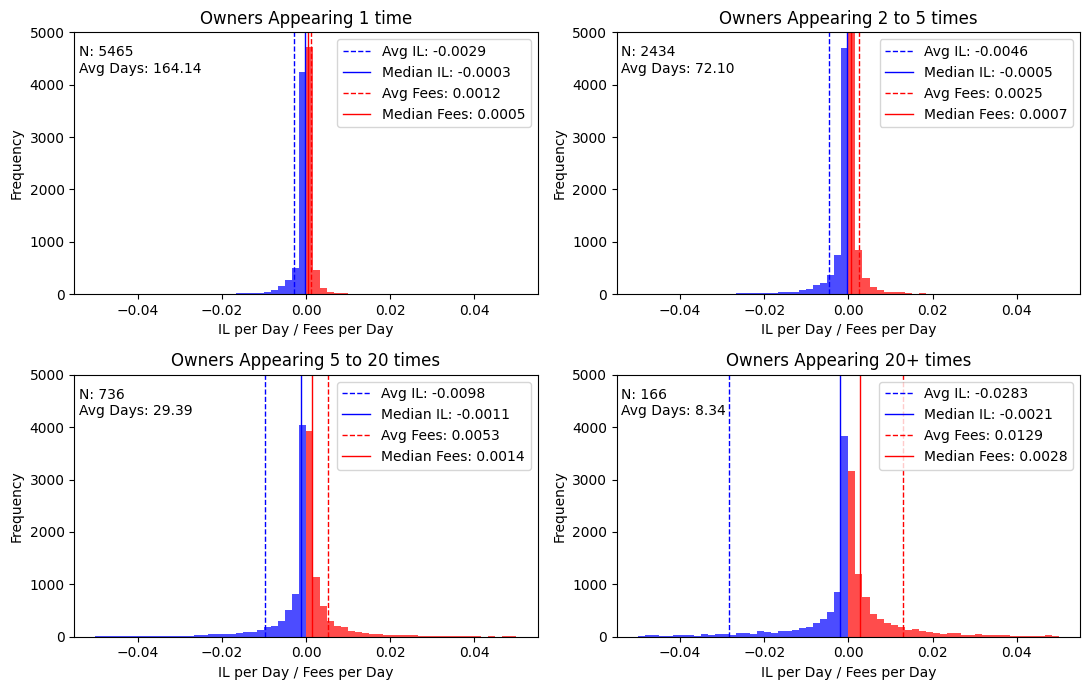

In [553]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the frequency of each wallet address
address_frequency = risky_combined_df['owner'].value_counts()

# Step 2: Group the addresses based on their frequency
group_1 = address_frequency[address_frequency == 1].index
group_2_5 = address_frequency[(address_frequency >= 2) & (address_frequency <= 5)].index
group_5_20 = address_frequency[(address_frequency > 5) & (address_frequency <= 20)].index
group_20_plus = address_frequency[address_frequency > 20].index

# Step 3: Calculate the average and median IL and weightedDurationSeconds for each group
def calculate_metrics(group):
    num_addresses = len(group)
    group_df = risky_combined_df[risky_combined_df['owner'].isin(group)]
    avg_il_per_day = group_df['daily_IL_formula'].mean()
    median_il_per_day = group_df['daily_IL_formula'].median()
    avg_weighted_duration_days = group_df['weightedDurationSeconds'].mean() / 86400  # Convert seconds to days
    avg_fees_per_day = group_df['daily_Fees'].mean()  # Fees per day
    median_fees_per_day = group_df['daily_Fees'].median()
    return num_addresses, avg_il_per_day, median_il_per_day, avg_fees_per_day, median_fees_per_day, avg_weighted_duration_days

group_metrics = {
    'group_1': calculate_metrics(group_1),
    'group_2_5': calculate_metrics(group_2_5),
    'group_5_20': calculate_metrics(group_5_20),
    'group_20_plus': calculate_metrics(group_20_plus)
}

time_ranges = {
    'group_1': '1 time',
    'group_2_5': '2 to 5 times',
    'group_5_20': '5 to 20 times',
    'group_20_plus': '20+ times'
}

# Step 4: Plot histograms for each group
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))

for i, (group_name, (num_addresses, avg_il_per_day, median_il_per_day, avg_fees_per_day, median_fees_per_day, avg_weighted_duration_days)) in enumerate(group_metrics.items()):
    group = eval(group_name)
    ax = axes[i // 2, i % 2]
    ax.hist(risky_combined_df[risky_combined_df['owner'].isin(group)]['daily_IL_formula'], bins=30, color='blue', alpha=0.6, density=False, range=(-0.05, 0))
    ax.hist(risky_combined_df[risky_combined_df['owner'].isin(group)]['daily_Fees'], bins=30, color='red', alpha=0.6, density=False, range=(0, 0.05))
    ax.set_title(f'Owners Appearing {time_ranges[group_name]}')
    ax.set_xlabel('IL per Day / Fees per Day')
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, 5000)
    # Add average and median lines for IL and Fees
    ax.axvline(avg_il_per_day, color='blue', linestyle='dashed', linewidth=1, label=f'Avg IL: {avg_il_per_day:.4f}')
    ax.axvline(median_il_per_day, color='blue', linestyle='solid', linewidth=1, label=f'Median IL: {median_il_per_day:.4f}')
    ax.axvline(avg_fees_per_day, color='red', linestyle='dashed', linewidth=1, label=f'Avg Fees: {avg_fees_per_day:.4f}')
    ax.axvline(median_fees_per_day, color='red', linestyle='solid', linewidth=1, label=f'Median Fees: {median_fees_per_day:.4f}')
    ax.text(ax.get_xlim()[0] + 0.001, ax.get_ylim()[1] * 0.95, f'N: {num_addresses}\nAvg Days: {avg_weighted_duration_days:.2f}', color='black', va='top')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


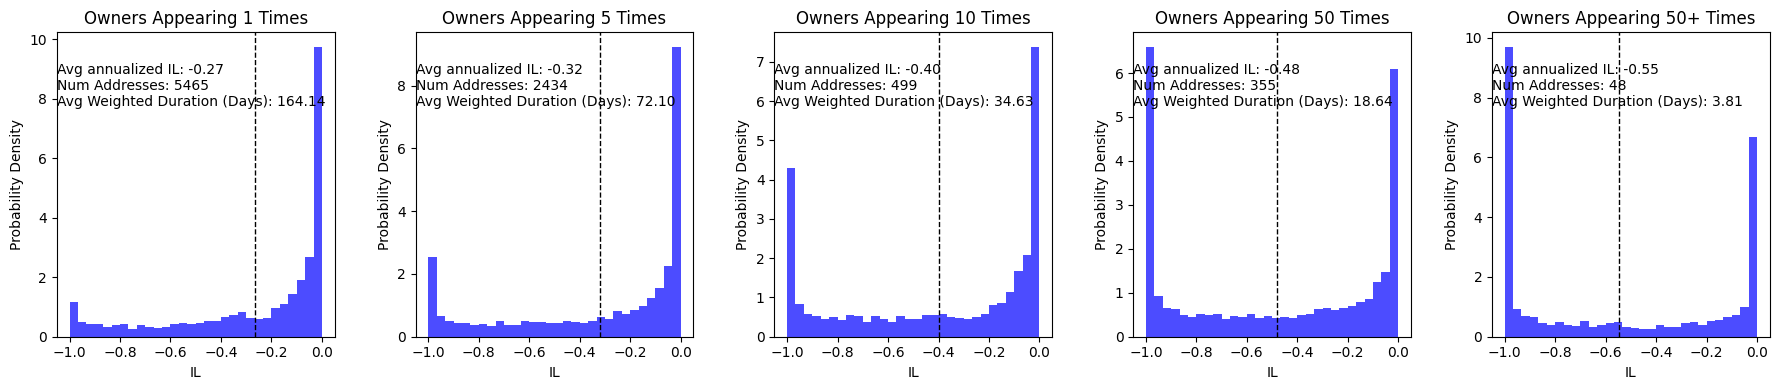

In [216]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the frequency of each wallet address
address_frequency = risky_combined_df['owner'].value_counts()

# Step 2: Group the addresses based on their frequency
group_1 = address_frequency[address_frequency == 1].index
group_2_5 = address_frequency[(address_frequency >= 2) & (address_frequency <= 5)].index
group_5_10 = address_frequency[(address_frequency > 5) & (address_frequency <= 10)].index
group_10_50 = address_frequency[(address_frequency > 10) & (address_frequency <= 50)].index
group_50_plus = address_frequency[address_frequency > 50].index

# Step 3: Calculate the average IL and weightedDurationSeconds for each group
def calculate_metrics(group):
    num_addresses = len(group)
    avg_il = risky_combined_df[risky_combined_df['owner'].isin(group)]['IL_formula_annualized'].mean()
    avg_weighted_duration_days = risky_combined_df[risky_combined_df['owner'].isin(group)]['weightedDurationSeconds'].mean() / 86400  # Convert seconds to days
    return num_addresses, avg_il, avg_weighted_duration_days

group_metrics = {
    'group_1': calculate_metrics(group_1),
    'group_2_5': calculate_metrics(group_2_5),
    'group_5_10': calculate_metrics(group_5_10),
    'group_10_50': calculate_metrics(group_10_50),
    'group_50_plus': calculate_metrics(group_50_plus)
}

# Step 4: Plot histograms for each group
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

for i, (group_name, (num_addresses, avg_il, avg_weighted_duration_days)) in enumerate(group_metrics.items()):
    group = eval(group_name)
    ax = axes[i]
    ax.hist(risky_combined_df[risky_combined_df['owner'].isin(group)]['IL_formula_annualized'], bins=30, color='blue', alpha=0.6, density=True, range=(-1, 0))
    ax.set_title(f'Owners Appearing {group_name.split("_")[-1].replace("plus", "50+")} Times')
    ax.set_xlabel('IL')
    ax.set_ylabel('Probability Density')
    ax.axvline(avg_il, color='black', linestyle='dashed', linewidth=1)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1]*0.9, f'Avg annualized IL: {avg_il:.2f}\nNum Addresses: {num_addresses}\nAvg Weighted Duration (Days): {avg_weighted_duration_days:.2f}', color='black', va='top')

plt.tight_layout()
plt.show()


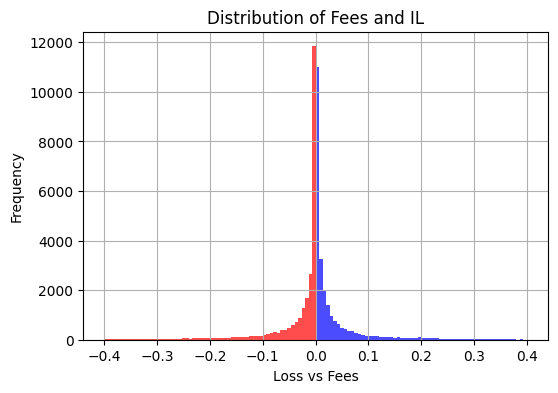

In [217]:
plt.figure(figsize=(6, 4))

plt.hist(combined_df['relativeFees'], bins=60, color='blue', alpha=0.6, range=(0, 0.4))
plt.hist(combined_df['IL_formula'], bins=60, color='red', alpha=0.6, range=(-0.4, 0))

plt.title('Distribution of Fees and IL')
plt.xlabel('Loss vs Fees')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

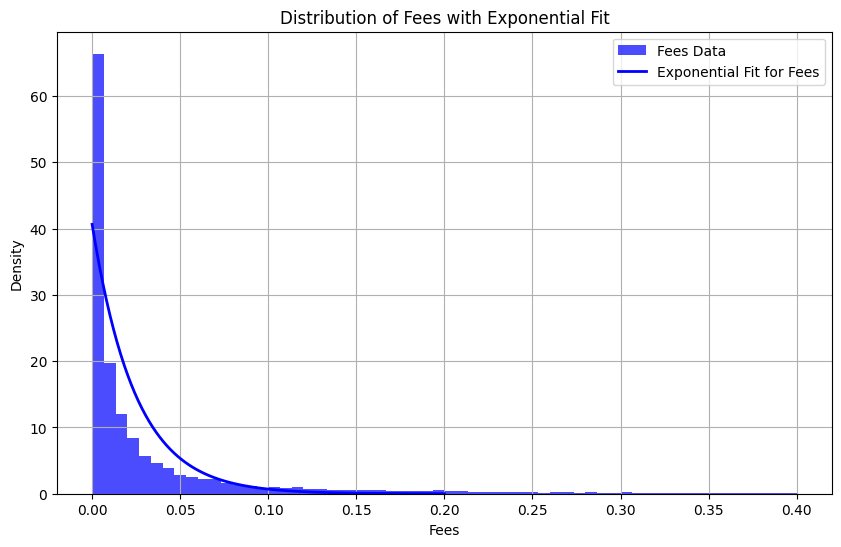

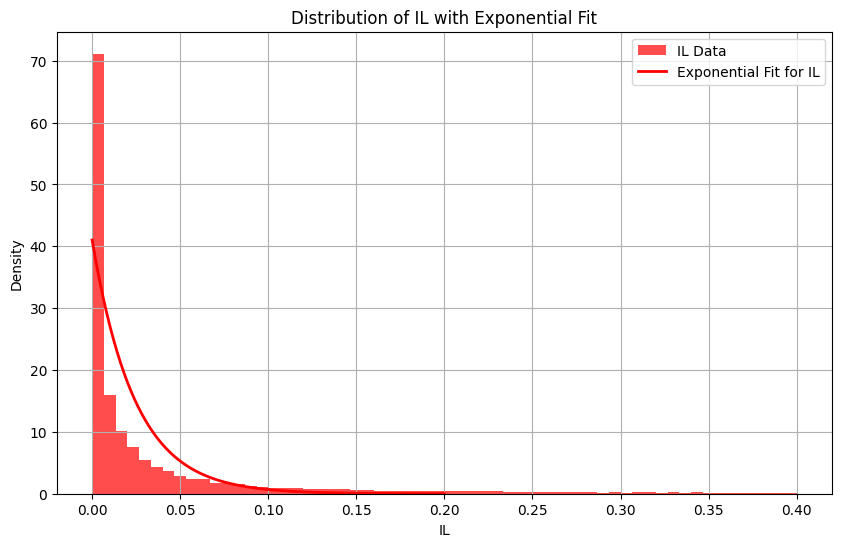

In [741]:
from scipy.stats import expon

# Data for exponential fitting, avoiding zeros
fees_data = combined_df['relativeFees']
il_data = -combined_df['IL_formula']

# Add a small value to avoid exact zeros if needed
small_value = 1e-12
fees_data = fees_data + small_value
il_data = il_data + small_value

# Fit exponential distributions
params_fees = expon.fit(fees_data[(fees_data > 0) & (fees_data<0.2)], floc=0)  # Fixed location at 0
params_il = expon.fit(il_data[(il_data > 0) & (il_data < 0.2)], floc=0)  # Fixed location at 0

# Generate values for plotting the fit
x_fees = np.linspace(0, 0.2, 100)
x_il = np.linspace(0, 0.2, 100)
pdf_fees = expon.pdf(x_fees, *params_fees)
pdf_il = expon.pdf(x_il, *params_il)

# Plotting Fees Histogram and Fit
plt.figure(figsize=(10, 6))
plt.hist(fees_data, bins=60, color='blue', alpha=0.6, range=(0, 0.4), density=True, label='Fees Data')
plt.plot(x_fees, pdf_fees, 'b-', lw=2, label='Exponential Fit for Fees')
plt.title('Distribution of Fees with Exponential Fit')
plt.xlabel('Fees')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Plotting IL Histogram and Fit
plt.figure(figsize=(10, 6))
plt.hist(il_data, bins=60, color='red', alpha=0.6, range=(0, 0.4), density=True, label='IL Data')
plt.plot(x_il, pdf_il, 'r-', lw=2, label='Exponential Fit for IL')
plt.title('Distribution of IL with Exponential Fit')
plt.xlabel('IL')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

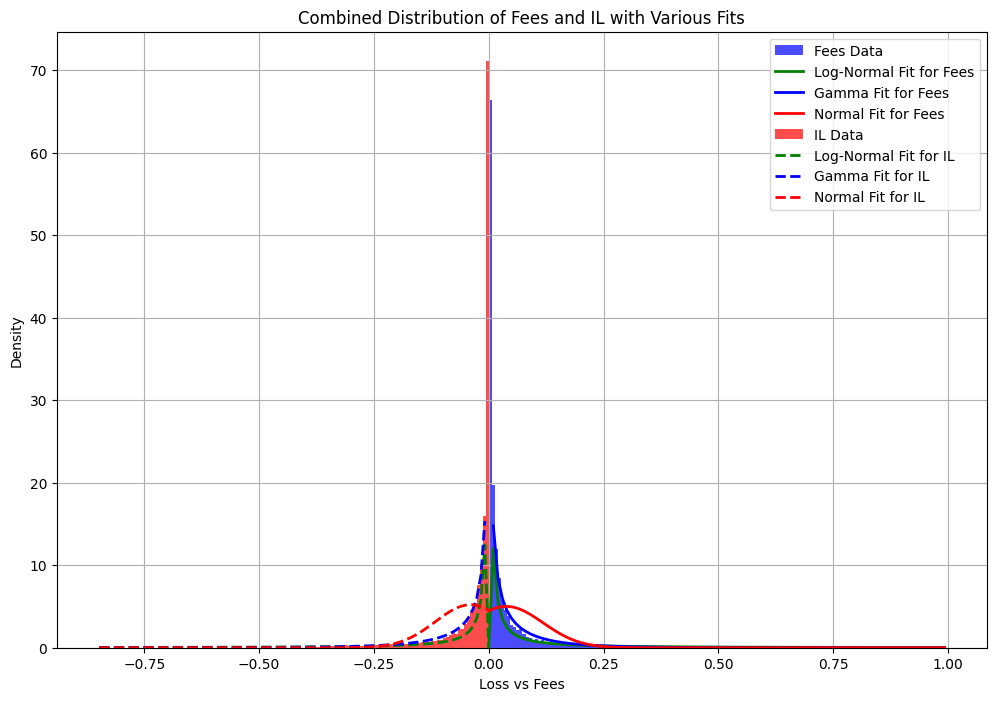

In [746]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, gamma, norm

# Data for fitting
fees_data = combined_df['relativeFees']
il_data = combined_df['IL_formula']  # Keep IL as negative for combining

# Adding a small value to avoid zeros
small_value = 1e-6
fees_data = fees_data + small_value
il_data = il_data - small_value  # Subtract small value to avoid zero issues for IL

# Fit distributions for Fees
params_gamma_fees = gamma.fit(fees_data, floc=0)
params_gamma_fees = gamma.fit(fees_data, floc=0)
params_norm_fees = norm.fit(fees_data)

# Fit distributions for IL (negated)
params_gamma_il = gamma.fit(-il_data, floc=0)
params_gamma_il = gamma.fit(-il_data, floc=0)
params_norm_il = norm.fit(-il_data)

# Generate values for plotting the fit
x_fees = np.linspace(0, fees_data.max(), 100)
x_il = np.linspace(il_data.min(), 0, 100)
pdf_gamma_fees = gamma.pdf(x_fees, *params_gamma_fees)
pdf_gamma_fees = gamma.pdf(x_fees, *params_gamma_fees)
pdf_norm_fees = norm.pdf(x_fees, *params_norm_fees)
pdf_gamma_il = gamma.pdf(-x_il, *params_gamma_il)  # Invert x_il for PDF
pdf_gamma_il = gamma.pdf(-x_il, *params_gamma_il)  # Invert x_il for PDF
pdf_norm_il = norm.pdf(-x_il, *params_norm_il)  # Invert x_il for PDF

# Combined plot with Fees and IL
plt.figure(figsize=(12, 8))

# Histogram for Fees
plt.hist(fees_data, bins=60, color='blue', alpha=0.6, range=(0, 0.4), density=True, label='Fees Data')

# Fits for Fees
plt.plot(x_fees, pdf_gamma_fees, 'g-', lw=2, label='Log-Normal Fit for Fees')
plt.plot(x_fees, pdf_gamma_fees, 'b-', lw=2, label='Gamma Fit for Fees')
plt.plot(x_fees, pdf_norm_fees, 'r-', lw=2, label='Normal Fit for Fees')

# Histogram for IL
plt.hist(il_data, bins=60, color='red', alpha=0.6, range=(-0.4, 0), density=True, label='IL Data')

# Fits for IL
plt.plot(x_il, pdf_gamma_il, 'g--', lw=2, label='Log-Normal Fit for IL')
plt.plot(x_il, pdf_gamma_il, 'b--', lw=2, label='Gamma Fit for IL')
plt.plot(x_il, pdf_norm_il, 'r--', lw=2, label='Normal Fit for IL')

plt.title('Combined Distribution of Fees and IL with Various Fits')
plt.xlabel('Loss vs Fees')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


KS Test for Fees (0 to 0.4): Statistic=0.040037577835151786, p-value=4.0527315903633126e-35
KS Test for IL (-0.4 to 0): Statistic=0.0579439383752718, p-value=2.6628740974544017e-73


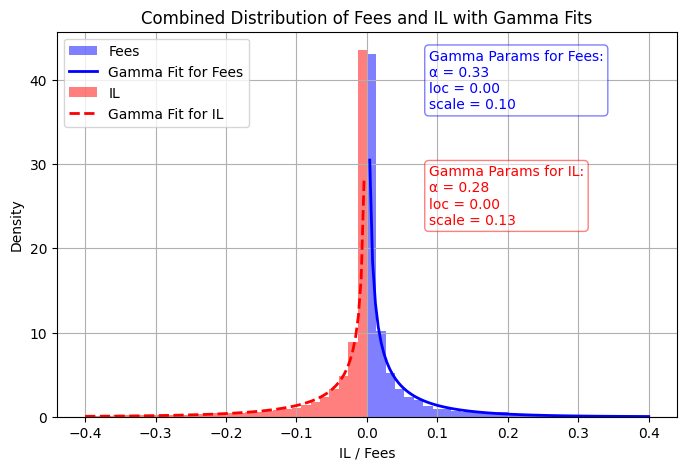

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, kstest

# Data for fitting, limited to the interval [0, 0.4]
fees_data = combined_df['relativeFees']
il_data = combined_df['IL_formula']  # Keep IL as negative for combining

# Adding a small value to avoid zeros
small_value = 1e-6
fees_data = fees_data + small_value
il_data = il_data - small_value  # Subtract small value to avoid zero issues for IL

# Filter data to the range [0, 0.4]
fees_data_filtered = fees_data[(fees_data >= 0) & (fees_data <= 0.4)]
il_data_filtered = il_data[(il_data >= -0.4) & (il_data <= 0)]

# Fit Gamma distribution to the filtered data
params_gamma_fees = gamma.fit(fees_data_filtered, floc=0)
params_gamma_il = gamma.fit(-il_data_filtered, floc=0)  # Fit gamma on negated IL

# Generate fitted data for KS test
gamma_fees_fitted = gamma.rvs(*params_gamma_fees, size=len(fees_data_filtered))
gamma_il_fitted = -gamma.rvs(*params_gamma_il, size=len(il_data_filtered))

# Perform KS test
ks_stat_fees, ks_p_value_fees = kstest(fees_data_filtered, 'gamma', args=params_gamma_fees)
ks_stat_il, ks_p_value_il = kstest(-il_data_filtered, 'gamma', args=params_gamma_il)

print(f'KS Test for Fees (0 to 0.4): Statistic={ks_stat_fees}, p-value={ks_p_value_fees}')
print(f'KS Test for IL (-0.4 to 0): Statistic={ks_stat_il}, p-value={ks_p_value_il}')

# Generate values for plotting the fit
x_fees = np.linspace(0, 0.4, 100)
x_il = np.linspace(-0.4, 0, 100)
pdf_gamma_fees = gamma.pdf(x_fees, *params_gamma_fees)
pdf_gamma_il = gamma.pdf(-x_il, *params_gamma_il)  # Invert x_il for PDF

# Combined plot with Fees and IL
plt.figure(figsize=(8, 5))

# Histogram for Fees
plt.hist(fees_data_filtered, bins=30, color='blue', alpha=0.5, range=(0, 0.4), density=True, label='Fees')
plt.plot(x_fees, pdf_gamma_fees, 'b-', lw=2, label='Gamma Fit for Fees')

# Histogram for IL
plt.hist(il_data_filtered, bins=30, color='red', alpha=0.5, range=(-0.4, 0), density=True, label='IL')
plt.plot(x_il, pdf_gamma_il, 'r--', lw=2, label='Gamma Fit for IL')

# Annotate parameters
params_text_fees = f'Gamma Params for Fees:\nα = {params_gamma_fees[0]:.2f}\nloc = {params_gamma_fees[1]:.2f}\nscale = {params_gamma_fees[2]:.2f}'
params_text_il = f'Gamma Params for IL:\nα = {params_gamma_il[0]:.2f}\nloc = {params_gamma_il[1]:.2f}\nscale = {params_gamma_il[2]:.2f}'
plt.annotate(params_text_fees, xy=(0.6, 0.8), xycoords='axes fraction', fontsize=10, color='blue',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.5))
plt.annotate(params_text_il, xy=(0.6, 0.5), xycoords='axes fraction', fontsize=10, color='red',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.5))

# Customize plot
plt.title('Combined Distribution of Fees and IL with Gamma Fits')
plt.xlabel('IL / Fees')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


KS Test for Fees (0 to 0.4): Statistic=0.040037577835151786, p-value=4.0527315903633126e-35
KS Test for IL (-0.4 to 0): Statistic=0.0579439383752718, p-value=2.6628740974544017e-73


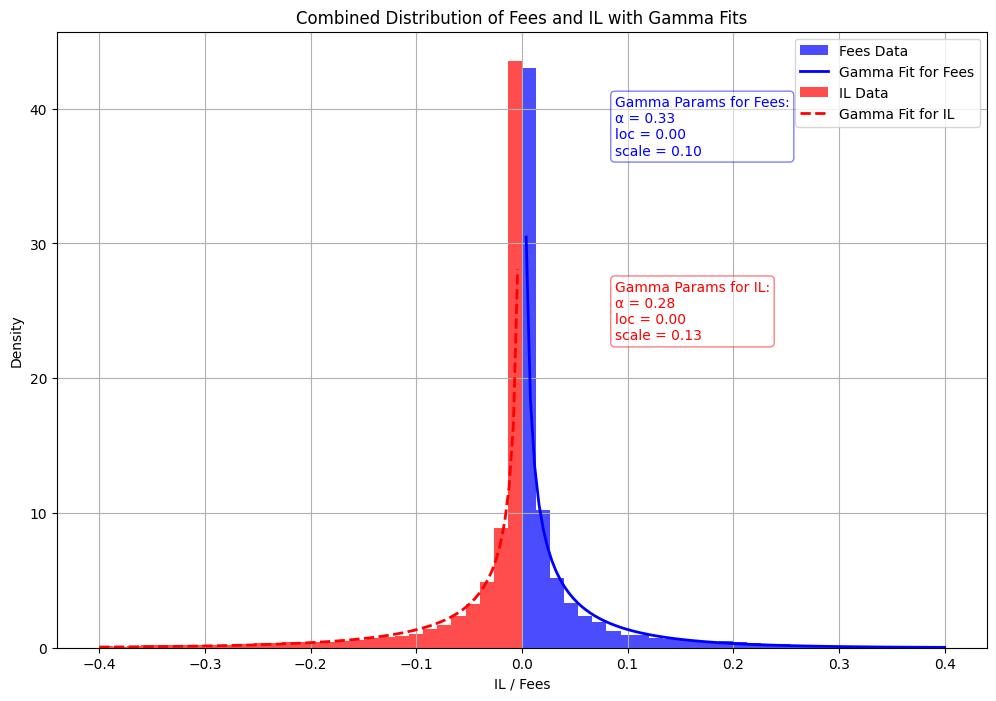

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, kstest

# Data for fitting, limited to the interval [0, 0.4]
fees_data = combined_df['relativeFees']
il_data = combined_df['IL_formula']  # Keep IL as negative for combining

# Adding a small value to avoid zeros
small_value = 1e-6
fees_data = fees_data + small_value
il_data = il_data - small_value  # Subtract small value to avoid zero issues for IL

# Filter data to the range [0, 0.4]
fees_data_filtered = fees_data[(fees_data >= 0) & (fees_data <= 0.4)]
il_data_filtered = il_data[(il_data >= -0.4) & (il_data <= 0)]

# Fit Gamma distribution to the filtered data
params_gamma_fees = gamma.fit(fees_data_filtered, floc=0)
params_gamma_il = gamma.fit(-il_data_filtered, floc=0)  # Fit gamma on negated IL

# Generate fitted data for KS test
gamma_fees_fitted = gamma.rvs(*params_gamma_fees, size=len(fees_data_filtered))
gamma_il_fitted = -gamma.rvs(*params_gamma_il, size=len(il_data_filtered))

# Perform KS test
ks_stat_fees, ks_p_value_fees = kstest(fees_data_filtered, 'gamma', args=params_gamma_fees)
ks_stat_il, ks_p_value_il = kstest(-il_data_filtered, 'gamma', args=params_gamma_il)

print(f'KS Test for Fees (0 to 0.4): Statistic={ks_stat_fees}, p-value={ks_p_value_fees}')
print(f'KS Test for IL (-0.4 to 0): Statistic={ks_stat_il}, p-value={ks_p_value_il}')

# Generate values for plotting the fit
x_fees = np.linspace(0, 0.4, 100)
x_il = np.linspace(-0.4, 0, 100)
pdf_gamma_fees = gamma.pdf(x_fees, *params_gamma_fees)
pdf_gamma_il = gamma.pdf(-x_il, *params_gamma_il)  # Invert x_il for PDF

# Combined plot with Fees and IL
plt.figure(figsize=(12, 8))

# Histogram for Fees
plt.hist(fees_data_filtered, bins=30, color='blue', alpha=0.6, range=(0, 0.4), density=True, label='Fees Data')
plt.plot(x_fees, pdf_gamma_fees, 'b-', lw=2, label='Gamma Fit for Fees')

# Histogram for IL
plt.hist(il_data_filtered, bins=30, color='red', alpha=0.6, range=(-0.4, 0), density=True, label='IL Data')
plt.plot(x_il, pdf_gamma_il, 'r--', lw=2, label='Gamma Fit for IL')

# Annotate parameters
params_text_fees = f'Gamma Params for Fees:\nα = {params_gamma_fees[0]:.2f}\nloc = {params_gamma_fees[1]:.2f}\nscale = {params_gamma_fees[2]:.2f}'
params_text_il = f'Gamma Params for IL:\nα = {params_gamma_il[0]:.2f}\nloc = {params_gamma_il[1]:.2f}\nscale = {params_gamma_il[2]:.2f}'
plt.annotate(params_text_fees, xy=(0.6, 0.8), xycoords='axes fraction', fontsize=10, color='blue',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.5))
plt.annotate(params_text_il, xy=(0.6, 0.5), xycoords='axes fraction', fontsize=10, color='red',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.5))

# Customize plot
plt.title('Combined Distribution of Fees and IL with Gamma Fits')
plt.xlabel('IL / Fees')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


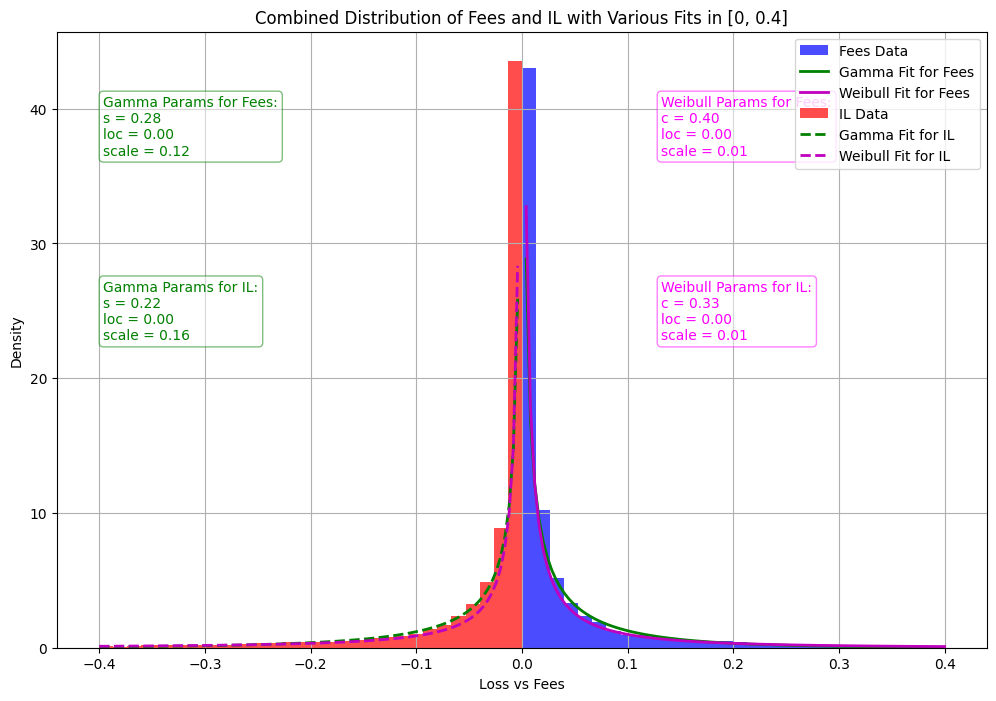

KS Test for Gamma Fees (0 to 0.4): Statistic=0.08744198640331202, p-value=4.228208482807383e-166
KS Test for Gamma IL (-0.4 to 0): Statistic=0.08461836539011314, p-value=5.811626862665598e-156
KS Test for Weibull Fees (0 to 0.4): Statistic=0.09673684587187581, p-value=2.869537253138392e-203
KS Test for Weibull IL (-0.4 to 0): Statistic=0.10261301508840143, p-value=2.5846984445751194e-229


In [777]:
from scipy.stats import gamma, weibull_min, kstest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data for fitting, limited to the interval [0, 0.4]
fees_data = combined_df['relativeFees']
il_data = combined_df['IL_formula']

# Adding a small value to avoid zeros
small_value = 1e-9
fees_data = fees_data + small_value
il_data = il_data - small_value  # Subtract small value to avoid zero issues for IL

# Filter data to the range [0, 0.4]
fees_data_filtered = fees_data[(fees_data >= 0) & (fees_data <= 0.4)]
il_data_filtered = il_data[(il_data >= -0.4) & (il_data <= 0)]

# Fit Log-Normal distribution
params_gamma_fees = gamma.fit(fees_data_filtered, floc=0)
params_gamma_il = gamma.fit(-il_data_filtered, floc=0)  # Fit lognorm on negated IL

# Fit Weibull distribution
params_weibull_fees = weibull_min.fit(fees_data_filtered, floc=0)
params_weibull_il = weibull_min.fit(-il_data_filtered, floc=0)  # Fit weibull on negated IL

# Generate values for plotting the fit
x_fees = np.linspace(0, 0.4, 100)
x_il = np.linspace(-0.4, 0, 100)
pdf_gamma_fees = gamma.pdf(x_fees, *params_gamma_fees)
pdf_gamma_il = gamma.pdf(-x_il, *params_gamma_il)  # Invert x_il for PDF
pdf_weibull_fees = weibull_min.pdf(x_fees, *params_weibull_fees)
pdf_weibull_il = weibull_min.pdf(-x_il, *params_weibull_il)  # Invert x_il for PDF

# Combined plot with Fees and IL
plt.figure(figsize=(12, 8))

# Histogram for Fees
plt.hist(fees_data_filtered, bins=30, color='blue', alpha=0.6, range=(0, 0.4), density=True, label='Fees Data')
plt.plot(x_fees, pdf_gamma_fees, 'g-', lw=2, label='Gamma Fit for Fees')
plt.plot(x_fees, pdf_weibull_fees, 'm-', lw=2, label='Weibull Fit for Fees')

# Histogram for IL
plt.hist(il_data_filtered, bins=30, color='red', alpha=0.6, range=(-0.4, 0), density=True, label='IL Data')
plt.plot(x_il, pdf_gamma_il, 'g--', lw=2, label='Gamma Fit for IL')
plt.plot(x_il, pdf_weibull_il, 'm--', lw=2, label='Weibull Fit for IL')

# Annotate parameters for Log-Normal
params_text_gamma_fees = f'Gamma Params for Fees:\ns = {params_gamma_fees[0]:.2f}\nloc = {params_gamma_fees[1]:.2f}\nscale = {params_gamma_fees[2]:.2f}'
params_text_gamma_il = f'Gamma Params for IL:\ns = {params_gamma_il[0]:.2f}\nloc = {params_gamma_il[1]:.2f}\nscale = {params_gamma_il[2]:.2f}'
plt.annotate(params_text_gamma_fees, xy=(0.05, 0.8), xycoords='axes fraction', fontsize=10, color='green',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white', alpha=0.5))
plt.annotate(params_text_gamma_il, xy=(0.05, 0.5), xycoords='axes fraction', fontsize=10, color='green',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white', alpha=0.5))

# Annotate parameters for Weibull
params_text_weibull_fees = f'Weibull Params for Fees:\nc = {params_weibull_fees[0]:.2f}\nloc = {params_weibull_fees[1]:.2f}\nscale = {params_weibull_fees[2]:.2f}'
params_text_weibull_il = f'Weibull Params for IL:\nc = {params_weibull_il[0]:.2f}\nloc = {params_weibull_il[1]:.2f}\nscale = {params_weibull_il[2]:.2f}'
plt.annotate(params_text_weibull_fees, xy=(0.65, 0.8), xycoords='axes fraction', fontsize=10, color='magenta',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='magenta', facecolor='white', alpha=0.5))
plt.annotate(params_text_weibull_il, xy=(0.65, 0.5), xycoords='axes fraction', fontsize=10, color='magenta',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='magenta', facecolor='white', alpha=0.5))

# Customize plot
plt.title('Combined Distribution of Fees and IL with Various Fits in [0, 0.4]')
plt.xlabel('Loss vs Fees')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Perform KS test for log-normal and Weibull as well
ks_stat_gamma_fees, ks_p_value_gamma_fees = kstest(fees_data_filtered, 'gamma', args=params_gamma_fees)
ks_stat_gamma_il, ks_p_value_gamma_il = kstest(-il_data_filtered, 'gamma', args=params_gamma_il)

ks_stat_weibull_fees, ks_p_value_weibull_fees = kstest(fees_data_filtered, 'weibull_min', args=params_weibull_fees)
ks_stat_weibull_il, ks_p_value_weibull_il = kstest(-il_data_filtered, 'weibull_min', args=params_weibull_il)

print(f'KS Test for Gamma Fees (0 to 0.4): Statistic={ks_stat_gamma_fees}, p-value={ks_p_value_gamma_fees}')
print(f'KS Test for Gamma IL (-0.4 to 0): Statistic={ks_stat_gamma_il}, p-value={ks_p_value_gamma_il}')
print(f'KS Test for Weibull Fees (0 to 0.4): Statistic={ks_stat_weibull_fees}, p-value={ks_p_value_weibull_fees}')
print(f'KS Test for Weibull IL (-0.4 to 0): Statistic={ks_stat_weibull_il}, p-value={ks_p_value_weibull_il}')


In [753]:
from scipy.stats import kstest, gamma, lognorm

# Gamma distribution fit test
gamma_params_fees = gamma.fit(fees_data, floc=0)
gamma_params_il = gamma.fit(-il_data, floc=0)  # Fit gamma on negated IL

# Generate fitted data
gamma_fees_fitted = gamma.rvs(*gamma_params_fees, size=len(fees_data))
gamma_il_fitted = -gamma.rvs(*gamma_params_il, size=len(il_data))

# Kolmogorov-Smirnov test for goodness of fit
ks_stat_fees, ks_p_value_fees = kstest(fees_data, 'gamma', args=gamma_params_fees)
ks_stat_il, ks_p_value_il = kstest(-il_data, 'gamma', args=gamma_params_il)

print(f'KS Test for Fees: Statistic={ks_stat_fees}, p-value={ks_p_value_fees}')
print(f'KS Test for IL: Statistic={ks_stat_il}, p-value={ks_p_value_il}')


KS Test for Fees: Statistic=0.04374164602416042, p-value=2.934505986711992e-42
KS Test for IL: Statistic=0.056235809401429915, p-value=1.3854815630463357e-69


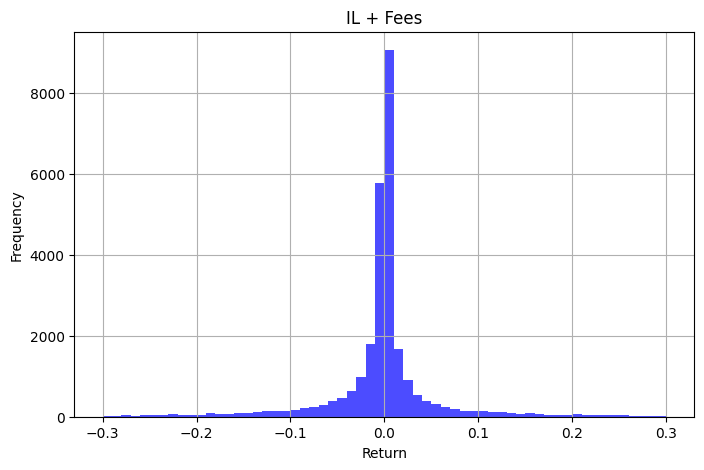

count    27583.000000
mean        -0.001020
std          0.082691
min         -0.824594
25%         -0.009591
50%          0.000014
75%          0.007046
max          0.948038
Name: percentage_return, dtype: float64

In [381]:
plt.figure(figsize=(8, 5))
risky_combined_df['percentage_return'] = risky_combined_df['relativeFees'] + risky_combined_df['IL_formula']
plt.hist(risky_combined_df['percentage_return'], bins=60, color='blue', alpha=0.6, range=(-0.3, 0.3))

plt.title('IL + Fees')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

risky_combined_df['percentage_return'].describe()

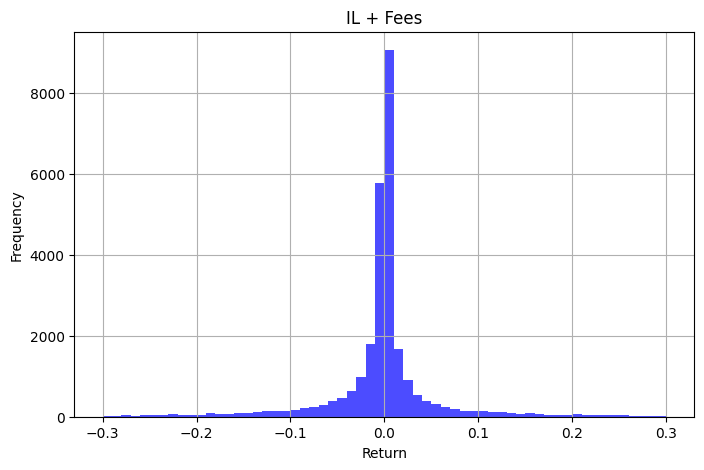

count    27583.000000
mean        -0.001020
std          0.082691
min         -0.824594
25%         -0.009591
50%          0.000014
75%          0.007046
max          0.948038
Name: percentageReturn, dtype: float64

In [467]:
plt.figure(figsize=(8, 5))
plt.hist(risky_combined_df['percentageReturn'], bins=60, color='blue', alpha=0.6, range=(-0.3, 0.3))

plt.title('IL + Fees')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

risky_combined_df['percentageReturn'].describe()

KS Test for Gamma (Percentage Return -0.4 to 0.4): Statistic=0.9796326618692338, p-value=0.0
KS Test for Weibull (Percentage Return -0.4 to 0.4): Statistic=0.9678828544293125, p-value=0.0


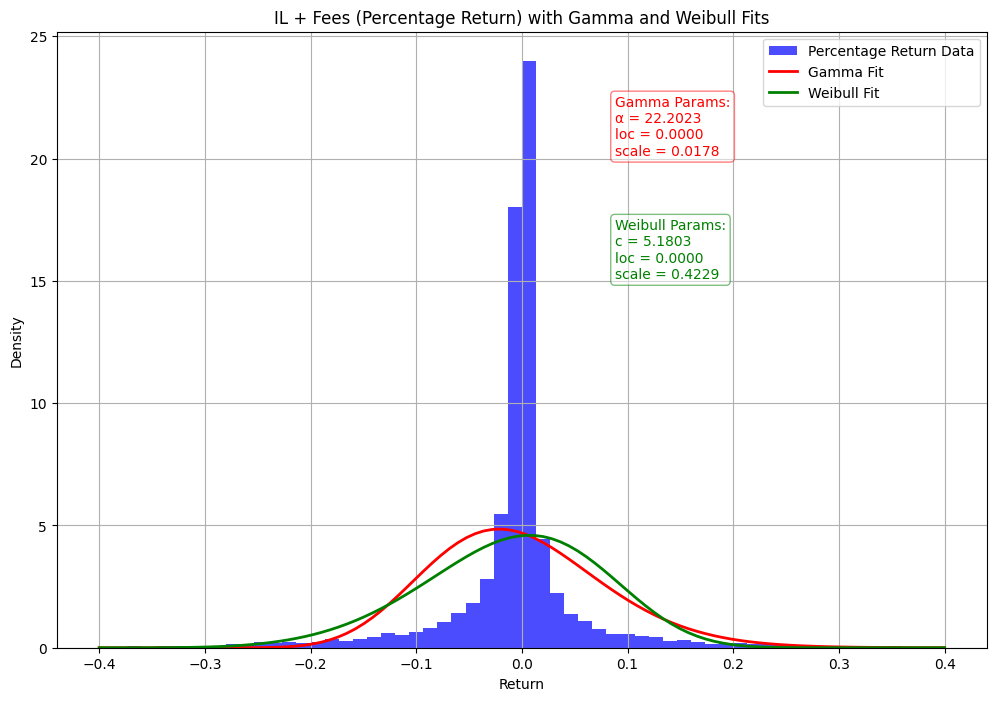

count    24149.000000
mean        -0.001708
std          0.084404
min         -0.801620
25%         -0.012841
50%          0.000000
75%          0.007570
max          0.905610
Name: percentage_return, dtype: float64


In [765]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

# Filter data to the range [-0.4, 0.4]
percentage_return_filtered = risky_combined_df['percentage_return'][
    (risky_combined_df['percentage_return'] >= -0.4) & (risky_combined_df['percentage_return'] <= 0.4)
]

# Fit Gamma distribution to the filtered data
params_gamma = gamma.fit(percentage_return_filtered - percentage_return_filtered.min() + 1e-6, floc=0)

# Fit Weibull distribution to the filtered data
params_weibull = weibull_min.fit(percentage_return_filtered - percentage_return_filtered.min() + 1e-6, floc=0)

# Perform KS test
ks_stat_gamma, ks_p_value_gamma = kstest(percentage_return_filtered, 'gamma', args=params_gamma)
ks_stat_weibull, ks_p_value_weibull = kstest(percentage_return_filtered, 'weibull_min', args=params_weibull)

print(f'KS Test for Gamma (Percentage Return -0.4 to 0.4): Statistic={ks_stat_gamma}, p-value={ks_p_value_gamma}')
print(f'KS Test for Weibull (Percentage Return -0.4 to 0.4): Statistic={ks_stat_weibull}, p-value={ks_p_value_weibull}')

# Generate values for plotting the fit
x_vals = np.linspace(-0.4, 0.4, 100)
pdf_gamma = gamma.pdf(x_vals - percentage_return_filtered.min() + 1e-6, *params_gamma)
pdf_weibull = weibull_min.pdf(x_vals - percentage_return_filtered.min() + 1e-6, *params_weibull)

# Plot histogram and Gamma/Weibull fits
plt.figure(figsize=(12, 8))
plt.hist(percentage_return_filtered, bins=60, color='blue', alpha=0.6, range=(-0.4, 0.4), density=True, label='Percentage Return Data')
plt.plot(x_vals, pdf_gamma, 'r-', lw=2, label='Gamma Fit')
plt.plot(x_vals, pdf_weibull, 'g-', lw=2, label='Weibull Fit')

# Annotate parameters for Gamma
params_text_gamma = (f'Gamma Params:\nα = {params_gamma[0]:.4f}\nloc = {params_gamma[1]:.4f}\nscale = {params_gamma[2]:.4f}')
plt.annotate(params_text_gamma, xy=(0.6, 0.8), xycoords='axes fraction', fontsize=10, color='red',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.5))

# Annotate parameters for Weibull
params_text_weibull = (f'Weibull Params:\nc = {params_weibull[0]:.4f}\nloc = {params_weibull[1]:.4f}\nscale = {params_weibull[2]:.4f}')
plt.annotate(params_text_weibull, xy=(0.6, 0.6), xycoords='axes fraction', fontsize=10, color='green',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white', alpha=0.5))

# Customize plot
plt.title('IL + Fees (Percentage Return) with Gamma and Weibull Fits')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

# Describe the percentage return
print(risky_combined_df['percentage_return'].describe())

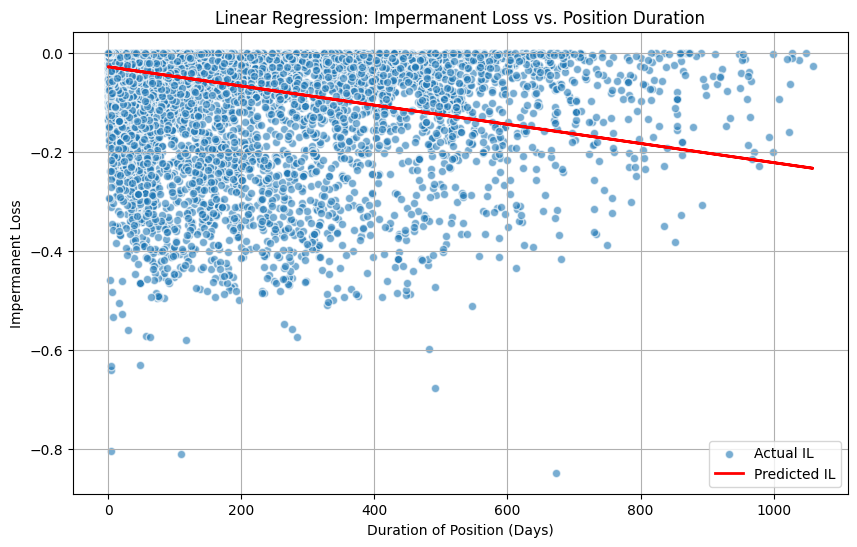

Slope (Coefficient): -0.00019338345125802554
Intercept: -0.028534555781774655
R-squared value: 0.1204


In [457]:
from sklearn.linear_model import LinearRegression

X = risky_combined_df[['weightedDurationDays']]  # features need to be 2D
y = risky_combined_df['IL_formula'] 

model = LinearRegression()
model.fit(X, y)
risky_combined_df['predicted_IL'] = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolors='w', label='Actual IL')
plt.plot(X, risky_combined_df['predicted_IL'], color='red', linewidth=2, label='Predicted IL')
plt.title('Linear Regression: Impermanent Loss vs. Position Duration')
plt.xlabel('Duration of Position (Days)')
plt.ylabel('Impermanent Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Slope (Coefficient):", model.coef_[0])
print("Intercept:", model.intercept_)

r_squared = model.score(X, y)
print(f'R-squared value: {r_squared:.4f}')

Mean Squared Error: 0.006006949306724909
R^2 Score: 0.004943623680362386
Intercept: -0.042568991515297895
Coefficient: 3.1848655798787706e-09


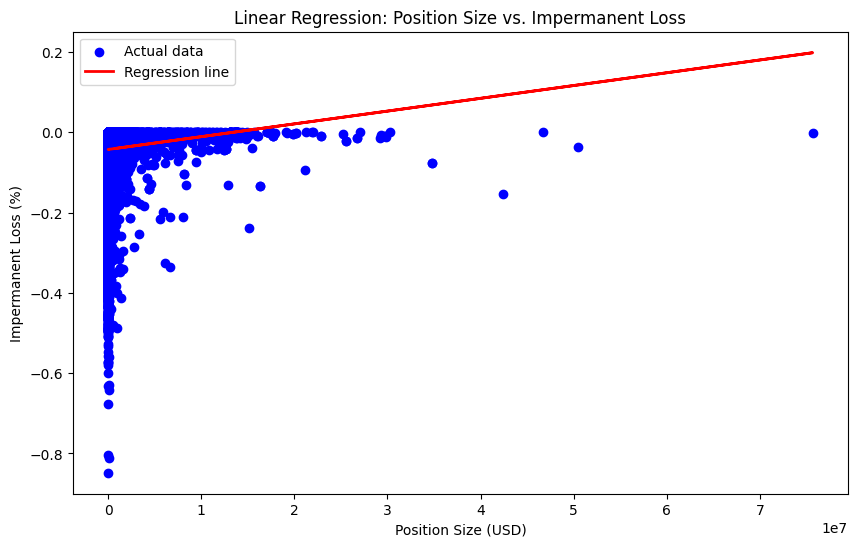

In [459]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming risky_combined_df is your DataFrame

# Extract the necessary columns
X = risky_combined_df[['event_amountUSD']].values  # Independent variable
y = risky_combined_df['IL_formula'].values  # Dependent variable

# Create a linear regression model
model = LinearRegression()

# Fit the model to the entire dataset
model.fit(X, y)

# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

# Plotting the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression line')
plt.title('Linear Regression: Position Size vs. Impermanent Loss')
plt.xlabel('Position Size (USD)')
plt.ylabel('Impermanent Loss (%)')
plt.legend()
plt.show()


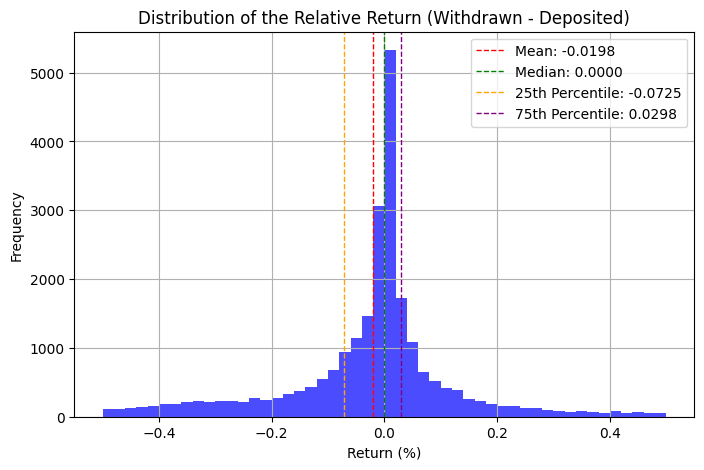

count    25154.000000
mean        -0.019820
std          0.208730
min         -0.778610
25%         -0.072472
50%          0.000000
75%          0.029807
max          2.995511
Name: relative_return, dtype: float64


In [542]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(combined_df['relative_return'], bins=50, color='blue', alpha=0.6, range=(-0.5, 0.5))

# Calculate statistical values
mean = combined_df['relative_return'].mean()
median = combined_df['relative_return'].median()
quantiles = combined_df['relative_return'].quantile([0.25, 0.75])

# Plot vertical lines for mean, median, and quantiles
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.4f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median:.4f}')
plt.axvline(quantiles[0.25], color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {quantiles[0.25]:.4f}')
plt.axvline(quantiles[0.75], color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {quantiles[0.75]:.4f}')

# Add title and labels
plt.title('Distribution of the Relative Return (Withdrawn - Deposited)')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Print the descriptive statistics
print(combined_df['relative_return'].describe())


In [460]:
print(combined_df['IL_formula'].describe())

count    25154.000000
mean        -0.039654
std          0.076557
min         -0.847990
25%         -0.037898
50%         -0.008116
75%         -0.000729
max          0.000000
Name: IL_formula, dtype: float64


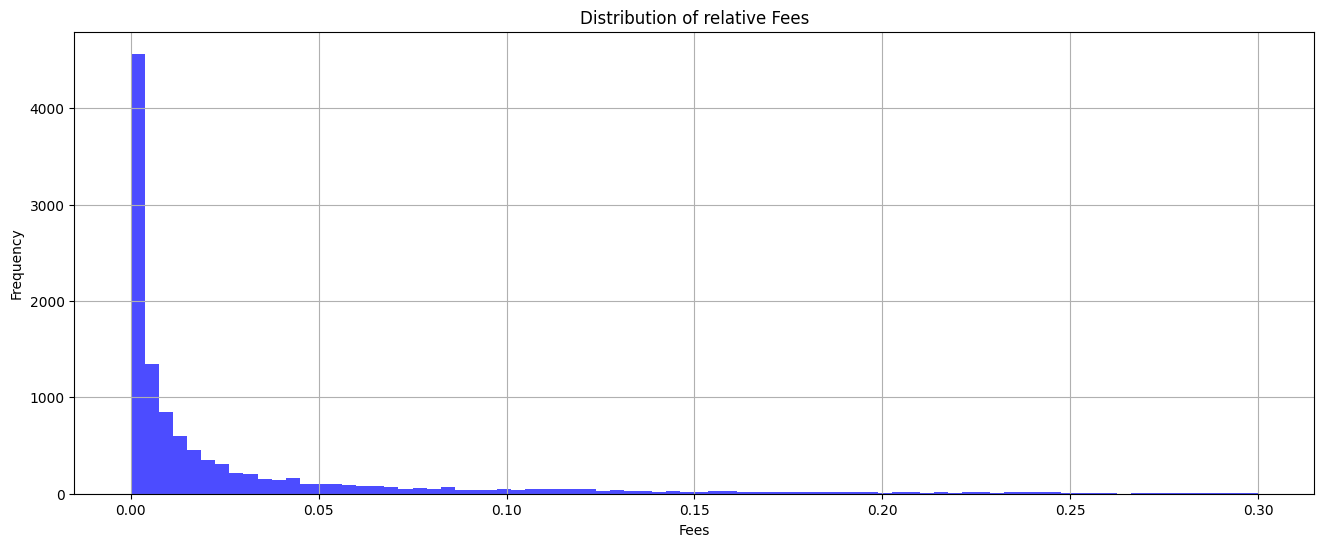

In [461]:
plt.figure(figsize=(16, 6))
plt.hist(combined_df['IL_fees'], bins=80, color='blue', alpha=0.6, range=(0, 0.3))
plt.title('Distribution of relative Fees')
plt.xlabel('Fees')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

c:\Users\thano\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thano\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


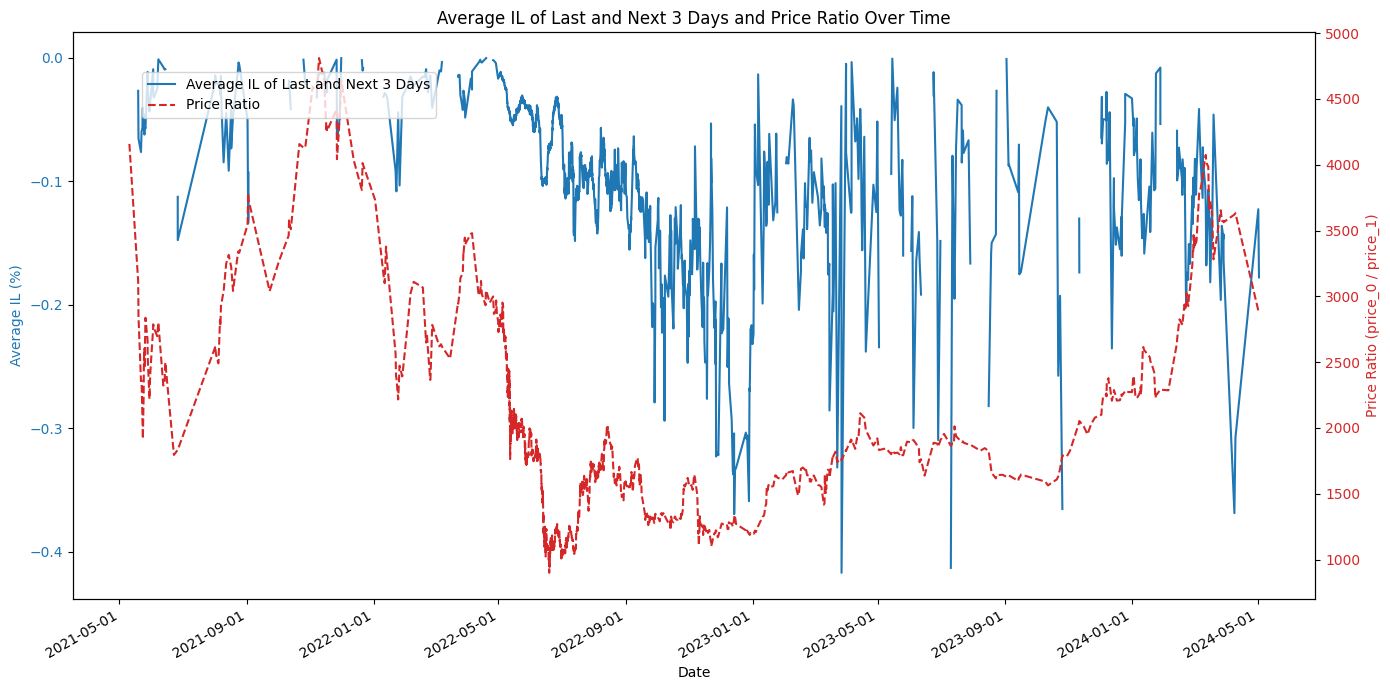

In [228]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Assuming pool_dataframes is your dictionary containing the dataframes
usdc_weth_df = pool_dataframes['USDC_WETH_3000'].copy()  # Make a copy of the DataFrame

# filter out transactions smaller than 1000 USD
usdc_weth_df = usdc_weth_df[usdc_weth_df['event_amountUSD'] > 1000]

usdc_weth_df = usdc_weth_df.reset_index(drop=True)

# Convert Unix epoch timestamps to datetime
usdc_weth_df.loc[:, 'timestamp'] = pd.to_datetime(usdc_weth_df['event_timestamp'], unit='s')

# Group by timestamp and calculate the average IL and price ratio
grouped = usdc_weth_df.groupby('timestamp').agg({'IL_formula': 'mean', 'price_0': 'mean', 'price_1': 'mean'}).reset_index()
grouped['price_ratio'] = grouped['price_1'] / grouped['price_0']

# Function to calculate the average IL of the last and next 3 days
def calculate_average_IL(timestamp):
    # Get the indices of the last and next 3 days
    last_days_idx = np.where((grouped['timestamp'] >= timestamp - pd.Timedelta(days=3)) & (grouped['timestamp'] < timestamp))[0]
    next_days_idx = np.where((grouped['timestamp'] > timestamp) & (grouped['timestamp'] <= timestamp + pd.Timedelta(days=3)))[0]
    
    # Concatenate the IL values of the last and next 3 days
    il_values = np.concatenate([grouped.iloc[last_days_idx]['IL_formula'], grouped.iloc[next_days_idx]['IL_formula']])
    
    # Calculate the average IL
    avg_il = np.mean(il_values)
    
    return avg_il

# Calculate the average IL for each timestamp
grouped['IL_final_avg'] = grouped['timestamp'].apply(calculate_average_IL)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot average IL
ax1.set_xlabel('Date')
ax1.set_ylabel('Average IL (%)', color='tab:blue')
ax1.plot(grouped['timestamp'], grouped['IL_final_avg'], color='tab:blue', label='Average IL of Last and Next 3 Days')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Format the x-axis for dates
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Create a second y-axis for the price ratio
ax2 = ax1.twinx()
ax2.set_ylabel('Price Ratio (price_0 / price_1)', color='tab:red')
ax2.plot(grouped['timestamp'], grouped['price_ratio'], color='tab:red', label='Price Ratio', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and legend
plt.title('Average IL of Last and Next 3 Days and Price Ratio Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()


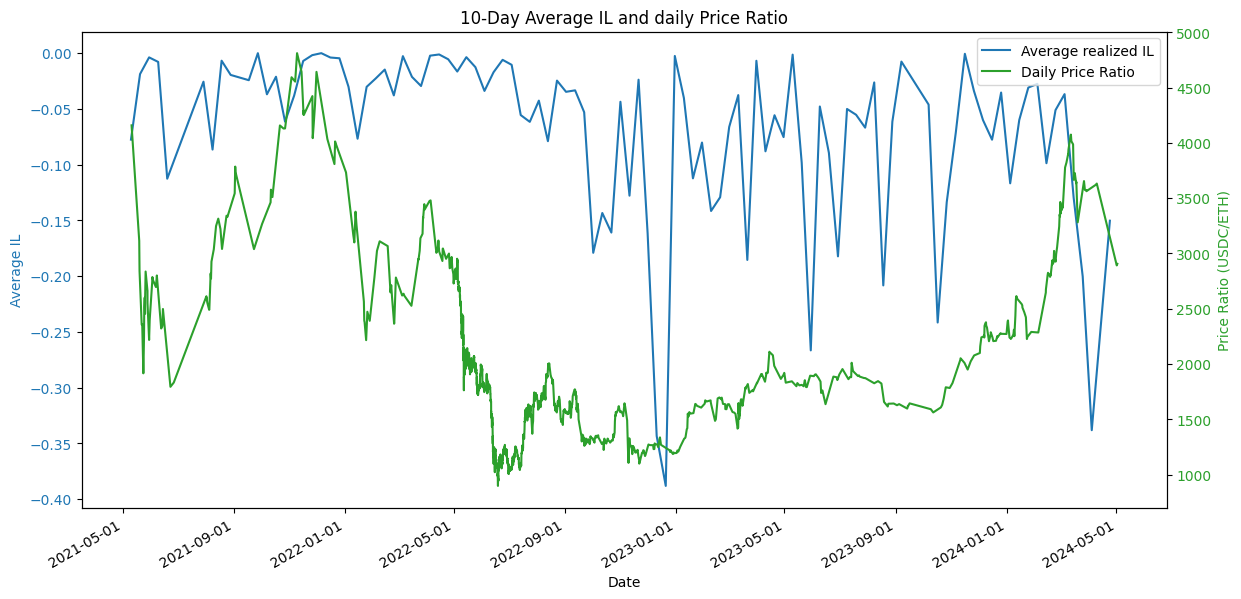

In [379]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Assuming pool_dataframes is your dictionary containing the dataframes
usdc_weth_df = pool_dataframes['USDC_WETH_3000'].copy()  # Make a copy of the DataFrame

# Filter out transactions smaller than 1000 USD
usdc_weth_df = usdc_weth_df[usdc_weth_df['event_amountUSD'] > 1000]

# Convert Unix epoch timestamps to datetime
usdc_weth_df.loc[:, 'timestamp'] = pd.to_datetime(usdc_weth_df['event_timestamp'], unit='s')

# Set timestamp as index
usdc_weth_df.set_index('timestamp', inplace=True)

# Calculate the daily price ratio
daily_price_ratio = usdc_weth_df['price_1'] / usdc_weth_df['price_0']

# Calculate the change of price ratio for each point
price_ratio_change = daily_price_ratio
#price_ratio_change = daily_price_ratio.rolling(window=2).apply(lambda x: abs(x[-1] - x[0]))

resampled_price_ratio_change = price_ratio_change.resample('7D').mean()

resampled_price_ratio_change = resampled_price_ratio_change.diff().abs()

resampled_price_ratio_change = resampled_price_ratio_change.interpolate()

# Resample the DataFrame by week and calculate the mean IL for each week
weekly_grouped = usdc_weth_df['IL_formula'].resample('10D').median().reset_index()

weekly_grouped = weekly_grouped.interpolate()

grouped = usdc_weth_df.groupby('timestamp').agg({'IL_formula': 'mean', 'price_0': 'mean', 'price_1': 'mean'}).reset_index()
grouped['price_ratio'] = grouped['price_1'] / grouped['price_0']
grouped = grouped.interpolate()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot weekly average IL
ax1.set_xlabel('Date')
ax1.set_ylabel('Average IL', color='tab:blue')
ax1.plot(weekly_grouped['timestamp'], weekly_grouped['IL_formula'], color='tab:blue', label='Average realized IL')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot resampled average price ratio change
ax2 = ax1.twinx()
ax2.set_ylabel('Price Ratio (USDC/ETH)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.plot(grouped['timestamp'], grouped['price_ratio'], color='tab:green', label='Daily Price Ratio', linestyle='-')

# Format the x-axis for dates
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Add a title and legend
plt.title('10-Day Average IL and daily Price Ratio')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88))

# Show the plot
plt.show()


Correlation coefficient between smoothed average IL and price ratio: 0.53


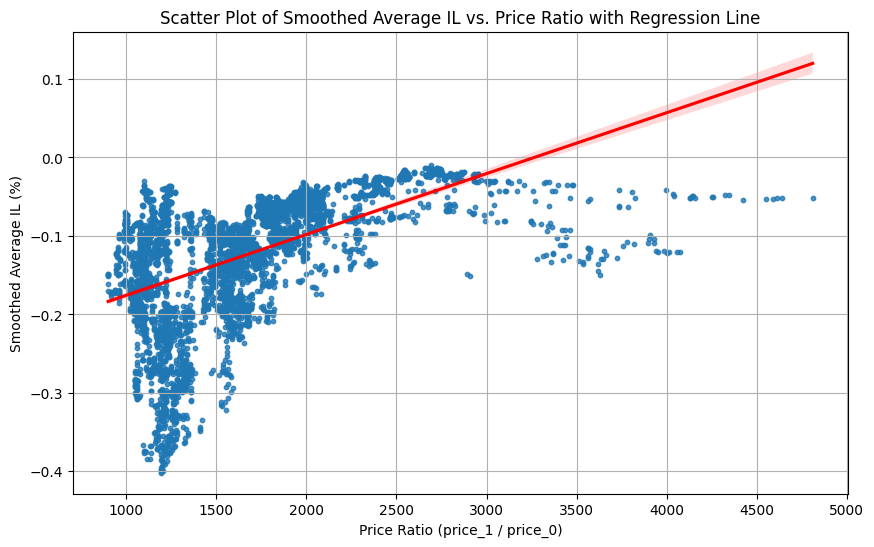

In [509]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Assuming pool_dataframes is your dictionary containing the dataframes
usdc_weth_df = pool_dataframes['USDC_WETH_3000'].copy()  # Make a copy of the DataFrame

# Convert Unix epoch timestamps to datetime
usdc_weth_df.loc[:, 'timestamp'] = pd.to_datetime(usdc_weth_df['event_timestamp'], unit='s')

# Group by timestamp and calculate the average IL and price ratio
grouped = usdc_weth_df.groupby('timestamp').agg({'IL_final': 'mean', 'price_0': 'mean', 'price_1': 'mean'}).reset_index()
grouped['price_ratio'] = grouped['price_1'] / grouped['price_0']

# Calculate the rolling mean for the average IL
grouped['IL_final_smooth'] = grouped['IL_final'].rolling(window=50).mean()  # Adjust window size as needed

# Calculate the correlation coefficient
correlation = grouped[['IL_final_smooth', 'price_ratio']].corr().iloc[0, 1]
print(f"Correlation coefficient between smoothed average IL and price ratio: {correlation:.2f}")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='price_ratio', y='IL_final_smooth', data=grouped, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('Price Ratio (price_1 / price_0)')
plt.ylabel('Smoothed Average IL (%)')
plt.title('Scatter Plot of Smoothed Average IL vs. Price Ratio with Regression Line')
plt.grid(True)
plt.show()


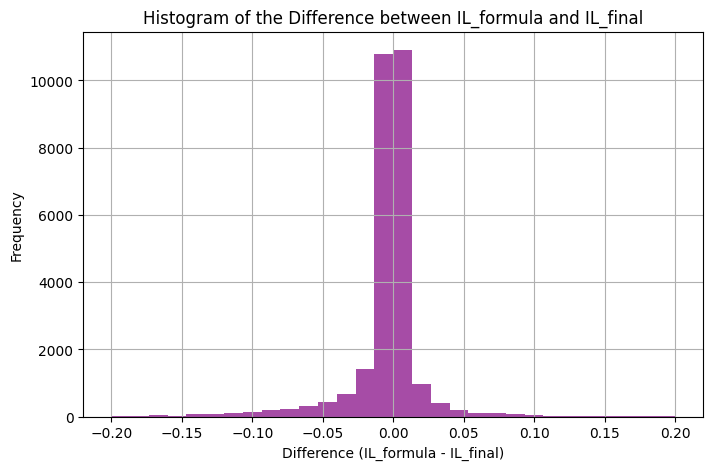

In [380]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming risky_combined_df is your DataFrame

# Calculate the difference between IL_formula and IL_final
risky_combined_df['IL_difference'] = risky_combined_df['IL_formula'] - risky_combined_df['IL_initial']

# Plotting the difference as a histogram
plt.figure(figsize=(8, 5))
plt.hist(risky_combined_df['IL_difference'], bins=30, color='purple', alpha=0.6, range=(-0.2, 0.2))
plt.xlabel('Difference (IL_formula - IL_final)')
plt.ylabel('Frequency')
plt.title('Histogram of the Difference between IL_formula and IL_final')
plt.grid(True)
plt.show()

# density


In [ ]:
import pandas as pd
from tabulate import tabulate

# Assuming risky_combined_df is your DataFrame

# Calculate the difference between IL_formula and IL_final
risky_combined_df['IL_difference'] = risky_combined_df['IL_formula'] - risky_combined_df['IL_initial']

# Filter the DataFrame where the difference is more than 0.2
large_difference_df = risky_combined_df[risky_combined_df['IL_difference'] > 0.2]

# Select relevant columns for display
table = large_difference_df[['IL_formula', 'IL_initial', 'IL_difference', 'event_amountUSD', 'initialValue', 'finalValue']]

# Display the table in a readable format using tabulate
print(tabulate(table, headers='keys', tablefmt='psql', showindex=False))


+--------------+--------------+-----------------+-------------------+------------------+------------------+
|   IL_formula |   IL_initial |   IL_difference |   event_amountUSD |     initialValue |       finalValue |
|--------------+--------------+-----------------+-------------------+------------------+------------------|
|    -0.306724 |    -0.521777 |        0.215053 |       1.19264e+06 | 978138           |      1.19264e+06 |
|    -0.431849 |    -1.03811  |        0.606258 |   61781.3         |  44757.2         |  61781.3         |
|    -0.023078 |    -0.318701 |        0.295623 |      74.6418      |    191.897       |     74.6418      |
|    -0.035628 |    -0.256162 |        0.220534 |    4185.21        |  10357.5         |   4222.92        |
|    -0.162411 |    -0.670381 |        0.50797  |       1.47304e+06 |      1.10426e+06 |      1.47304e+06 |
|    -0.162411 |    -0.670381 |        0.50797  |       1.47304e+06 |      1.10426e+06 |      1.47304e+06 |
|    -0.002883 |    -0.21790

Backup

In [511]:
"""
BACKUP CODE NO LONGER NEEDED

"""


ZERO = 0
Q128 = 2 ** 128
Q256 = 2 ** 256

def subIn256(x, y):
    difference = x - y
    if difference < ZERO:
        return Q256 + difference
    else:
        return difference

def toBigNumber(value):
    return int(value)  # Convert string or number to Python integer, in case large number is in strign format

def getFees(feeGrowthGlobal0, feeGrowthGlobal1, feeGrowth0Low, feeGrowth0Hi, feeGrowthInside0, feeGrowth1Low, feeGrowth1Hi, feeGrowthInside1, liquidity, decimals0, decimals1, tickLower, tickUpper, tickCurrent):
    feeGrowthGlobal_0 = toBigNumber(feeGrowthGlobal0)
    feeGrowthGlobal_1 = toBigNumber(feeGrowthGlobal1)
    tickLowerFeeGrowthOutside_0 = toBigNumber(feeGrowth0Low)
    tickLowerFeeGrowthOutside_1 = toBigNumber(feeGrowth1Low)
    tickUpperFeeGrowthOutside_0 = toBigNumber(feeGrowth0Hi)
    tickUpperFeeGrowthOutside_1 = toBigNumber(feeGrowth1Hi)
    tickLowerFeeGrowthBelow_0 = ZERO
    tickLowerFeeGrowthBelow_1 = ZERO
    tickUpperFeeGrowthAbove_0 = ZERO
    tickUpperFeeGrowthAbove_1 = ZERO

    if tickCurrent >= tickUpper:
        tickUpperFeeGrowthAbove_0 = subIn256(feeGrowthGlobal_0, tickUpperFeeGrowthOutside_0)
        tickUpperFeeGrowthAbove_1 = subIn256(feeGrowthGlobal_1, tickUpperFeeGrowthOutside_1)
    else:
        tickUpperFeeGrowthAbove_0 = tickUpperFeeGrowthOutside_0
        tickUpperFeeGrowthAbove_1 = tickUpperFeeGrowthOutside_1

    if tickCurrent >= tickLower:
        tickLowerFeeGrowthBelow_0 = tickLowerFeeGrowthOutside_0
        tickLowerFeeGrowthBelow_1 = tickLowerFeeGrowthOutside_1
    else:
        tickLowerFeeGrowthBelow_0 = subIn256(feeGrowthGlobal_0, tickLowerFeeGrowthOutside_0)
        tickLowerFeeGrowthBelow_1 = subIn256(feeGrowthGlobal_1, tickLowerFeeGrowthOutside_1)

    fr_t1_0 = subIn256(subIn256(feeGrowthGlobal_0, tickLowerFeeGrowthBelow_0), tickUpperFeeGrowthAbove_0)
    fr_t1_1 = subIn256(subIn256(feeGrowthGlobal_1, tickLowerFeeGrowthBelow_1), tickUpperFeeGrowthAbove_1)
    feeGrowthInsideLast_0 = toBigNumber(feeGrowthInside0)
    feeGrowthInsideLast_1 = toBigNumber(feeGrowthInside1)

    uncollectedFees_0 = (liquidity * subIn256(fr_t1_0, feeGrowthInsideLast_0)) // Q128
    uncollectedFees_1 = (liquidity * subIn256(fr_t1_1, feeGrowthInsideLast_1)) // Q128

    uncollectedFeesAdjusted_0 = uncollectedFees_0 / (10 ** decimals0)
    uncollectedFeesAdjusted_1 = uncollectedFees_1 / (10 ** decimals1)
    print(f"Amount fees token 0 in lowest decimal: {int(uncollectedFees_0)}")
    print(f"Amount fees token 1 in lowest decimal: {int(uncollectedFees_1)}")
    print(f"Amount fees token 0 Human format: {uncollectedFeesAdjusted_0:.{decimals0}f}")
    print(f"Amount fees token 1 Human format: {uncollectedFeesAdjusted_1:.{decimals1}f}")


class LiquidityProvider:
    def __init__(self, address):
        """
        Initializes a new LiquidityProvider instance.

        Parameters:
        address (str): The Ethereum address of the liquidity provider.
        """
        self.address = address
        self.positions = []

    def add_position(self, position):
        """
        Adds a new position to the liquidity provider's list of positions.

        Parameters:
        position (Position): The position to be added to this provider.
        """
        self.positions.append(position)
        position.provider = self  # Establish the reverse link from Position to LiquidityProvider

    def get_positions(self):
        """
        Returns a list of all positions for this liquidity provider.
        """
        return self.positions

    def __str__(self):
        """
        Returns a string representation of the LiquidityProvider object.
        """
        return f"Liquidity Provider Address: {self.address}"

class Event:

    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):
        """
        Initializes a new Event instance.

        Parameters:
        block_number (int): The block number at which the event occurred.
        amount (float): The amount of liquidity involved in the event.
        """
        self.blocknumber = blocknumber
        self.collectedFeesToken0 = collectedFeesToken0
        self.collectedFeesToken1 = collectedFeesToken1
        self.depositedToken0 = depositedToken0
        self.depositedToken1 = depositedToken1
        self.feeGrowthInside0LastX128 = feeGrowthInside0LastX128
        self.feeGrowthInside1LastX128 = feeGrowthInside1LastX128
        self.id = id
        self.withdrawnToken0 = withdrawnToken0
        self.withdrawnToken1 = withdrawnToken1
        self.timestamp = timestamp
        self.liquidity = liquidity
        self.amount0 = amount0
        self.amount1 = amount1
        self.amountUSD = amountUSD
        self.tokenPrice0 = 0.5 * amountUSD / amount0
        self.tokenPrice1 = 0.5 * amountUSD / amount1



    def __str__(self):
        """
        Return a basic representation of the event, should be overridden by subclasses.
        """
        return f"Event at Block {self.block_number}, Amount: {self.amount}"

class Mint(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        self.isInitialMint = False
        self.amount = amount

    def __str__(self):
        return f"Mint: Block {self.block_number}, Amount: {self.amount}"

class Burn(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        self.isFinalBurn = False
        self.amount = amount

    def __str__(self):
        return f"Burn: Block {self.block_number}, Amount: {self.amount}"
    
class Collect(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):

    def __str__(self):
        return f"Collect: Block {self.block_number}"
    
class Tick:
    def __init__(self, idx, price0, price1, feeGrowthOutside0X128, feeGrowthOutside1X128):
        """
        Initializes a new Tick instance.

        Parameters:
        price0 (float): The price of token0 in this tick.
        price1 (float): The price of token1 in this tick.
        feeGrowthOutside0X128 (int): The fee growth outside of this tick for token0.
        feeGrowthOutside1X128 (int): The fee growth outside of this tick for token1.
        """
        self.idx = idx
        self.price0 = price0
        self.price1 = price1
        self.feeGrowthOutside0X128 = feeGrowthOutside0X128
        self.feeGrowthOutside1X128 = feeGrowthOutside1X128

    def __str__(self):
        return f"Tick: {self.idx}"


class Position:
    def __init__(self, id, liquidity, owner, pool, amountCollectedUSD, amountDepositedUSD, amountWithdrawnUSD, collectedFeesToken0, collectedFeesToken1, collectedToken0, collectedToken1, initialDepositToken0, initialDepositToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, tickLower, tickUpper, withdrawnToken0, withdrawnToken1):
        """
        Initializes a new Position instance.

        Parameters:
        provider (LiquidityProvider): The liquidity provider associated with this position.
        events (list of Event): A list of events associated with this position.
        """
        self.id = id
        self.liquidity = liquidity
        self.owner = owner
        self.pool = pool #pass Pool object, not in df
        self.token1 = pool.token1
        self.token0 = pool.token0
        self.amountCollectedUSD = amountCollectedUSD
        self.amountDepositedUSD = amountDepositedUSD
        self.amountWithdrawnUSD = amountWithdrawnUSD
        self.collectedFeesToken0 = collectedFeesToken0
        self.collectedFeesToken1 = collectedFeesToken1
        self.collectedToken0 = collectedToken0
        self.collectedToken1 = collectedToken1
        self.initialDepositToken0 = initialDepositToken0 # depositedToken= in TheGraph
        self.initialDepositToken1 = initialDepositToken1
        self.feeGrowthInside0LastX128 = feeGrowthInside0LastX128
        self.feeGrowthInside1LastX128 = feeGrowthInside1LastX128    
        self.tickLower = tickLower
        self.tickUpper = tickUpper
        self.withdrawnToken0 = withdrawnToken0
        self.withdrawnToken1 = withdrawnToken1
        self.events = []

    def add_event(self, event):
        """
        Adds a new event to the position's list of events.

        Parameters:
        event (Event): The event to be added to this position.
        """
        self.events.append(event)
        event.position = self  # Establish the reverse link from Event to Position
        self.events.sort(key=lambda x: x.block_number)

    def getHODLvalue(self, price0, price1):
        value = self.events.amount0 * price0 + self.events.amount1 * price1
        return value
    
    def getFinalHODLvalue(self):
        # get the last mint event and conmpute the value of the position at that time
        mint_event = max([event for event in self.events if isinstance(event, Mint)], key=lambda event: event.block_number)
        burn_event = max([event for event in self.events if isinstance(event, Burn)], key=lambda event: event.block_number)
        return mint_event.amount0 * burn_event.tokenPrice0 + burn_event.tokenPrice1 * mint_event.amount1
        

    def compute_balances(self):
        """
        Computes the current(remaining) liquidity for the position based on the events.
        """
        self.currentLiquidity = 0
        for event in self.events:
            if isinstance(event, Mint):
                self.currentLiquidity += event.liquidity
            elif isinstance(event, Burn):
                self.currentLiquidity -= event.liquidity 

    def compute_IL(self):
        """
        Computes the impermanent loss for the position based on the events.
        """
        self.IL = 0
        for event in self.events:
            if isinstance(event, Mint):
                self.IL += event.liquidity
            elif isinstance(event, Burn):
                self.IL -= event.liquidity

    def add_liquidity_provider(self, provider):
        """
        Adds a new liquidity provider to the position.

        Parameters:
        provider (LiquidityProvider): The liquidity provider to be added to this position.
        """
        self.provider = provider # Establish the link from Position to LiquidityProvider

    def get_events(self):
        """
        Returns a list of all events for this position.
        """
        return self.events
    
    def get_provider(self):
        """
        Returns the liquidity provider associated with this position.
        """
        return self.provider

    def __str__(self):
        events_str = "\n".join([str(event) for event in self.events])
        return f"Position for {self.provider}\nEvents:\n{events_str}"


class PoolSample:
    def __init__(self, pool: Pool):
        self.pool = pool
        self.positions = []

    def add_position(self, position:Position):
        self.positions.append(position)
        position.pool = self


SyntaxError: invalid syntax (67136874.py, line 128)